# Baseline Code

This code introduces a two-step training for the N-HPatches problem. In N-HPatches problem, we aim to generate a patch descriptor that is able to perform successfully tasks such as matching, retrieval or verification. 

Contrary to classical HPatches dataset, in N-HPatches, images contain random non-smooth perturbations produced by a synthetic noise. This noise could be critical when training the descriptor, therefore, we introduce a denoising model that could help us to deal with those perturbations. Denoising models have been already introduced in the course [tutorials](https://github.com/MatchLab-Imperial/deep-learning-course) and lectures, their objective is to generate a clean/denoised version of the input image.  We will refer in this code to the images with noise as `noisy`, to the images after applying the denoise model as `denoised` and the original patches from HPatches (so no extra noise added) which are used as ground-truth for the denoising step as `clean`. 


Thus, we aim to minimize the noise in images before the second step, which is computing a feature vector, also called descriptor. Those descriptions must be a powerful representation of the input patches. The idea behind is that if two descriptors belong two similar patches, they should be close to each other, i.e. have a low Euclidean distance. See figure below:

![](https://i.ibb.co/4tvm3Vh/descriptorspace.png)

This baseline code gives a method you can use to compare to whatever another approach you develop.  There are several other approaches you can test to see if there is any improvement, e.g. train the descriptor directly with noisy patches, without the denoising model. However, this code provides some guidance about how to implement the different blocks, how to stack them if desired, how to read the data and how to evaluate the method.

The values given can be improved without changing the core method, only by tuning correctly the hyperparameters or giving it more training time, among others.

As a first step of the project, you should get familiar with the problem and the provided code, so you can develop more complex and robust algorithms afterward. 

## Safety Check

As Google Colab is an external platform, we cannot guarantee that everytime you connect to a remote server, you will have the same amount of RAM or video RAM. For that reason, we will first check the amount of memory we have in the notebook. RAM should be around 12.9 GB, which is enough to load the datasets in memory. Also, usually, we have available 11.4 GB of GPU memory, which is more than enough to run this code. However, some users reported having only 500 MB of GPU memory. If you have that amount, restart the environment to see if you get the corresponding 11.4 GB.

In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

RAM Free: 29.6 GB  | Proc size: 50.6 MB
GPU RAM Free: 10886MB | Used: 378MB | Util   3% | Total 11264MB


## Downloading Functions and Data

The first step is to clone the GitHub repository of the course, which contains already implemented functions. You can use your own function and import them here doing the same. In addition, we are going to download and extract the N-HPatches data. 

As a note, in colab, we can run terminal commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we will use to move through directories (`cd` command). It takes around 5 minutes to download and unzip the dataset. 


In [ ]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

In [3]:
# Change directory
%cd keras_triplet_descriptor    


C:\Users\User\Downloads\keras_triplet_descriptor


In [ ]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


In [ ]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [4]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [5]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [6]:
hpatches_dir = './hpatches'
splits_path = 'splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   

In [ ]:
seqs

In [7]:
seqs_train = list(filter(lambda x: x.split('\\')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('\\')[-1] in split['test'], seqs)) 

In [ ]:
len(seqs)

In [ ]:
len(seqs_train)

In [ ]:
len(seqs_test)

## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [8]:
def get_denoise_model(shape, do=0):
  
    inputs = Input(shape)
    
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(inputs)))
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(pool1)))
    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(pool2)))
    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(pool3)))
    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation = 'relu', padding='same')(pool4)))
    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation = 'relu', padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(up6)))
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation = 'relu', padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(up7)))
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation = 'relu', padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(up8)))
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation = 'relu', padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(up9)))
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation = 'relu', padding='same')(conv9)))

    conv10 = Dropout(do)(Conv2D(1, (1, 1))(conv9))

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


def get_descriptor_model(shape):
  
    '''Architecture copies HardNet architecture'''

    init_weights = keras.initializers.he_normal()

    descriptor_model = Sequential()
    descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))
    descriptor_model.add(Dropout(0.3))

    descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))

    # Final descriptor reshape
    descriptor_model.add(Reshape((128,)))

    return descriptor_model
  

def triplet_loss(x):
  
    output_dim = 128
    a, p, n = x
    _alpha = 1.0
    positive_distance = K.mean(K.square(a - p), axis=-1)
    negative_distance = K.mean(K.square(a - n), axis=-1)

    return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [9]:
denoise_generator = DenoiseHPatches(random.sample(seqs_train, 5), batch_size=50)
denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
#denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
#denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.38s/it]


In [10]:
shape = (32, 32, 1)
denoise_model_adam_lr1 = get_denoise_model(shape)
denoise_model_adam_lr2 = get_denoise_model(shape)
denoise_model_adam_lr3 = get_denoise_model(shape)
denoise_model_adam_lr4 = get_denoise_model(shape)
denoise_model_adam_lr5 = get_denoise_model(shape)

Instructions for updating:
Colocations handled automatically by placer.


We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [11]:
adam1 = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam2 = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam3 = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam4 = keras.optimizers.Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam5 = keras.optimizers.Adam(lr=1e-1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


denoise_model_adam_lr1.compile(loss='mean_absolute_error', optimizer=adam1, metrics=['mae'])
denoise_model_adam_lr2.compile(loss='mean_absolute_error', optimizer=adam2, metrics=['mae'])
denoise_model_adam_lr3.compile(loss='mean_absolute_error', optimizer=adam3, metrics=['mae'])
denoise_model_adam_lr4.compile(loss='mean_absolute_error', optimizer=adam4, metrics=['mae'])
denoise_model_adam_lr5.compile(loss='mean_absolute_error', optimizer=adam5, metrics=['mae'])


#epochs = 1
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
#for e in range(epochs):
denoise_history_adam_lr1 = denoise_model_adam_lr1.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)
#denoise_model_adam_lr1.save('denoise_adam_lr1.h5')

denoise_history_adam_lr2 = denoise_model_adam_lr2.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)
#denoise_model_adam_lr2.save('denoise_adam_lr2.h5')

denoise_history_adam_lr3 = denoise_model_adam_lr3.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)
#denoise_model_adam_lr3.save('denoise_adam_lr3.h5')

denoise_history_adam_lr4 = denoise_model_adam_lr4.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)
#denoise_model_adam_lr4.save('denoise_adam_lr4.h5')

denoise_history_adam_lr5 = denoise_model_adam_lr5.fit_generator(generator=denoise_generator, 
                                            epochs=5, verbose=1, 
                                            validation_data=denoise_generator_val)
#denoise_model_adam_lr5.save('denoise_adam_lr5.h5')


### Saves optimizer and weights


### Uploads files to external hosting
#!curl -F "file=@denoise.h5" https://file.io


Instructions for updating:
Use tf.cast instead.
Epoch 1/5


 276/1816 [===>..........................] - ETA: 4:42:07 - loss: 114.0172 - mean_absolute_error: 114.01 - ETA: 1:34:42 - loss: 113.5764 - mean_absolute_error: 113.57 - ETA: 57:13 - loss: 113.7708 - mean_absolute_error: 113.7708 - ETA: 41:09 - loss: 116.3686 - mean_absolute_error: 116.36 - ETA: 32:12 - loss: 114.8726 - mean_absolute_error: 114.87 - ETA: 26:33 - loss: 114.1977 - mean_absolute_error: 114.19 - ETA: 22:37 - loss: 113.3770 - mean_absolute_error: 113.37 - ETA: 19:44 - loss: 111.9713 - mean_absolute_error: 111.97 - ETA: 17:32 - loss: 111.1593 - mean_absolute_error: 111.15 - ETA: 15:47 - loss: 111.3088 - mean_absolute_error: 111.30 - ETA: 14:22 - loss: 111.4076 - mean_absolute_error: 111.40 - ETA: 13:13 - loss: 111.2122 - mean_absolute_error: 111.21 - ETA: 12:15 - loss: 110.9454 - mean_absolute_error: 110.94 - ETA: 11:24 - loss: 110.3933 - mean_absolute_error: 110.39 - ETA: 10:41 - loss: 110.1097 - mean_absolute_error: 110.10 - ETA: 10:03 - loss: 110.0210 - mean_absolute_error

 551/1816 [========>.....................] - ETA: 1:50 - loss: 62.4289 - mean_absolute_error: 62.428 - ETA: 1:49 - loss: 62.1552 - mean_absolute_error: 62.155 - ETA: 1:49 - loss: 61.9041 - mean_absolute_error: 61.904 - ETA: 1:48 - loss: 61.6441 - mean_absolute_error: 61.644 - ETA: 1:48 - loss: 61.3867 - mean_absolute_error: 61.386 - ETA: 1:47 - loss: 61.1316 - mean_absolute_error: 61.131 - ETA: 1:47 - loss: 60.8809 - mean_absolute_error: 60.880 - ETA: 1:46 - loss: 60.6388 - mean_absolute_error: 60.638 - ETA: 1:46 - loss: 60.3892 - mean_absolute_error: 60.389 - ETA: 1:45 - loss: 60.1715 - mean_absolute_error: 60.171 - ETA: 1:45 - loss: 59.9309 - mean_absolute_error: 59.930 - ETA: 1:44 - loss: 59.6784 - mean_absolute_error: 59.678 - ETA: 1:44 - loss: 59.4406 - mean_absolute_error: 59.440 - ETA: 1:43 - loss: 59.2052 - mean_absolute_error: 59.205 - ETA: 1:43 - loss: 58.9727 - mean_absolute_error: 58.972 - ETA: 1:43 - loss: 58.7430 - mean_absolute_error: 58.743 - ETA: 1:42 - loss: 58.5221 -

 827/1816 [============>.................] - ETA: 1:10 - loss: 40.9243 - mean_absolute_error: 40.924 - ETA: 1:10 - loss: 40.8279 - mean_absolute_error: 40.827 - ETA: 1:10 - loss: 40.7411 - mean_absolute_error: 40.741 - ETA: 1:09 - loss: 40.6457 - mean_absolute_error: 40.645 - ETA: 1:09 - loss: 40.5978 - mean_absolute_error: 40.597 - ETA: 1:09 - loss: 40.4984 - mean_absolute_error: 40.498 - ETA: 1:09 - loss: 40.4090 - mean_absolute_error: 40.409 - ETA: 1:09 - loss: 40.3195 - mean_absolute_error: 40.319 - ETA: 1:09 - loss: 40.2278 - mean_absolute_error: 40.227 - ETA: 1:08 - loss: 40.1388 - mean_absolute_error: 40.138 - ETA: 1:08 - loss: 40.0475 - mean_absolute_error: 40.047 - ETA: 1:08 - loss: 39.9560 - mean_absolute_error: 39.956 - ETA: 1:08 - loss: 39.8689 - mean_absolute_error: 39.868 - ETA: 1:08 - loss: 39.7774 - mean_absolute_error: 39.777 - ETA: 1:08 - loss: 39.6900 - mean_absolute_error: 39.690 - ETA: 1:07 - loss: 39.6009 - mean_absolute_error: 39.600 - ETA: 1:07 - loss: 39.5106 -

1119/1816 [=================>............] - ETA: 49s - loss: 31.1290 - mean_absolute_error: 31.12 - ETA: 49s - loss: 31.0773 - mean_absolute_error: 31.07 - ETA: 49s - loss: 31.0254 - mean_absolute_error: 31.02 - ETA: 49s - loss: 30.9742 - mean_absolute_error: 30.97 - ETA: 49s - loss: 30.9241 - mean_absolute_error: 30.92 - ETA: 48s - loss: 30.8738 - mean_absolute_error: 30.87 - ETA: 48s - loss: 30.8229 - mean_absolute_error: 30.82 - ETA: 48s - loss: 30.7742 - mean_absolute_error: 30.77 - ETA: 48s - loss: 30.7248 - mean_absolute_error: 30.72 - ETA: 48s - loss: 30.6754 - mean_absolute_error: 30.67 - ETA: 48s - loss: 30.6277 - mean_absolute_error: 30.62 - ETA: 48s - loss: 30.5786 - mean_absolute_error: 30.57 - ETA: 48s - loss: 30.5322 - mean_absolute_error: 30.53 - ETA: 47s - loss: 30.4848 - mean_absolute_error: 30.48 - ETA: 47s - loss: 30.4381 - mean_absolute_error: 30.43 - ETA: 47s - loss: 30.3904 - mean_absolute_error: 30.39 - ETA: 47s - loss: 30.3438 - mean_absolute_error: 30.34 - ETA

1409/1816 [======================>.......] - ETA: 32s - loss: 25.5057 - mean_absolute_error: 25.50 - ETA: 32s - loss: 25.4764 - mean_absolute_error: 25.47 - ETA: 32s - loss: 25.4471 - mean_absolute_error: 25.44 - ETA: 32s - loss: 25.4179 - mean_absolute_error: 25.41 - ETA: 32s - loss: 25.3884 - mean_absolute_error: 25.38 - ETA: 32s - loss: 25.3603 - mean_absolute_error: 25.36 - ETA: 32s - loss: 25.3302 - mean_absolute_error: 25.33 - ETA: 31s - loss: 25.3014 - mean_absolute_error: 25.30 - ETA: 31s - loss: 25.2728 - mean_absolute_error: 25.27 - ETA: 31s - loss: 25.2441 - mean_absolute_error: 25.24 - ETA: 31s - loss: 25.2148 - mean_absolute_error: 25.21 - ETA: 31s - loss: 25.1862 - mean_absolute_error: 25.18 - ETA: 31s - loss: 25.1584 - mean_absolute_error: 25.15 - ETA: 31s - loss: 25.1309 - mean_absolute_error: 25.13 - ETA: 31s - loss: 25.1030 - mean_absolute_error: 25.10 - ETA: 31s - loss: 25.0759 - mean_absolute_error: 25.07 - ETA: 31s - loss: 25.0465 - mean_absolute_error: 25.04 - ETA

1699/1816 [===========================>..] - ETA: 18s - loss: 22.0553 - mean_absolute_error: 22.05 - ETA: 18s - loss: 22.0361 - mean_absolute_error: 22.03 - ETA: 18s - loss: 22.0168 - mean_absolute_error: 22.01 - ETA: 18s - loss: 21.9978 - mean_absolute_error: 21.99 - ETA: 17s - loss: 21.9788 - mean_absolute_error: 21.97 - ETA: 17s - loss: 21.9590 - mean_absolute_error: 21.95 - ETA: 17s - loss: 21.9398 - mean_absolute_error: 21.93 - ETA: 17s - loss: 21.9202 - mean_absolute_error: 21.92 - ETA: 17s - loss: 21.9013 - mean_absolute_error: 21.90 - ETA: 17s - loss: 21.8823 - mean_absolute_error: 21.88 - ETA: 17s - loss: 21.8639 - mean_absolute_error: 21.86 - ETA: 17s - loss: 21.8457 - mean_absolute_error: 21.84 - ETA: 17s - loss: 21.8264 - mean_absolute_error: 21.82 - ETA: 17s - loss: 21.8169 - mean_absolute_error: 21.81 - ETA: 17s - loss: 21.7986 - mean_absolute_error: 21.79 - ETA: 16s - loss: 21.7796 - mean_absolute_error: 21.77 - ETA: 16s - loss: 21.7607 - mean_absolute_error: 21.76 - ETA

1816/1816 [==============================] - ETA: 5s - loss: 19.7090 - mean_absolute_error: 19.709 - ETA: 4s - loss: 19.6952 - mean_absolute_error: 19.695 - ETA: 4s - loss: 19.6815 - mean_absolute_error: 19.681 - ETA: 4s - loss: 19.6680 - mean_absolute_error: 19.668 - ETA: 4s - loss: 19.6551 - mean_absolute_error: 19.655 - ETA: 4s - loss: 19.6416 - mean_absolute_error: 19.641 - ETA: 4s - loss: 19.6283 - mean_absolute_error: 19.628 - ETA: 4s - loss: 19.6151 - mean_absolute_error: 19.615 - ETA: 4s - loss: 19.6015 - mean_absolute_error: 19.601 - ETA: 4s - loss: 19.5878 - mean_absolute_error: 19.587 - ETA: 4s - loss: 19.5751 - mean_absolute_error: 19.575 - ETA: 4s - loss: 19.5624 - mean_absolute_error: 19.562 - ETA: 3s - loss: 19.5495 - mean_absolute_error: 19.549 - ETA: 3s - loss: 19.5368 - mean_absolute_error: 19.536 - ETA: 3s - loss: 19.5241 - mean_absolute_error: 19.524 - ETA: 3s - loss: 19.5109 - mean_absolute_error: 19.510 - ETA: 3s - loss: 19.4972 - mean_absolute_error: 19.497 - ETA

 264/1816 [===>..........................] - ETA: 2:01 - loss: 8.1714 - mean_absolute_error: 8.171 - ETA: 1:52 - loss: 7.8306 - mean_absolute_error: 7.830 - ETA: 1:38 - loss: 8.0081 - mean_absolute_error: 8.008 - ETA: 1:29 - loss: 7.9776 - mean_absolute_error: 7.977 - ETA: 1:25 - loss: 8.0658 - mean_absolute_error: 8.065 - ETA: 1:22 - loss: 8.0204 - mean_absolute_error: 8.020 - ETA: 1:20 - loss: 8.0580 - mean_absolute_error: 8.058 - ETA: 1:20 - loss: 8.0319 - mean_absolute_error: 8.031 - ETA: 1:19 - loss: 8.0380 - mean_absolute_error: 8.038 - ETA: 1:18 - loss: 8.0142 - mean_absolute_error: 8.014 - ETA: 1:18 - loss: 8.0102 - mean_absolute_error: 8.010 - ETA: 1:18 - loss: 8.0160 - mean_absolute_error: 8.016 - ETA: 1:18 - loss: 8.0035 - mean_absolute_error: 8.003 - ETA: 1:18 - loss: 8.0445 - mean_absolute_error: 8.044 - ETA: 1:18 - loss: 8.0300 - mean_absolute_error: 8.030 - ETA: 1:18 - loss: 8.0487 - mean_absolute_error: 8.048 - ETA: 1:18 - loss: 8.1106 - mean_absolute_error: 8.110 - ETA

 548/1816 [========>.....................] - ETA: 1:06 - loss: 7.9508 - mean_absolute_error: 7.950 - ETA: 1:06 - loss: 7.9470 - mean_absolute_error: 7.947 - ETA: 1:06 - loss: 7.9478 - mean_absolute_error: 7.947 - ETA: 1:06 - loss: 7.9481 - mean_absolute_error: 7.948 - ETA: 1:06 - loss: 7.9476 - mean_absolute_error: 7.947 - ETA: 1:06 - loss: 7.9521 - mean_absolute_error: 7.952 - ETA: 1:06 - loss: 7.9512 - mean_absolute_error: 7.951 - ETA: 1:06 - loss: 7.9528 - mean_absolute_error: 7.952 - ETA: 1:06 - loss: 7.9519 - mean_absolute_error: 7.951 - ETA: 1:06 - loss: 7.9507 - mean_absolute_error: 7.950 - ETA: 1:05 - loss: 7.9447 - mean_absolute_error: 7.944 - ETA: 1:05 - loss: 7.9436 - mean_absolute_error: 7.943 - ETA: 1:05 - loss: 7.9450 - mean_absolute_error: 7.945 - ETA: 1:05 - loss: 7.9406 - mean_absolute_error: 7.940 - ETA: 1:05 - loss: 7.9437 - mean_absolute_error: 7.943 - ETA: 1:05 - loss: 7.9456 - mean_absolute_error: 7.945 - ETA: 1:05 - loss: 7.9474 - mean_absolute_error: 7.947 - ETA

 850/1816 [=============>................] - ETA: 53s - loss: 7.8861 - mean_absolute_error: 7.88 - ETA: 53s - loss: 7.8853 - mean_absolute_error: 7.88 - ETA: 53s - loss: 7.8839 - mean_absolute_error: 7.88 - ETA: 52s - loss: 7.8837 - mean_absolute_error: 7.88 - ETA: 52s - loss: 7.8843 - mean_absolute_error: 7.88 - ETA: 52s - loss: 7.8846 - mean_absolute_error: 7.88 - ETA: 52s - loss: 7.8844 - mean_absolute_error: 7.88 - ETA: 52s - loss: 7.8808 - mean_absolute_error: 7.88 - ETA: 52s - loss: 7.8805 - mean_absolute_error: 7.88 - ETA: 52s - loss: 7.8811 - mean_absolute_error: 7.88 - ETA: 52s - loss: 7.8793 - mean_absolute_error: 7.87 - ETA: 52s - loss: 7.8779 - mean_absolute_error: 7.87 - ETA: 52s - loss: 7.8777 - mean_absolute_error: 7.87 - ETA: 51s - loss: 7.8771 - mean_absolute_error: 7.87 - ETA: 51s - loss: 7.8759 - mean_absolute_error: 7.87 - ETA: 51s - loss: 7.8765 - mean_absolute_error: 7.87 - ETA: 51s - loss: 7.8750 - mean_absolute_error: 7.87 - ETA: 51s - loss: 7.8741 - mean_absolu

1152/1816 [==================>...........] - ETA: 39s - loss: 7.7912 - mean_absolute_error: 7.79 - ETA: 39s - loss: 7.7900 - mean_absolute_error: 7.79 - ETA: 38s - loss: 7.7901 - mean_absolute_error: 7.79 - ETA: 38s - loss: 7.7903 - mean_absolute_error: 7.79 - ETA: 38s - loss: 7.7911 - mean_absolute_error: 7.79 - ETA: 38s - loss: 7.7910 - mean_absolute_error: 7.79 - ETA: 38s - loss: 7.7900 - mean_absolute_error: 7.79 - ETA: 38s - loss: 7.7907 - mean_absolute_error: 7.79 - ETA: 38s - loss: 7.7907 - mean_absolute_error: 7.79 - ETA: 38s - loss: 7.7896 - mean_absolute_error: 7.78 - ETA: 38s - loss: 7.7905 - mean_absolute_error: 7.79 - ETA: 38s - loss: 7.7891 - mean_absolute_error: 7.78 - ETA: 38s - loss: 7.7903 - mean_absolute_error: 7.79 - ETA: 37s - loss: 7.7898 - mean_absolute_error: 7.78 - ETA: 37s - loss: 7.7894 - mean_absolute_error: 7.78 - ETA: 37s - loss: 7.7884 - mean_absolute_error: 7.78 - ETA: 37s - loss: 7.7885 - mean_absolute_error: 7.78 - ETA: 37s - loss: 7.7886 - mean_absolu

1453/1816 [=======================>......] - ETA: 26s - loss: 7.7309 - mean_absolute_error: 7.73 - ETA: 26s - loss: 7.7305 - mean_absolute_error: 7.73 - ETA: 26s - loss: 7.7299 - mean_absolute_error: 7.72 - ETA: 26s - loss: 7.7303 - mean_absolute_error: 7.73 - ETA: 26s - loss: 7.7299 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7295 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7296 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7291 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7289 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7284 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7280 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7270 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7267 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7271 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7269 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7272 - mean_absolute_error: 7.72 - ETA: 25s - loss: 7.7268 - mean_absolute_error: 7.72 - ETA: 24s - loss: 7.7263 - mean_absolu

1755/1816 [===========================>..] - ETA: 14s - loss: 7.6775 - mean_absolute_error: 7.67 - ETA: 14s - loss: 7.6781 - mean_absolute_error: 7.67 - ETA: 14s - loss: 7.6787 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6776 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6780 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6772 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6767 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6761 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6752 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6744 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6741 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6739 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6731 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6725 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6729 - mean_absolute_error: 7.67 - ETA: 13s - loss: 7.6724 - mean_absolute_error: 7.67 - ETA: 12s - loss: 7.6726 - mean_absolute_error: 7.67 - ETA: 12s - loss: 7.6715 - mean_absolu

1816/1816 [==============================] - ETA: 2s - loss: 7.6214 - mean_absolute_error: 7.621 - ETA: 2s - loss: 7.6213 - mean_absolute_error: 7.621 - ETA: 2s - loss: 7.6208 - mean_absolute_error: 7.620 - ETA: 2s - loss: 7.6210 - mean_absolute_error: 7.621 - ETA: 1s - loss: 7.6205 - mean_absolute_error: 7.620 - ETA: 1s - loss: 7.6196 - mean_absolute_error: 7.619 - ETA: 1s - loss: 7.6196 - mean_absolute_error: 7.619 - ETA: 1s - loss: 7.6193 - mean_absolute_error: 7.619 - ETA: 1s - loss: 7.6190 - mean_absolute_error: 7.619 - ETA: 1s - loss: 7.6187 - mean_absolute_error: 7.618 - ETA: 1s - loss: 7.6183 - mean_absolute_error: 7.618 - ETA: 1s - loss: 7.6177 - mean_absolute_error: 7.617 - ETA: 1s - loss: 7.6174 - mean_absolute_error: 7.617 - ETA: 1s - loss: 7.6173 - mean_absolute_error: 7.617 - ETA: 1s - loss: 7.6173 - mean_absolute_error: 7.617 - ETA: 1s - loss: 7.6167 - mean_absolute_error: 7.616 - ETA: 1s - loss: 7.6164 - mean_absolute_error: 7.616 - ETA: 0s - loss: 7.6161 - mean_absolut

 292/1816 [===>..........................] - ETA: 1:21 - loss: 6.6812 - mean_absolute_error: 6.681 - ETA: 1:38 - loss: 6.8997 - mean_absolute_error: 6.899 - ETA: 1:24 - loss: 7.1106 - mean_absolute_error: 7.110 - ETA: 1:19 - loss: 7.0271 - mean_absolute_error: 7.027 - ETA: 1:15 - loss: 7.1876 - mean_absolute_error: 7.187 - ETA: 1:13 - loss: 7.2578 - mean_absolute_error: 7.257 - ETA: 1:12 - loss: 7.2288 - mean_absolute_error: 7.228 - ETA: 1:11 - loss: 7.2399 - mean_absolute_error: 7.239 - ETA: 1:11 - loss: 7.2107 - mean_absolute_error: 7.210 - ETA: 1:10 - loss: 7.2096 - mean_absolute_error: 7.209 - ETA: 1:10 - loss: 7.1929 - mean_absolute_error: 7.192 - ETA: 1:09 - loss: 7.2017 - mean_absolute_error: 7.201 - ETA: 1:09 - loss: 7.2068 - mean_absolute_error: 7.206 - ETA: 1:09 - loss: 7.2124 - mean_absolute_error: 7.212 - ETA: 1:08 - loss: 7.2053 - mean_absolute_error: 7.205 - ETA: 1:08 - loss: 7.2327 - mean_absolute_error: 7.232 - ETA: 1:08 - loss: 7.2384 - mean_absolute_error: 7.238 - ETA

 594/1816 [========>.....................] - ETA: 57s - loss: 7.2868 - mean_absolute_error: 7.28 - ETA: 57s - loss: 7.2877 - mean_absolute_error: 7.28 - ETA: 57s - loss: 7.2874 - mean_absolute_error: 7.28 - ETA: 57s - loss: 7.2881 - mean_absolute_error: 7.28 - ETA: 57s - loss: 7.2902 - mean_absolute_error: 7.29 - ETA: 57s - loss: 7.2909 - mean_absolute_error: 7.29 - ETA: 57s - loss: 7.2901 - mean_absolute_error: 7.29 - ETA: 56s - loss: 7.2873 - mean_absolute_error: 7.28 - ETA: 56s - loss: 7.2870 - mean_absolute_error: 7.28 - ETA: 56s - loss: 7.2858 - mean_absolute_error: 7.28 - ETA: 56s - loss: 7.2846 - mean_absolute_error: 7.28 - ETA: 56s - loss: 7.2837 - mean_absolute_error: 7.28 - ETA: 56s - loss: 7.2822 - mean_absolute_error: 7.28 - ETA: 56s - loss: 7.2838 - mean_absolute_error: 7.28 - ETA: 56s - loss: 7.2848 - mean_absolute_error: 7.28 - ETA: 56s - loss: 7.2862 - mean_absolute_error: 7.28 - ETA: 56s - loss: 7.2863 - mean_absolute_error: 7.28 - ETA: 56s - loss: 7.2873 - mean_absolu

 896/1816 [=============>................] - ETA: 45s - loss: 7.2568 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2569 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2556 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2539 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2553 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2552 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2559 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2555 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2561 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2569 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2573 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2582 - mean_absolute_error: 7.25 - ETA: 45s - loss: 7.2590 - mean_absolute_error: 7.25 - ETA: 44s - loss: 7.2595 - mean_absolute_error: 7.25 - ETA: 44s - loss: 7.2587 - mean_absolute_error: 7.25 - ETA: 44s - loss: 7.2590 - mean_absolute_error: 7.25 - ETA: 44s - loss: 7.2607 - mean_absolute_error: 7.26 - ETA: 44s - loss: 7.2600 - mean_absolu

1198/1816 [==================>...........] - ETA: 34s - loss: 7.2415 - mean_absolute_error: 7.24 - ETA: 34s - loss: 7.2420 - mean_absolute_error: 7.24 - ETA: 34s - loss: 7.2418 - mean_absolute_error: 7.24 - ETA: 34s - loss: 7.2414 - mean_absolute_error: 7.24 - ETA: 34s - loss: 7.2405 - mean_absolute_error: 7.24 - ETA: 34s - loss: 7.2408 - mean_absolute_error: 7.24 - ETA: 34s - loss: 7.2418 - mean_absolute_error: 7.24 - ETA: 34s - loss: 7.2416 - mean_absolute_error: 7.24 - ETA: 33s - loss: 7.2419 - mean_absolute_error: 7.24 - ETA: 33s - loss: 7.2415 - mean_absolute_error: 7.24 - ETA: 33s - loss: 7.2408 - mean_absolute_error: 7.24 - ETA: 33s - loss: 7.2405 - mean_absolute_error: 7.24 - ETA: 33s - loss: 7.2404 - mean_absolute_error: 7.24 - ETA: 33s - loss: 7.2398 - mean_absolute_error: 7.23 - ETA: 33s - loss: 7.2392 - mean_absolute_error: 7.23 - ETA: 33s - loss: 7.2396 - mean_absolute_error: 7.23 - ETA: 33s - loss: 7.2389 - mean_absolute_error: 7.23 - ETA: 33s - loss: 7.2375 - mean_absolu

1500/1816 [=======================>......] - ETA: 23s - loss: 7.2283 - mean_absolute_error: 7.22 - ETA: 23s - loss: 7.2287 - mean_absolute_error: 7.22 - ETA: 23s - loss: 7.2290 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2288 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2284 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2278 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2274 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2269 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2266 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2267 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2266 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2264 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2264 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2260 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2268 - mean_absolute_error: 7.22 - ETA: 22s - loss: 7.2266 - mean_absolute_error: 7.22 - ETA: 21s - loss: 7.2269 - mean_absolute_error: 7.22 - ETA: 21s - loss: 7.2268 - mean_absolu

1802/1816 [============================>.] - ETA: 11s - loss: 7.2148 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2149 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2146 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2147 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2142 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2138 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2133 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2140 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2140 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2140 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2128 - mean_absolute_error: 7.21 - ETA: 11s - loss: 7.2129 - mean_absolute_error: 7.21 - ETA: 10s - loss: 7.2126 - mean_absolute_error: 7.21 - ETA: 10s - loss: 7.2125 - mean_absolute_error: 7.21 - ETA: 10s - loss: 7.2121 - mean_absolute_error: 7.21 - ETA: 10s - loss: 7.2113 - mean_absolute_error: 7.21 - ETA: 10s - loss: 7.2112 - mean_absolute_error: 7.21 - ETA: 10s - loss: 7.2114 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 7.1883 - mean_absolute_error: 7.188 - ETA: 0s - loss: 7.1884 - mean_absolute_error: 7.188 - ETA: 0s - loss: 7.1887 - mean_absolute_error: 7.188 - ETA: 0s - loss: 7.1884 - mean_absolute_error: 7.188 - ETA: 0s - loss: 7.1881 - mean_absolute_error: 7.188 - ETA: 0s - loss: 7.1889 - mean_absolute_error: 7.188 - 74s 41ms/step - loss: 7.1888 - mean_absolute_error: 7.1888 - val_loss: 6.1791 - val_mean_absolute_error: 6.1791
Epoch 4/5


 292/1816 [===>..........................] - ETA: 1:05 - loss: 6.8230 - mean_absolute_error: 6.823 - ETA: 1:41 - loss: 6.6860 - mean_absolute_error: 6.686 - ETA: 1:25 - loss: 6.7163 - mean_absolute_error: 6.716 - ETA: 1:19 - loss: 6.9047 - mean_absolute_error: 6.904 - ETA: 1:17 - loss: 7.0064 - mean_absolute_error: 7.006 - ETA: 1:15 - loss: 7.0411 - mean_absolute_error: 7.041 - ETA: 1:14 - loss: 7.0816 - mean_absolute_error: 7.081 - ETA: 1:14 - loss: 7.0749 - mean_absolute_error: 7.074 - ETA: 1:13 - loss: 7.1026 - mean_absolute_error: 7.102 - ETA: 1:13 - loss: 7.0948 - mean_absolute_error: 7.094 - ETA: 1:12 - loss: 7.0987 - mean_absolute_error: 7.098 - ETA: 1:11 - loss: 7.1202 - mean_absolute_error: 7.120 - ETA: 1:11 - loss: 7.1275 - mean_absolute_error: 7.127 - ETA: 1:10 - loss: 7.0954 - mean_absolute_error: 7.095 - ETA: 1:10 - loss: 7.1232 - mean_absolute_error: 7.123 - ETA: 1:09 - loss: 7.1060 - mean_absolute_error: 7.106 - ETA: 1:09 - loss: 7.0911 - mean_absolute_error: 7.091 - ETA

 594/1816 [========>.....................] - ETA: 57s - loss: 7.0626 - mean_absolute_error: 7.06 - ETA: 57s - loss: 7.0630 - mean_absolute_error: 7.06 - ETA: 57s - loss: 7.0635 - mean_absolute_error: 7.06 - ETA: 57s - loss: 7.0647 - mean_absolute_error: 7.06 - ETA: 57s - loss: 7.0658 - mean_absolute_error: 7.06 - ETA: 56s - loss: 7.0675 - mean_absolute_error: 7.06 - ETA: 56s - loss: 7.0665 - mean_absolute_error: 7.06 - ETA: 56s - loss: 7.0660 - mean_absolute_error: 7.06 - ETA: 56s - loss: 7.0645 - mean_absolute_error: 7.06 - ETA: 56s - loss: 7.0651 - mean_absolute_error: 7.06 - ETA: 56s - loss: 7.0628 - mean_absolute_error: 7.06 - ETA: 56s - loss: 7.0638 - mean_absolute_error: 7.06 - ETA: 56s - loss: 7.0633 - mean_absolute_error: 7.06 - ETA: 56s - loss: 7.0578 - mean_absolute_error: 7.05 - ETA: 56s - loss: 7.0551 - mean_absolute_error: 7.05 - ETA: 56s - loss: 7.0513 - mean_absolute_error: 7.05 - ETA: 56s - loss: 7.0495 - mean_absolute_error: 7.04 - ETA: 56s - loss: 7.0462 - mean_absolu

 896/1816 [=============>................] - ETA: 46s - loss: 7.0481 - mean_absolute_error: 7.04 - ETA: 45s - loss: 7.0478 - mean_absolute_error: 7.04 - ETA: 45s - loss: 7.0471 - mean_absolute_error: 7.04 - ETA: 45s - loss: 7.0466 - mean_absolute_error: 7.04 - ETA: 45s - loss: 7.0472 - mean_absolute_error: 7.04 - ETA: 45s - loss: 7.0475 - mean_absolute_error: 7.04 - ETA: 45s - loss: 7.0480 - mean_absolute_error: 7.04 - ETA: 45s - loss: 7.0497 - mean_absolute_error: 7.04 - ETA: 45s - loss: 7.0509 - mean_absolute_error: 7.05 - ETA: 45s - loss: 7.0508 - mean_absolute_error: 7.05 - ETA: 45s - loss: 7.0510 - mean_absolute_error: 7.05 - ETA: 45s - loss: 7.0508 - mean_absolute_error: 7.05 - ETA: 45s - loss: 7.0498 - mean_absolute_error: 7.04 - ETA: 44s - loss: 7.0499 - mean_absolute_error: 7.04 - ETA: 44s - loss: 7.0505 - mean_absolute_error: 7.05 - ETA: 44s - loss: 7.0502 - mean_absolute_error: 7.05 - ETA: 44s - loss: 7.0490 - mean_absolute_error: 7.04 - ETA: 44s - loss: 7.0505 - mean_absolu

1197/1816 [==================>...........] - ETA: 34s - loss: 7.0365 - mean_absolute_error: 7.03 - ETA: 34s - loss: 7.0365 - mean_absolute_error: 7.03 - ETA: 34s - loss: 7.0355 - mean_absolute_error: 7.03 - ETA: 34s - loss: 7.0353 - mean_absolute_error: 7.03 - ETA: 34s - loss: 7.0344 - mean_absolute_error: 7.03 - ETA: 34s - loss: 7.0328 - mean_absolute_error: 7.03 - ETA: 34s - loss: 7.0314 - mean_absolute_error: 7.03 - ETA: 34s - loss: 7.0312 - mean_absolute_error: 7.03 - ETA: 33s - loss: 7.0320 - mean_absolute_error: 7.03 - ETA: 33s - loss: 7.0317 - mean_absolute_error: 7.03 - ETA: 33s - loss: 7.0325 - mean_absolute_error: 7.03 - ETA: 33s - loss: 7.0314 - mean_absolute_error: 7.03 - ETA: 33s - loss: 7.0314 - mean_absolute_error: 7.03 - ETA: 33s - loss: 7.0315 - mean_absolute_error: 7.03 - ETA: 33s - loss: 7.0317 - mean_absolute_error: 7.03 - ETA: 33s - loss: 7.0324 - mean_absolute_error: 7.03 - ETA: 33s - loss: 7.0323 - mean_absolute_error: 7.03 - ETA: 33s - loss: 7.0326 - mean_absolu

1499/1816 [=======================>......] - ETA: 23s - loss: 7.0238 - mean_absolute_error: 7.02 - ETA: 23s - loss: 7.0242 - mean_absolute_error: 7.02 - ETA: 23s - loss: 7.0241 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0241 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0236 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0232 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0239 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0240 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0246 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0240 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0242 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0241 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0247 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0243 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0245 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0250 - mean_absolute_error: 7.02 - ETA: 22s - loss: 7.0239 - mean_absolute_error: 7.02 - ETA: 21s - loss: 7.0242 - mean_absolu

1801/1816 [============================>.] - ETA: 11s - loss: 7.0087 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0089 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0083 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0081 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0080 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0072 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0073 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0075 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0074 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0076 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0076 - mean_absolute_error: 7.00 - ETA: 11s - loss: 7.0078 - mean_absolute_error: 7.00 - ETA: 10s - loss: 7.0078 - mean_absolute_error: 7.00 - ETA: 10s - loss: 7.0074 - mean_absolute_error: 7.00 - ETA: 10s - loss: 7.0067 - mean_absolute_error: 7.00 - ETA: 10s - loss: 7.0066 - mean_absolute_error: 7.00 - ETA: 10s - loss: 7.0067 - mean_absolute_error: 7.00 - ETA: 10s - loss: 7.0074 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 6.9993 - mean_absolute_error: 6.999 - ETA: 0s - loss: 6.9994 - mean_absolute_error: 6.999 - ETA: 0s - loss: 6.9997 - mean_absolute_error: 6.999 - ETA: 0s - loss: 6.9991 - mean_absolute_error: 6.999 - ETA: 0s - loss: 6.9991 - mean_absolute_error: 6.999 - ETA: 0s - loss: 6.9989 - mean_absolute_error: 6.998 - ETA: 0s - loss: 6.9985 - mean_absolute_error: 6.998 - 74s 41ms/step - loss: 6.9984 - mean_absolute_error: 6.9984 - val_loss: 6.0273 - val_mean_absolute_error: 6.0273
Epoch 5/5


 292/1816 [===>..........................] - ETA: 1:19 - loss: 5.9636 - mean_absolute_error: 5.963 - ETA: 1:35 - loss: 6.2023 - mean_absolute_error: 6.202 - ETA: 1:22 - loss: 6.5909 - mean_absolute_error: 6.590 - ETA: 1:18 - loss: 6.8115 - mean_absolute_error: 6.811 - ETA: 1:15 - loss: 6.8325 - mean_absolute_error: 6.832 - ETA: 1:13 - loss: 6.8182 - mean_absolute_error: 6.818 - ETA: 1:12 - loss: 6.7898 - mean_absolute_error: 6.789 - ETA: 1:11 - loss: 6.8170 - mean_absolute_error: 6.817 - ETA: 1:10 - loss: 6.8196 - mean_absolute_error: 6.819 - ETA: 1:10 - loss: 6.8440 - mean_absolute_error: 6.844 - ETA: 1:09 - loss: 6.8740 - mean_absolute_error: 6.874 - ETA: 1:09 - loss: 6.9013 - mean_absolute_error: 6.901 - ETA: 1:09 - loss: 6.8917 - mean_absolute_error: 6.891 - ETA: 1:09 - loss: 6.8881 - mean_absolute_error: 6.888 - ETA: 1:09 - loss: 6.8639 - mean_absolute_error: 6.863 - ETA: 1:09 - loss: 6.9386 - mean_absolute_error: 6.938 - ETA: 1:09 - loss: 6.9245 - mean_absolute_error: 6.924 - ETA

 594/1816 [========>.....................] - ETA: 57s - loss: 6.9134 - mean_absolute_error: 6.91 - ETA: 57s - loss: 6.9123 - mean_absolute_error: 6.91 - ETA: 57s - loss: 6.9147 - mean_absolute_error: 6.91 - ETA: 57s - loss: 6.9136 - mean_absolute_error: 6.91 - ETA: 57s - loss: 6.9137 - mean_absolute_error: 6.91 - ETA: 57s - loss: 6.9155 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9125 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9124 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9105 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9145 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9171 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9169 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9170 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9173 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9158 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9149 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9192 - mean_absolute_error: 6.91 - ETA: 56s - loss: 6.9171 - mean_absolu

 896/1816 [=============>................] - ETA: 45s - loss: 6.8908 - mean_absolute_error: 6.89 - ETA: 45s - loss: 6.8889 - mean_absolute_error: 6.88 - ETA: 45s - loss: 6.8882 - mean_absolute_error: 6.88 - ETA: 45s - loss: 6.8892 - mean_absolute_error: 6.88 - ETA: 45s - loss: 6.8895 - mean_absolute_error: 6.88 - ETA: 45s - loss: 6.8901 - mean_absolute_error: 6.89 - ETA: 45s - loss: 6.8895 - mean_absolute_error: 6.88 - ETA: 45s - loss: 6.8899 - mean_absolute_error: 6.88 - ETA: 45s - loss: 6.8894 - mean_absolute_error: 6.88 - ETA: 45s - loss: 6.8894 - mean_absolute_error: 6.88 - ETA: 44s - loss: 6.8895 - mean_absolute_error: 6.88 - ETA: 44s - loss: 6.8906 - mean_absolute_error: 6.89 - ETA: 44s - loss: 6.8911 - mean_absolute_error: 6.89 - ETA: 44s - loss: 6.8893 - mean_absolute_error: 6.88 - ETA: 44s - loss: 6.8906 - mean_absolute_error: 6.89 - ETA: 44s - loss: 6.8916 - mean_absolute_error: 6.89 - ETA: 44s - loss: 6.8916 - mean_absolute_error: 6.89 - ETA: 44s - loss: 6.8916 - mean_absolu

1197/1816 [==================>...........] - ETA: 34s - loss: 6.8859 - mean_absolute_error: 6.88 - ETA: 34s - loss: 6.8851 - mean_absolute_error: 6.88 - ETA: 34s - loss: 6.8845 - mean_absolute_error: 6.88 - ETA: 34s - loss: 6.8838 - mean_absolute_error: 6.88 - ETA: 34s - loss: 6.8836 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8848 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8840 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8837 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8835 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8830 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8833 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8830 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8825 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8833 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8827 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8829 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8832 - mean_absolute_error: 6.88 - ETA: 33s - loss: 6.8825 - mean_absolu

1499/1816 [=======================>......] - ETA: 23s - loss: 6.8793 - mean_absolute_error: 6.87 - ETA: 23s - loss: 6.8782 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8783 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8792 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8792 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8782 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8794 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8798 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8801 - mean_absolute_error: 6.88 - ETA: 22s - loss: 6.8796 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8791 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8786 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8783 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8784 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8785 - mean_absolute_error: 6.87 - ETA: 22s - loss: 6.8779 - mean_absolute_error: 6.87 - ETA: 21s - loss: 6.8779 - mean_absolute_error: 6.87 - ETA: 21s - loss: 6.8780 - mean_absolu

1795/1816 [============================>.] - ETA: 11s - loss: 6.8796 - mean_absolute_error: 6.87 - ETA: 11s - loss: 6.8800 - mean_absolute_error: 6.88 - ETA: 11s - loss: 6.8798 - mean_absolute_error: 6.87 - ETA: 11s - loss: 6.8798 - mean_absolute_error: 6.87 - ETA: 11s - loss: 6.8801 - mean_absolute_error: 6.88 - ETA: 11s - loss: 6.8797 - mean_absolute_error: 6.87 - ETA: 11s - loss: 6.8796 - mean_absolute_error: 6.87 - ETA: 11s - loss: 6.8793 - mean_absolute_error: 6.87 - ETA: 11s - loss: 6.8786 - mean_absolute_error: 6.87 - ETA: 11s - loss: 6.8783 - mean_absolute_error: 6.87 - ETA: 11s - loss: 6.8782 - mean_absolute_error: 6.87 - ETA: 10s - loss: 6.8781 - mean_absolute_error: 6.87 - ETA: 10s - loss: 6.8782 - mean_absolute_error: 6.87 - ETA: 10s - loss: 6.8783 - mean_absolute_error: 6.87 - ETA: 10s - loss: 6.8784 - mean_absolute_error: 6.87 - ETA: 10s - loss: 6.8782 - mean_absolute_error: 6.87 - ETA: 10s - loss: 6.8776 - mean_absolute_error: 6.87 - ETA: 10s - loss: 6.8775 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 6.8717 - mean_absolute_error: 6.871 - ETA: 0s - loss: 6.8720 - mean_absolute_error: 6.872 - ETA: 0s - loss: 6.8719 - mean_absolute_error: 6.871 - ETA: 0s - loss: 6.8721 - mean_absolute_error: 6.872 - ETA: 0s - loss: 6.8717 - mean_absolute_error: 6.871 - ETA: 0s - loss: 6.8719 - mean_absolute_error: 6.871 - ETA: 0s - loss: 6.8715 - mean_absolute_error: 6.871 - ETA: 0s - loss: 6.8712 - mean_absolute_error: 6.871 - ETA: 0s - loss: 6.8713 - mean_absolute_error: 6.871 - ETA: 0s - loss: 6.8713 - mean_absolute_error: 6.871 - 74s 41ms/step - loss: 6.8711 - mean_absolute_error: 6.8711 - val_loss: 5.9595 - val_mean_absolute_error: 5.9595
Epoch 1/5


 281/1816 [===>..........................] - ETA: 1:21:56 - loss: 111.3633 - mean_absolute_error: 111.36 - ETA: 28:01 - loss: 106.7139 - mean_absolute_error: 106.7139 - ETA: 17:15 - loss: 106.1794 - mean_absolute_error: 106.17 - ETA: 12:40 - loss: 104.1789 - mean_absolute_error: 104.17 - ETA: 10:05 - loss: 102.4895 - mean_absolute_error: 102.48 - ETA: 8:27 - loss: 99.6743 - mean_absolute_error: 99.6743   - ETA: 7:19 - loss: 96.4272 - mean_absolute_error: 96.427 - ETA: 6:29 - loss: 92.1996 - mean_absolute_error: 92.199 - ETA: 5:51 - loss: 86.4263 - mean_absolute_error: 86.426 - ETA: 5:21 - loss: 81.4709 - mean_absolute_error: 81.470 - ETA: 4:56 - loss: 77.0582 - mean_absolute_error: 77.058 - ETA: 4:36 - loss: 72.9274 - mean_absolute_error: 72.927 - ETA: 4:19 - loss: 69.4819 - mean_absolute_error: 69.481 - ETA: 4:05 - loss: 66.4898 - mean_absolute_error: 66.489 - ETA: 3:52 - loss: 63.5330 - mean_absolute_error: 63.533 - ETA: 3:42 - loss: 61.0225 - mean_absolute_error: 61.022 - ETA: 3:32 

 567/1816 [========>.....................] - ETA: 1:12 - loss: 15.3249 - mean_absolute_error: 15.324 - ETA: 1:12 - loss: 15.2764 - mean_absolute_error: 15.276 - ETA: 1:12 - loss: 15.2235 - mean_absolute_error: 15.223 - ETA: 1:11 - loss: 15.1714 - mean_absolute_error: 15.171 - ETA: 1:11 - loss: 15.1178 - mean_absolute_error: 15.117 - ETA: 1:11 - loss: 15.0657 - mean_absolute_error: 15.065 - ETA: 1:11 - loss: 15.0159 - mean_absolute_error: 15.015 - ETA: 1:11 - loss: 14.9651 - mean_absolute_error: 14.965 - ETA: 1:11 - loss: 14.9166 - mean_absolute_error: 14.916 - ETA: 1:10 - loss: 14.8663 - mean_absolute_error: 14.866 - ETA: 1:10 - loss: 14.8177 - mean_absolute_error: 14.817 - ETA: 1:10 - loss: 14.7703 - mean_absolute_error: 14.770 - ETA: 1:10 - loss: 14.7239 - mean_absolute_error: 14.723 - ETA: 1:10 - loss: 14.6776 - mean_absolute_error: 14.677 - ETA: 1:09 - loss: 14.6323 - mean_absolute_error: 14.632 - ETA: 1:09 - loss: 14.5838 - mean_absolute_error: 14.583 - ETA: 1:09 - loss: 14.5388 -

 861/1816 [=============>................] - ETA: 53s - loss: 11.3000 - mean_absolute_error: 11.30 - ETA: 53s - loss: 11.2823 - mean_absolute_error: 11.28 - ETA: 52s - loss: 11.2665 - mean_absolute_error: 11.26 - ETA: 52s - loss: 11.2505 - mean_absolute_error: 11.25 - ETA: 52s - loss: 11.2374 - mean_absolute_error: 11.23 - ETA: 52s - loss: 11.2240 - mean_absolute_error: 11.22 - ETA: 52s - loss: 11.2086 - mean_absolute_error: 11.20 - ETA: 52s - loss: 11.1953 - mean_absolute_error: 11.19 - ETA: 52s - loss: 11.1818 - mean_absolute_error: 11.18 - ETA: 52s - loss: 11.1695 - mean_absolute_error: 11.16 - ETA: 52s - loss: 11.1567 - mean_absolute_error: 11.15 - ETA: 51s - loss: 11.1443 - mean_absolute_error: 11.14 - ETA: 51s - loss: 11.1309 - mean_absolute_error: 11.13 - ETA: 51s - loss: 11.1179 - mean_absolute_error: 11.11 - ETA: 51s - loss: 11.1058 - mean_absolute_error: 11.10 - ETA: 51s - loss: 11.0925 - mean_absolute_error: 11.09 - ETA: 51s - loss: 11.0803 - mean_absolute_error: 11.08 - ETA

1162/1816 [==================>...........] - ETA: 39s - loss: 9.8540 - mean_absolute_error: 9.85 - ETA: 38s - loss: 9.8479 - mean_absolute_error: 9.84 - ETA: 38s - loss: 9.8412 - mean_absolute_error: 9.84 - ETA: 38s - loss: 9.8337 - mean_absolute_error: 9.83 - ETA: 38s - loss: 9.8281 - mean_absolute_error: 9.82 - ETA: 38s - loss: 9.8219 - mean_absolute_error: 9.82 - ETA: 38s - loss: 9.8190 - mean_absolute_error: 9.81 - ETA: 38s - loss: 9.8114 - mean_absolute_error: 9.81 - ETA: 38s - loss: 9.8059 - mean_absolute_error: 9.80 - ETA: 38s - loss: 9.7989 - mean_absolute_error: 9.79 - ETA: 38s - loss: 9.7929 - mean_absolute_error: 9.79 - ETA: 38s - loss: 9.7866 - mean_absolute_error: 9.78 - ETA: 38s - loss: 9.7803 - mean_absolute_error: 9.78 - ETA: 37s - loss: 9.7742 - mean_absolute_error: 9.77 - ETA: 37s - loss: 9.7673 - mean_absolute_error: 9.76 - ETA: 37s - loss: 9.7605 - mean_absolute_error: 9.76 - ETA: 37s - loss: 9.7552 - mean_absolute_error: 9.75 - ETA: 37s - loss: 9.7488 - mean_absolu

1463/1816 [=======================>......] - ETA: 26s - loss: 9.0749 - mean_absolute_error: 9.07 - ETA: 26s - loss: 9.0714 - mean_absolute_error: 9.07 - ETA: 26s - loss: 9.0674 - mean_absolute_error: 9.06 - ETA: 25s - loss: 9.0631 - mean_absolute_error: 9.06 - ETA: 25s - loss: 9.0596 - mean_absolute_error: 9.05 - ETA: 25s - loss: 9.0551 - mean_absolute_error: 9.05 - ETA: 25s - loss: 9.0525 - mean_absolute_error: 9.05 - ETA: 25s - loss: 9.0480 - mean_absolute_error: 9.04 - ETA: 25s - loss: 9.0442 - mean_absolute_error: 9.04 - ETA: 25s - loss: 9.0403 - mean_absolute_error: 9.04 - ETA: 25s - loss: 9.0355 - mean_absolute_error: 9.03 - ETA: 25s - loss: 9.0326 - mean_absolute_error: 9.03 - ETA: 25s - loss: 9.0292 - mean_absolute_error: 9.02 - ETA: 25s - loss: 9.0256 - mean_absolute_error: 9.02 - ETA: 25s - loss: 9.0218 - mean_absolute_error: 9.02 - ETA: 24s - loss: 9.0179 - mean_absolute_error: 9.01 - ETA: 24s - loss: 9.0140 - mean_absolute_error: 9.01 - ETA: 24s - loss: 9.0101 - mean_absolu

1765/1816 [============================>.] - ETA: 13s - loss: 8.5711 - mean_absolute_error: 8.57 - ETA: 13s - loss: 8.5681 - mean_absolute_error: 8.56 - ETA: 13s - loss: 8.5655 - mean_absolute_error: 8.56 - ETA: 13s - loss: 8.5629 - mean_absolute_error: 8.56 - ETA: 13s - loss: 8.5600 - mean_absolute_error: 8.56 - ETA: 13s - loss: 8.5575 - mean_absolute_error: 8.55 - ETA: 13s - loss: 8.5551 - mean_absolute_error: 8.55 - ETA: 13s - loss: 8.5526 - mean_absolute_error: 8.55 - ETA: 13s - loss: 8.5498 - mean_absolute_error: 8.54 - ETA: 13s - loss: 8.5473 - mean_absolute_error: 8.54 - ETA: 13s - loss: 8.5450 - mean_absolute_error: 8.54 - ETA: 13s - loss: 8.5434 - mean_absolute_error: 8.54 - ETA: 12s - loss: 8.5407 - mean_absolute_error: 8.54 - ETA: 12s - loss: 8.5378 - mean_absolute_error: 8.53 - ETA: 12s - loss: 8.5356 - mean_absolute_error: 8.53 - ETA: 12s - loss: 8.5330 - mean_absolute_error: 8.53 - ETA: 12s - loss: 8.5303 - mean_absolute_error: 8.53 - ETA: 12s - loss: 8.5283 - mean_absolu

1816/1816 [==============================] - ETA: 1s - loss: 8.2130 - mean_absolute_error: 8.213 - ETA: 1s - loss: 8.2105 - mean_absolute_error: 8.210 - ETA: 1s - loss: 8.2086 - mean_absolute_error: 8.208 - ETA: 1s - loss: 8.2064 - mean_absolute_error: 8.206 - ETA: 1s - loss: 8.2049 - mean_absolute_error: 8.204 - ETA: 1s - loss: 8.2023 - mean_absolute_error: 8.202 - ETA: 1s - loss: 8.1997 - mean_absolute_error: 8.199 - ETA: 1s - loss: 8.1974 - mean_absolute_error: 8.197 - ETA: 1s - loss: 8.1955 - mean_absolute_error: 8.195 - ETA: 1s - loss: 8.1939 - mean_absolute_error: 8.193 - ETA: 1s - loss: 8.1912 - mean_absolute_error: 8.191 - ETA: 1s - loss: 8.1898 - mean_absolute_error: 8.189 - ETA: 0s - loss: 8.1876 - mean_absolute_error: 8.187 - ETA: 0s - loss: 8.1858 - mean_absolute_error: 8.185 - ETA: 0s - loss: 8.1842 - mean_absolute_error: 8.184 - ETA: 0s - loss: 8.1823 - mean_absolute_error: 8.182 - ETA: 0s - loss: 8.1802 - mean_absolute_error: 8.180 - ETA: 0s - loss: 8.1780 - mean_absolut

 292/1816 [===>..........................] - ETA: 1:10 - loss: 5.9685 - mean_absolute_error: 5.968 - ETA: 1:36 - loss: 6.0357 - mean_absolute_error: 6.035 - ETA: 1:23 - loss: 6.0791 - mean_absolute_error: 6.079 - ETA: 1:18 - loss: 6.2200 - mean_absolute_error: 6.220 - ETA: 1:16 - loss: 6.2444 - mean_absolute_error: 6.244 - ETA: 1:15 - loss: 6.3445 - mean_absolute_error: 6.344 - ETA: 1:14 - loss: 6.3390 - mean_absolute_error: 6.339 - ETA: 1:13 - loss: 6.3387 - mean_absolute_error: 6.338 - ETA: 1:12 - loss: 6.2927 - mean_absolute_error: 6.292 - ETA: 1:12 - loss: 6.3035 - mean_absolute_error: 6.303 - ETA: 1:11 - loss: 6.2975 - mean_absolute_error: 6.297 - ETA: 1:11 - loss: 6.2920 - mean_absolute_error: 6.292 - ETA: 1:10 - loss: 6.3123 - mean_absolute_error: 6.312 - ETA: 1:10 - loss: 6.3416 - mean_absolute_error: 6.341 - ETA: 1:10 - loss: 6.3592 - mean_absolute_error: 6.359 - ETA: 1:09 - loss: 6.3502 - mean_absolute_error: 6.350 - ETA: 1:09 - loss: 6.3552 - mean_absolute_error: 6.355 - ETA

 594/1816 [========>.....................] - ETA: 57s - loss: 6.2977 - mean_absolute_error: 6.29 - ETA: 57s - loss: 6.2980 - mean_absolute_error: 6.29 - ETA: 57s - loss: 6.2959 - mean_absolute_error: 6.29 - ETA: 57s - loss: 6.2939 - mean_absolute_error: 6.29 - ETA: 57s - loss: 6.2941 - mean_absolute_error: 6.29 - ETA: 57s - loss: 6.2930 - mean_absolute_error: 6.29 - ETA: 57s - loss: 6.2886 - mean_absolute_error: 6.28 - ETA: 57s - loss: 6.2858 - mean_absolute_error: 6.28 - ETA: 57s - loss: 6.2843 - mean_absolute_error: 6.28 - ETA: 57s - loss: 6.2841 - mean_absolute_error: 6.28 - ETA: 57s - loss: 6.2816 - mean_absolute_error: 6.28 - ETA: 57s - loss: 6.2799 - mean_absolute_error: 6.27 - ETA: 56s - loss: 6.2786 - mean_absolute_error: 6.27 - ETA: 56s - loss: 6.2783 - mean_absolute_error: 6.27 - ETA: 56s - loss: 6.2794 - mean_absolute_error: 6.27 - ETA: 56s - loss: 6.2807 - mean_absolute_error: 6.28 - ETA: 56s - loss: 6.2830 - mean_absolute_error: 6.28 - ETA: 56s - loss: 6.2814 - mean_absolu

 896/1816 [=============>................] - ETA: 46s - loss: 6.2691 - mean_absolute_error: 6.26 - ETA: 46s - loss: 6.2682 - mean_absolute_error: 6.26 - ETA: 46s - loss: 6.2679 - mean_absolute_error: 6.26 - ETA: 46s - loss: 6.2669 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2658 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2655 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2654 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2643 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2633 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2623 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2615 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2633 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2635 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2621 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2626 - mean_absolute_error: 6.26 - ETA: 45s - loss: 6.2616 - mean_absolute_error: 6.26 - ETA: 44s - loss: 6.2616 - mean_absolute_error: 6.26 - ETA: 44s - loss: 6.2612 - mean_absolu

1198/1816 [==================>...........] - ETA: 34s - loss: 6.2098 - mean_absolute_error: 6.20 - ETA: 34s - loss: 6.2093 - mean_absolute_error: 6.20 - ETA: 34s - loss: 6.2084 - mean_absolute_error: 6.20 - ETA: 34s - loss: 6.2074 - mean_absolute_error: 6.20 - ETA: 34s - loss: 6.2072 - mean_absolute_error: 6.20 - ETA: 34s - loss: 6.2068 - mean_absolute_error: 6.20 - ETA: 34s - loss: 6.2067 - mean_absolute_error: 6.20 - ETA: 34s - loss: 6.2081 - mean_absolute_error: 6.20 - ETA: 34s - loss: 6.2077 - mean_absolute_error: 6.20 - ETA: 34s - loss: 6.2068 - mean_absolute_error: 6.20 - ETA: 34s - loss: 6.2069 - mean_absolute_error: 6.20 - ETA: 33s - loss: 6.2067 - mean_absolute_error: 6.20 - ETA: 33s - loss: 6.2058 - mean_absolute_error: 6.20 - ETA: 33s - loss: 6.2052 - mean_absolute_error: 6.20 - ETA: 33s - loss: 6.2046 - mean_absolute_error: 6.20 - ETA: 33s - loss: 6.2039 - mean_absolute_error: 6.20 - ETA: 33s - loss: 6.2046 - mean_absolute_error: 6.20 - ETA: 33s - loss: 6.2040 - mean_absolu

1500/1816 [=======================>......] - ETA: 23s - loss: 6.1699 - mean_absolute_error: 6.16 - ETA: 23s - loss: 6.1704 - mean_absolute_error: 6.17 - ETA: 23s - loss: 6.1711 - mean_absolute_error: 6.17 - ETA: 23s - loss: 6.1705 - mean_absolute_error: 6.17 - ETA: 23s - loss: 6.1705 - mean_absolute_error: 6.17 - ETA: 22s - loss: 6.1701 - mean_absolute_error: 6.17 - ETA: 22s - loss: 6.1697 - mean_absolute_error: 6.16 - ETA: 22s - loss: 6.1707 - mean_absolute_error: 6.17 - ETA: 22s - loss: 6.1703 - mean_absolute_error: 6.17 - ETA: 22s - loss: 6.1698 - mean_absolute_error: 6.16 - ETA: 22s - loss: 6.1696 - mean_absolute_error: 6.16 - ETA: 22s - loss: 6.1686 - mean_absolute_error: 6.16 - ETA: 22s - loss: 6.1684 - mean_absolute_error: 6.16 - ETA: 22s - loss: 6.1673 - mean_absolute_error: 6.16 - ETA: 22s - loss: 6.1669 - mean_absolute_error: 6.16 - ETA: 22s - loss: 6.1668 - mean_absolute_error: 6.16 - ETA: 22s - loss: 6.1658 - mean_absolute_error: 6.16 - ETA: 22s - loss: 6.1667 - mean_absolu

1802/1816 [============================>.] - ETA: 11s - loss: 6.1412 - mean_absolute_error: 6.14 - ETA: 11s - loss: 6.1412 - mean_absolute_error: 6.14 - ETA: 11s - loss: 6.1408 - mean_absolute_error: 6.14 - ETA: 11s - loss: 6.1408 - mean_absolute_error: 6.14 - ETA: 11s - loss: 6.1407 - mean_absolute_error: 6.14 - ETA: 11s - loss: 6.1402 - mean_absolute_error: 6.14 - ETA: 11s - loss: 6.1396 - mean_absolute_error: 6.13 - ETA: 11s - loss: 6.1387 - mean_absolute_error: 6.13 - ETA: 11s - loss: 6.1384 - mean_absolute_error: 6.13 - ETA: 11s - loss: 6.1379 - mean_absolute_error: 6.13 - ETA: 11s - loss: 6.1378 - mean_absolute_error: 6.13 - ETA: 11s - loss: 6.1376 - mean_absolute_error: 6.13 - ETA: 10s - loss: 6.1375 - mean_absolute_error: 6.13 - ETA: 10s - loss: 6.1371 - mean_absolute_error: 6.13 - ETA: 10s - loss: 6.1367 - mean_absolute_error: 6.13 - ETA: 10s - loss: 6.1367 - mean_absolute_error: 6.13 - ETA: 10s - loss: 6.1364 - mean_absolute_error: 6.13 - ETA: 10s - loss: 6.1358 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 6.0997 - mean_absolute_error: 6.099 - ETA: 0s - loss: 6.0995 - mean_absolute_error: 6.099 - ETA: 0s - loss: 6.0998 - mean_absolute_error: 6.099 - ETA: 0s - loss: 6.0989 - mean_absolute_error: 6.098 - ETA: 0s - loss: 6.0991 - mean_absolute_error: 6.099 - ETA: 0s - loss: 6.0986 - mean_absolute_error: 6.098 - 74s 41ms/step - loss: 6.0982 - mean_absolute_error: 6.0982 - val_loss: 5.5410 - val_mean_absolute_error: 5.5410
Epoch 3/5


 292/1816 [===>..........................] - ETA: 1:39 - loss: 5.9367 - mean_absolute_error: 5.936 - ETA: 1:35 - loss: 5.8989 - mean_absolute_error: 5.898 - ETA: 1:23 - loss: 5.8700 - mean_absolute_error: 5.870 - ETA: 1:19 - loss: 5.9243 - mean_absolute_error: 5.924 - ETA: 1:16 - loss: 5.8953 - mean_absolute_error: 5.895 - ETA: 1:15 - loss: 5.9202 - mean_absolute_error: 5.920 - ETA: 1:14 - loss: 5.9988 - mean_absolute_error: 5.998 - ETA: 1:13 - loss: 6.0147 - mean_absolute_error: 6.014 - ETA: 1:12 - loss: 5.9855 - mean_absolute_error: 5.985 - ETA: 1:12 - loss: 5.9962 - mean_absolute_error: 5.996 - ETA: 1:12 - loss: 5.9925 - mean_absolute_error: 5.992 - ETA: 1:12 - loss: 5.9881 - mean_absolute_error: 5.988 - ETA: 1:11 - loss: 5.9826 - mean_absolute_error: 5.982 - ETA: 1:11 - loss: 5.9823 - mean_absolute_error: 5.982 - ETA: 1:11 - loss: 5.9944 - mean_absolute_error: 5.994 - ETA: 1:10 - loss: 5.9922 - mean_absolute_error: 5.992 - ETA: 1:10 - loss: 6.0101 - mean_absolute_error: 6.010 - ETA

 592/1816 [========>.....................] - ETA: 57s - loss: 5.8950 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8928 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8928 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8940 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8924 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8945 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8924 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8938 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8935 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8941 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8922 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8908 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8929 - mean_absolute_error: 5.89 - ETA: 57s - loss: 5.8936 - mean_absolute_error: 5.89 - ETA: 56s - loss: 5.8905 - mean_absolute_error: 5.89 - ETA: 56s - loss: 5.8885 - mean_absolute_error: 5.88 - ETA: 56s - loss: 5.8900 - mean_absolute_error: 5.89 - ETA: 56s - loss: 5.8900 - mean_absolu

 894/1816 [=============>................] - ETA: 46s - loss: 5.8681 - mean_absolute_error: 5.86 - ETA: 46s - loss: 5.8685 - mean_absolute_error: 5.86 - ETA: 46s - loss: 5.8686 - mean_absolute_error: 5.86 - ETA: 46s - loss: 5.8676 - mean_absolute_error: 5.86 - ETA: 46s - loss: 5.8673 - mean_absolute_error: 5.86 - ETA: 46s - loss: 5.8682 - mean_absolute_error: 5.86 - ETA: 46s - loss: 5.8685 - mean_absolute_error: 5.86 - ETA: 46s - loss: 5.8678 - mean_absolute_error: 5.86 - ETA: 46s - loss: 5.8674 - mean_absolute_error: 5.86 - ETA: 45s - loss: 5.8685 - mean_absolute_error: 5.86 - ETA: 45s - loss: 5.8696 - mean_absolute_error: 5.86 - ETA: 45s - loss: 5.8705 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8703 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8707 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8724 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8717 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8710 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8709 - mean_absolu

1196/1816 [==================>...........] - ETA: 35s - loss: 5.8653 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8643 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8641 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8639 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8632 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8624 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8615 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8615 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8621 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8625 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8641 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8650 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8655 - mean_absolute_error: 5.86 - ETA: 34s - loss: 5.8659 - mean_absolute_error: 5.86 - ETA: 33s - loss: 5.8647 - mean_absolute_error: 5.86 - ETA: 33s - loss: 5.8648 - mean_absolute_error: 5.86 - ETA: 33s - loss: 5.8656 - mean_absolute_error: 5.86 - ETA: 33s - loss: 5.8659 - mean_absolu

1498/1816 [=======================>......] - ETA: 23s - loss: 5.8604 - mean_absolute_error: 5.86 - ETA: 23s - loss: 5.8604 - mean_absolute_error: 5.86 - ETA: 23s - loss: 5.8604 - mean_absolute_error: 5.86 - ETA: 23s - loss: 5.8605 - mean_absolute_error: 5.86 - ETA: 23s - loss: 5.8603 - mean_absolute_error: 5.86 - ETA: 23s - loss: 5.8601 - mean_absolute_error: 5.86 - ETA: 23s - loss: 5.8601 - mean_absolute_error: 5.86 - ETA: 23s - loss: 5.8601 - mean_absolute_error: 5.86 - ETA: 22s - loss: 5.8589 - mean_absolute_error: 5.85 - ETA: 22s - loss: 5.8585 - mean_absolute_error: 5.85 - ETA: 22s - loss: 5.8582 - mean_absolute_error: 5.85 - ETA: 22s - loss: 5.8578 - mean_absolute_error: 5.85 - ETA: 22s - loss: 5.8574 - mean_absolute_error: 5.85 - ETA: 22s - loss: 5.8571 - mean_absolute_error: 5.85 - ETA: 22s - loss: 5.8574 - mean_absolute_error: 5.85 - ETA: 22s - loss: 5.8571 - mean_absolute_error: 5.85 - ETA: 22s - loss: 5.8569 - mean_absolute_error: 5.85 - ETA: 22s - loss: 5.8568 - mean_absolu

1800/1816 [============================>.] - ETA: 12s - loss: 5.8429 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8428 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8429 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8433 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8429 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8428 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8428 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8434 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8433 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8430 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8433 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8433 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8432 - mean_absolute_error: 5.84 - ETA: 11s - loss: 5.8426 - mean_absolute_error: 5.84 - ETA: 10s - loss: 5.8427 - mean_absolute_error: 5.84 - ETA: 10s - loss: 5.8424 - mean_absolute_error: 5.84 - ETA: 10s - loss: 5.8423 - mean_absolute_error: 5.84 - ETA: 10s - loss: 5.8419 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 5.8349 - mean_absolute_error: 5.834 - ETA: 0s - loss: 5.8347 - mean_absolute_error: 5.834 - ETA: 0s - loss: 5.8349 - mean_absolute_error: 5.834 - ETA: 0s - loss: 5.8353 - mean_absolute_error: 5.835 - ETA: 0s - loss: 5.8355 - mean_absolute_error: 5.835 - ETA: 0s - loss: 5.8351 - mean_absolute_error: 5.835 - ETA: 0s - loss: 5.8354 - mean_absolute_error: 5.835 - 75s 41ms/step - loss: 5.8352 - mean_absolute_error: 5.8352 - val_loss: 5.4015 - val_mean_absolute_error: 5.4015
Epoch 4/5


 290/1816 [===>..........................] - ETA: 1:08 - loss: 5.9755 - mean_absolute_error: 5.975 - ETA: 1:35 - loss: 5.9016 - mean_absolute_error: 5.901 - ETA: 1:21 - loss: 5.7734 - mean_absolute_error: 5.773 - ETA: 1:17 - loss: 5.6210 - mean_absolute_error: 5.621 - ETA: 1:15 - loss: 5.8083 - mean_absolute_error: 5.808 - ETA: 1:14 - loss: 5.8676 - mean_absolute_error: 5.867 - ETA: 1:13 - loss: 5.9205 - mean_absolute_error: 5.920 - ETA: 1:12 - loss: 5.9065 - mean_absolute_error: 5.906 - ETA: 1:11 - loss: 5.8816 - mean_absolute_error: 5.881 - ETA: 1:11 - loss: 5.8250 - mean_absolute_error: 5.825 - ETA: 1:10 - loss: 5.8136 - mean_absolute_error: 5.813 - ETA: 1:10 - loss: 5.8299 - mean_absolute_error: 5.829 - ETA: 1:10 - loss: 5.8353 - mean_absolute_error: 5.835 - ETA: 1:09 - loss: 5.8552 - mean_absolute_error: 5.855 - ETA: 1:09 - loss: 5.8053 - mean_absolute_error: 5.805 - ETA: 1:09 - loss: 5.7860 - mean_absolute_error: 5.786 - ETA: 1:09 - loss: 5.7655 - mean_absolute_error: 5.765 - ETA

 591/1816 [========>.....................] - ETA: 58s - loss: 5.7545 - mean_absolute_error: 5.75 - ETA: 58s - loss: 5.7547 - mean_absolute_error: 5.75 - ETA: 58s - loss: 5.7572 - mean_absolute_error: 5.75 - ETA: 58s - loss: 5.7574 - mean_absolute_error: 5.75 - ETA: 58s - loss: 5.7553 - mean_absolute_error: 5.75 - ETA: 58s - loss: 5.7555 - mean_absolute_error: 5.75 - ETA: 58s - loss: 5.7520 - mean_absolute_error: 5.75 - ETA: 58s - loss: 5.7519 - mean_absolute_error: 5.75 - ETA: 58s - loss: 5.7516 - mean_absolute_error: 5.75 - ETA: 58s - loss: 5.7509 - mean_absolute_error: 5.75 - ETA: 58s - loss: 5.7504 - mean_absolute_error: 5.75 - ETA: 57s - loss: 5.7498 - mean_absolute_error: 5.74 - ETA: 57s - loss: 5.7487 - mean_absolute_error: 5.74 - ETA: 57s - loss: 5.7456 - mean_absolute_error: 5.74 - ETA: 57s - loss: 5.7448 - mean_absolute_error: 5.74 - ETA: 57s - loss: 5.7434 - mean_absolute_error: 5.74 - ETA: 57s - loss: 5.7427 - mean_absolute_error: 5.74 - ETA: 57s - loss: 5.7433 - mean_absolu

 893/1816 [=============>................] - ETA: 46s - loss: 5.7382 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7379 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7383 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7381 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7396 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7381 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7389 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7396 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7386 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7378 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7378 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7379 - mean_absolute_error: 5.73 - ETA: 46s - loss: 5.7382 - mean_absolute_error: 5.73 - ETA: 45s - loss: 5.7381 - mean_absolute_error: 5.73 - ETA: 45s - loss: 5.7379 - mean_absolute_error: 5.73 - ETA: 45s - loss: 5.7367 - mean_absolute_error: 5.73 - ETA: 45s - loss: 5.7365 - mean_absolute_error: 5.73 - ETA: 45s - loss: 5.7359 - mean_absolu

1195/1816 [==================>...........] - ETA: 35s - loss: 5.7247 - mean_absolute_error: 5.72 - ETA: 35s - loss: 5.7247 - mean_absolute_error: 5.72 - ETA: 35s - loss: 5.7248 - mean_absolute_error: 5.72 - ETA: 35s - loss: 5.7239 - mean_absolute_error: 5.72 - ETA: 35s - loss: 5.7233 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7230 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7230 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7227 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7226 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7225 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7224 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7226 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7234 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7227 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7240 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7250 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7251 - mean_absolute_error: 5.72 - ETA: 34s - loss: 5.7252 - mean_absolu

1497/1816 [=======================>......] - ETA: 23s - loss: 5.7162 - mean_absolute_error: 5.71 - ETA: 23s - loss: 5.7160 - mean_absolute_error: 5.71 - ETA: 23s - loss: 5.7164 - mean_absolute_error: 5.71 - ETA: 23s - loss: 5.7167 - mean_absolute_error: 5.71 - ETA: 23s - loss: 5.7166 - mean_absolute_error: 5.71 - ETA: 23s - loss: 5.7164 - mean_absolute_error: 5.71 - ETA: 23s - loss: 5.7161 - mean_absolute_error: 5.71 - ETA: 23s - loss: 5.7152 - mean_absolute_error: 5.71 - ETA: 23s - loss: 5.7153 - mean_absolute_error: 5.71 - ETA: 23s - loss: 5.7153 - mean_absolute_error: 5.71 - ETA: 22s - loss: 5.7150 - mean_absolute_error: 5.71 - ETA: 22s - loss: 5.7142 - mean_absolute_error: 5.71 - ETA: 22s - loss: 5.7147 - mean_absolute_error: 5.71 - ETA: 22s - loss: 5.7150 - mean_absolute_error: 5.71 - ETA: 22s - loss: 5.7145 - mean_absolute_error: 5.71 - ETA: 22s - loss: 5.7154 - mean_absolute_error: 5.71 - ETA: 22s - loss: 5.7159 - mean_absolute_error: 5.71 - ETA: 22s - loss: 5.7165 - mean_absolu

1799/1816 [============================>.] - ETA: 12s - loss: 5.7154 - mean_absolute_error: 5.71 - ETA: 12s - loss: 5.7149 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7149 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7146 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7152 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7154 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7149 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7146 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7144 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7144 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7139 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7131 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7125 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7123 - mean_absolute_error: 5.71 - ETA: 11s - loss: 5.7120 - mean_absolute_error: 5.71 - ETA: 10s - loss: 5.7116 - mean_absolute_error: 5.71 - ETA: 10s - loss: 5.7110 - mean_absolute_error: 5.71 - ETA: 10s - loss: 5.7111 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 5.7071 - mean_absolute_error: 5.707 - ETA: 0s - loss: 5.7069 - mean_absolute_error: 5.706 - ETA: 0s - loss: 5.7068 - mean_absolute_error: 5.706 - ETA: 0s - loss: 5.7068 - mean_absolute_error: 5.706 - ETA: 0s - loss: 5.7068 - mean_absolute_error: 5.706 - ETA: 0s - loss: 5.7069 - mean_absolute_error: 5.706 - ETA: 0s - loss: 5.7073 - mean_absolute_error: 5.707 - ETA: 0s - loss: 5.7070 - mean_absolute_error: 5.707 - 75s 41ms/step - loss: 5.7070 - mean_absolute_error: 5.7070 - val_loss: 5.3296 - val_mean_absolute_error: 5.3296
Epoch 5/5


 292/1816 [===>..........................] - ETA: 1:39 - loss: 5.9141 - mean_absolute_error: 5.914 - ETA: 1:42 - loss: 5.8433 - mean_absolute_error: 5.843 - ETA: 1:25 - loss: 5.6100 - mean_absolute_error: 5.610 - ETA: 1:19 - loss: 5.5633 - mean_absolute_error: 5.563 - ETA: 1:18 - loss: 5.5606 - mean_absolute_error: 5.560 - ETA: 1:16 - loss: 5.5989 - mean_absolute_error: 5.598 - ETA: 1:14 - loss: 5.6488 - mean_absolute_error: 5.648 - ETA: 1:13 - loss: 5.6492 - mean_absolute_error: 5.649 - ETA: 1:12 - loss: 5.6229 - mean_absolute_error: 5.622 - ETA: 1:11 - loss: 5.6388 - mean_absolute_error: 5.638 - ETA: 1:11 - loss: 5.6117 - mean_absolute_error: 5.611 - ETA: 1:10 - loss: 5.6231 - mean_absolute_error: 5.623 - ETA: 1:10 - loss: 5.6022 - mean_absolute_error: 5.602 - ETA: 1:10 - loss: 5.6352 - mean_absolute_error: 5.635 - ETA: 1:09 - loss: 5.6495 - mean_absolute_error: 5.649 - ETA: 1:09 - loss: 5.6497 - mean_absolute_error: 5.649 - ETA: 1:09 - loss: 5.6392 - mean_absolute_error: 5.639 - ETA

 594/1816 [========>.....................] - ETA: 57s - loss: 5.6228 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6214 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6225 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6206 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6210 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6266 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6303 - mean_absolute_error: 5.63 - ETA: 57s - loss: 5.6283 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6291 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6288 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6277 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6296 - mean_absolute_error: 5.62 - ETA: 57s - loss: 5.6302 - mean_absolute_error: 5.63 - ETA: 57s - loss: 5.6322 - mean_absolute_error: 5.63 - ETA: 56s - loss: 5.6334 - mean_absolute_error: 5.63 - ETA: 56s - loss: 5.6326 - mean_absolute_error: 5.63 - ETA: 56s - loss: 5.6344 - mean_absolute_error: 5.63 - ETA: 56s - loss: 5.6342 - mean_absolu

 896/1816 [=============>................] - ETA: 46s - loss: 5.6321 - mean_absolute_error: 5.63 - ETA: 46s - loss: 5.6317 - mean_absolute_error: 5.63 - ETA: 46s - loss: 5.6301 - mean_absolute_error: 5.63 - ETA: 46s - loss: 5.6295 - mean_absolute_error: 5.62 - ETA: 46s - loss: 5.6293 - mean_absolute_error: 5.62 - ETA: 46s - loss: 5.6286 - mean_absolute_error: 5.62 - ETA: 46s - loss: 5.6281 - mean_absolute_error: 5.62 - ETA: 45s - loss: 5.6281 - mean_absolute_error: 5.62 - ETA: 45s - loss: 5.6282 - mean_absolute_error: 5.62 - ETA: 45s - loss: 5.6279 - mean_absolute_error: 5.62 - ETA: 45s - loss: 5.6281 - mean_absolute_error: 5.62 - ETA: 45s - loss: 5.6285 - mean_absolute_error: 5.62 - ETA: 45s - loss: 5.6285 - mean_absolute_error: 5.62 - ETA: 45s - loss: 5.6280 - mean_absolute_error: 5.62 - ETA: 45s - loss: 5.6284 - mean_absolute_error: 5.62 - ETA: 45s - loss: 5.6278 - mean_absolute_error: 5.62 - ETA: 45s - loss: 5.6300 - mean_absolute_error: 5.63 - ETA: 45s - loss: 5.6287 - mean_absolu

1198/1816 [==================>...........] - ETA: 34s - loss: 5.6140 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6142 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6152 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6149 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6144 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6140 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6142 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6148 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6153 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6149 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6146 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6153 - mean_absolute_error: 5.61 - ETA: 34s - loss: 5.6147 - mean_absolute_error: 5.61 - ETA: 33s - loss: 5.6148 - mean_absolute_error: 5.61 - ETA: 33s - loss: 5.6154 - mean_absolute_error: 5.61 - ETA: 33s - loss: 5.6152 - mean_absolute_error: 5.61 - ETA: 33s - loss: 5.6146 - mean_absolute_error: 5.61 - ETA: 33s - loss: 5.6144 - mean_absolu

1500/1816 [=======================>......] - ETA: 23s - loss: 5.6113 - mean_absolute_error: 5.61 - ETA: 23s - loss: 5.6119 - mean_absolute_error: 5.61 - ETA: 23s - loss: 5.6117 - mean_absolute_error: 5.61 - ETA: 23s - loss: 5.6116 - mean_absolute_error: 5.61 - ETA: 23s - loss: 5.6114 - mean_absolute_error: 5.61 - ETA: 23s - loss: 5.6111 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6112 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6114 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6114 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6117 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6121 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6129 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6128 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6116 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6115 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6113 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6106 - mean_absolute_error: 5.61 - ETA: 22s - loss: 5.6099 - mean_absolu

1802/1816 [============================>.] - ETA: 11s - loss: 5.6041 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6039 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6033 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6035 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6036 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6034 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6031 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6027 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6027 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6027 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6020 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6024 - mean_absolute_error: 5.60 - ETA: 11s - loss: 5.6024 - mean_absolute_error: 5.60 - ETA: 10s - loss: 5.6023 - mean_absolute_error: 5.60 - ETA: 10s - loss: 5.6025 - mean_absolute_error: 5.60 - ETA: 10s - loss: 5.6025 - mean_absolute_error: 5.60 - ETA: 10s - loss: 5.6027 - mean_absolute_error: 5.60 - ETA: 10s - loss: 5.6029 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 5.6041 - mean_absolute_error: 5.604 - ETA: 0s - loss: 5.6039 - mean_absolute_error: 5.603 - ETA: 0s - loss: 5.6040 - mean_absolute_error: 5.604 - ETA: 0s - loss: 5.6046 - mean_absolute_error: 5.604 - ETA: 0s - loss: 5.6048 - mean_absolute_error: 5.604 - ETA: 0s - loss: 5.6049 - mean_absolute_error: 5.604 - 75s 41ms/step - loss: 5.6045 - mean_absolute_error: 5.6045 - val_loss: 5.2059 - val_mean_absolute_error: 5.2059
Epoch 1/5


 280/1816 [===>..........................] - ETA: 1:43:44 - loss: 116.0362 - mean_absolute_error: 116.03 - ETA: 35:17 - loss: 72.4924 - mean_absolute_error: 72.4924   - ETA: 21:37 - loss: 319.1603 - mean_absolute_error: 319.16 - ETA: 15:45 - loss: 239.1910 - mean_absolute_error: 239.19 - ETA: 12:29 - loss: 196.6519 - mean_absolute_error: 196.65 - ETA: 10:25 - loss: 168.7565 - mean_absolute_error: 168.75 - ETA: 8:59 - loss: 148.2600 - mean_absolute_error: 148.2600 - ETA: 7:55 - loss: 131.4509 - mean_absolute_error: 131.450 - ETA: 7:07 - loss: 118.9868 - mean_absolute_error: 118.986 - ETA: 6:29 - loss: 109.3225 - mean_absolute_error: 109.322 - ETA: 5:58 - loss: 100.9609 - mean_absolute_error: 100.960 - ETA: 5:32 - loss: 93.8726 - mean_absolute_error: 93.8726  - ETA: 5:10 - loss: 88.1889 - mean_absolute_error: 88.188 - ETA: 4:52 - loss: 83.1022 - mean_absolute_error: 83.102 - ETA: 4:36 - loss: 78.6527 - mean_absolute_error: 78.652 - ETA: 4:23 - loss: 74.8318 - mean_absolute_error: 74.831 

 564/1816 [========>.....................] - ETA: 1:17 - loss: 15.6634 - mean_absolute_error: 15.663 - ETA: 1:16 - loss: 15.6052 - mean_absolute_error: 15.605 - ETA: 1:16 - loss: 15.5483 - mean_absolute_error: 15.548 - ETA: 1:16 - loss: 15.4910 - mean_absolute_error: 15.491 - ETA: 1:16 - loss: 15.4328 - mean_absolute_error: 15.432 - ETA: 1:15 - loss: 15.3717 - mean_absolute_error: 15.371 - ETA: 1:15 - loss: 15.3102 - mean_absolute_error: 15.310 - ETA: 1:15 - loss: 15.2526 - mean_absolute_error: 15.252 - ETA: 1:15 - loss: 15.1998 - mean_absolute_error: 15.199 - ETA: 1:15 - loss: 15.1436 - mean_absolute_error: 15.143 - ETA: 1:14 - loss: 15.0887 - mean_absolute_error: 15.088 - ETA: 1:14 - loss: 15.0403 - mean_absolute_error: 15.040 - ETA: 1:14 - loss: 14.9860 - mean_absolute_error: 14.986 - ETA: 1:14 - loss: 14.9362 - mean_absolute_error: 14.936 - ETA: 1:13 - loss: 14.8832 - mean_absolute_error: 14.883 - ETA: 1:13 - loss: 14.8304 - mean_absolute_error: 14.830 - ETA: 1:13 - loss: 14.7793 -

 860/1816 [=============>................] - ETA: 55s - loss: 11.2223 - mean_absolute_error: 11.22 - ETA: 55s - loss: 11.2056 - mean_absolute_error: 11.20 - ETA: 54s - loss: 11.1910 - mean_absolute_error: 11.19 - ETA: 54s - loss: 11.1763 - mean_absolute_error: 11.17 - ETA: 54s - loss: 11.1590 - mean_absolute_error: 11.15 - ETA: 54s - loss: 11.1419 - mean_absolute_error: 11.14 - ETA: 54s - loss: 11.1268 - mean_absolute_error: 11.12 - ETA: 54s - loss: 11.1115 - mean_absolute_error: 11.11 - ETA: 54s - loss: 11.0962 - mean_absolute_error: 11.09 - ETA: 54s - loss: 11.0823 - mean_absolute_error: 11.08 - ETA: 54s - loss: 11.0662 - mean_absolute_error: 11.06 - ETA: 53s - loss: 11.0515 - mean_absolute_error: 11.05 - ETA: 53s - loss: 11.0374 - mean_absolute_error: 11.03 - ETA: 53s - loss: 11.0235 - mean_absolute_error: 11.02 - ETA: 53s - loss: 11.0083 - mean_absolute_error: 11.00 - ETA: 53s - loss: 10.9930 - mean_absolute_error: 10.99 - ETA: 53s - loss: 10.9784 - mean_absolute_error: 10.97 - ETA

1161/1816 [==================>...........] - ETA: 40s - loss: 9.5983 - mean_absolute_error: 9.59 - ETA: 40s - loss: 9.5907 - mean_absolute_error: 9.59 - ETA: 40s - loss: 9.5837 - mean_absolute_error: 9.58 - ETA: 39s - loss: 9.5757 - mean_absolute_error: 9.57 - ETA: 39s - loss: 9.5691 - mean_absolute_error: 9.56 - ETA: 39s - loss: 9.5612 - mean_absolute_error: 9.56 - ETA: 39s - loss: 9.5539 - mean_absolute_error: 9.55 - ETA: 39s - loss: 9.5458 - mean_absolute_error: 9.54 - ETA: 39s - loss: 9.5381 - mean_absolute_error: 9.53 - ETA: 39s - loss: 9.5311 - mean_absolute_error: 9.53 - ETA: 39s - loss: 9.5226 - mean_absolute_error: 9.52 - ETA: 39s - loss: 9.5148 - mean_absolute_error: 9.51 - ETA: 39s - loss: 9.5069 - mean_absolute_error: 9.50 - ETA: 38s - loss: 9.5000 - mean_absolute_error: 9.50 - ETA: 38s - loss: 9.4925 - mean_absolute_error: 9.49 - ETA: 38s - loss: 9.4852 - mean_absolute_error: 9.48 - ETA: 38s - loss: 9.4791 - mean_absolute_error: 9.47 - ETA: 38s - loss: 9.4724 - mean_absolu

1460/1816 [=======================>......] - ETA: 26s - loss: 8.7202 - mean_absolute_error: 8.72 - ETA: 26s - loss: 8.7154 - mean_absolute_error: 8.71 - ETA: 26s - loss: 8.7111 - mean_absolute_error: 8.71 - ETA: 26s - loss: 8.7068 - mean_absolute_error: 8.70 - ETA: 26s - loss: 8.7015 - mean_absolute_error: 8.70 - ETA: 26s - loss: 8.6972 - mean_absolute_error: 8.69 - ETA: 26s - loss: 8.6939 - mean_absolute_error: 8.69 - ETA: 26s - loss: 8.6891 - mean_absolute_error: 8.68 - ETA: 26s - loss: 8.6853 - mean_absolute_error: 8.68 - ETA: 26s - loss: 8.6815 - mean_absolute_error: 8.68 - ETA: 25s - loss: 8.6773 - mean_absolute_error: 8.67 - ETA: 25s - loss: 8.6729 - mean_absolute_error: 8.67 - ETA: 25s - loss: 8.6688 - mean_absolute_error: 8.66 - ETA: 25s - loss: 8.6646 - mean_absolute_error: 8.66 - ETA: 25s - loss: 8.6603 - mean_absolute_error: 8.66 - ETA: 25s - loss: 8.6566 - mean_absolute_error: 8.65 - ETA: 25s - loss: 8.6527 - mean_absolute_error: 8.65 - ETA: 25s - loss: 8.6493 - mean_absolu

1761/1816 [============================>.] - ETA: 14s - loss: 8.2022 - mean_absolute_error: 8.20 - ETA: 14s - loss: 8.1994 - mean_absolute_error: 8.19 - ETA: 14s - loss: 8.1967 - mean_absolute_error: 8.19 - ETA: 14s - loss: 8.1941 - mean_absolute_error: 8.19 - ETA: 14s - loss: 8.1912 - mean_absolute_error: 8.19 - ETA: 13s - loss: 8.1883 - mean_absolute_error: 8.18 - ETA: 13s - loss: 8.1856 - mean_absolute_error: 8.18 - ETA: 13s - loss: 8.1829 - mean_absolute_error: 8.18 - ETA: 13s - loss: 8.1803 - mean_absolute_error: 8.18 - ETA: 13s - loss: 8.1774 - mean_absolute_error: 8.17 - ETA: 13s - loss: 8.1745 - mean_absolute_error: 8.17 - ETA: 13s - loss: 8.1714 - mean_absolute_error: 8.17 - ETA: 13s - loss: 8.1685 - mean_absolute_error: 8.16 - ETA: 13s - loss: 8.1661 - mean_absolute_error: 8.16 - ETA: 13s - loss: 8.1636 - mean_absolute_error: 8.16 - ETA: 13s - loss: 8.1619 - mean_absolute_error: 8.16 - ETA: 13s - loss: 8.1596 - mean_absolute_error: 8.15 - ETA: 12s - loss: 8.1575 - mean_absolu

1816/1816 [==============================] - ETA: 2s - loss: 7.8416 - mean_absolute_error: 7.841 - ETA: 2s - loss: 7.8394 - mean_absolute_error: 7.839 - ETA: 1s - loss: 7.8374 - mean_absolute_error: 7.837 - ETA: 1s - loss: 7.8354 - mean_absolute_error: 7.835 - ETA: 1s - loss: 7.8333 - mean_absolute_error: 7.833 - ETA: 1s - loss: 7.8310 - mean_absolute_error: 7.831 - ETA: 1s - loss: 7.8290 - mean_absolute_error: 7.829 - ETA: 1s - loss: 7.8267 - mean_absolute_error: 7.826 - ETA: 1s - loss: 7.8249 - mean_absolute_error: 7.824 - ETA: 1s - loss: 7.8225 - mean_absolute_error: 7.822 - ETA: 1s - loss: 7.8207 - mean_absolute_error: 7.820 - ETA: 1s - loss: 7.8186 - mean_absolute_error: 7.818 - ETA: 1s - loss: 7.8171 - mean_absolute_error: 7.817 - ETA: 1s - loss: 7.8156 - mean_absolute_error: 7.815 - ETA: 1s - loss: 7.8132 - mean_absolute_error: 7.813 - ETA: 0s - loss: 7.8113 - mean_absolute_error: 7.811 - ETA: 0s - loss: 7.8095 - mean_absolute_error: 7.809 - ETA: 0s - loss: 7.8078 - mean_absolut

 292/1816 [===>..........................] - ETA: 1:16 - loss: 6.1918 - mean_absolute_error: 6.191 - ETA: 1:34 - loss: 6.1492 - mean_absolute_error: 6.149 - ETA: 1:21 - loss: 6.1604 - mean_absolute_error: 6.160 - ETA: 1:17 - loss: 5.9334 - mean_absolute_error: 5.933 - ETA: 1:14 - loss: 5.9265 - mean_absolute_error: 5.926 - ETA: 1:13 - loss: 5.9960 - mean_absolute_error: 5.996 - ETA: 1:12 - loss: 5.9799 - mean_absolute_error: 5.979 - ETA: 1:12 - loss: 5.9817 - mean_absolute_error: 5.981 - ETA: 1:11 - loss: 6.0510 - mean_absolute_error: 6.051 - ETA: 1:11 - loss: 6.0859 - mean_absolute_error: 6.085 - ETA: 1:10 - loss: 6.1088 - mean_absolute_error: 6.108 - ETA: 1:10 - loss: 6.1192 - mean_absolute_error: 6.119 - ETA: 1:10 - loss: 6.1179 - mean_absolute_error: 6.117 - ETA: 1:10 - loss: 6.1077 - mean_absolute_error: 6.107 - ETA: 1:10 - loss: 6.1083 - mean_absolute_error: 6.108 - ETA: 1:10 - loss: 6.1279 - mean_absolute_error: 6.127 - ETA: 1:09 - loss: 6.1283 - mean_absolute_error: 6.128 - ETA

 594/1816 [========>.....................] - ETA: 58s - loss: 5.9188 - mean_absolute_error: 5.91 - ETA: 58s - loss: 5.9193 - mean_absolute_error: 5.91 - ETA: 58s - loss: 5.9176 - mean_absolute_error: 5.91 - ETA: 58s - loss: 5.9152 - mean_absolute_error: 5.91 - ETA: 58s - loss: 5.9139 - mean_absolute_error: 5.91 - ETA: 58s - loss: 5.9120 - mean_absolute_error: 5.91 - ETA: 57s - loss: 5.9121 - mean_absolute_error: 5.91 - ETA: 57s - loss: 5.9143 - mean_absolute_error: 5.91 - ETA: 57s - loss: 5.9167 - mean_absolute_error: 5.91 - ETA: 57s - loss: 5.9126 - mean_absolute_error: 5.91 - ETA: 57s - loss: 5.9105 - mean_absolute_error: 5.91 - ETA: 57s - loss: 5.9061 - mean_absolute_error: 5.90 - ETA: 57s - loss: 5.9057 - mean_absolute_error: 5.90 - ETA: 57s - loss: 5.9041 - mean_absolute_error: 5.90 - ETA: 57s - loss: 5.9060 - mean_absolute_error: 5.90 - ETA: 57s - loss: 5.9044 - mean_absolute_error: 5.90 - ETA: 57s - loss: 5.9029 - mean_absolute_error: 5.90 - ETA: 57s - loss: 5.9018 - mean_absolu

 896/1816 [=============>................] - ETA: 46s - loss: 5.8732 - mean_absolute_error: 5.87 - ETA: 46s - loss: 5.8741 - mean_absolute_error: 5.87 - ETA: 46s - loss: 5.8733 - mean_absolute_error: 5.87 - ETA: 46s - loss: 5.8732 - mean_absolute_error: 5.87 - ETA: 46s - loss: 5.8733 - mean_absolute_error: 5.87 - ETA: 46s - loss: 5.8733 - mean_absolute_error: 5.87 - ETA: 46s - loss: 5.8733 - mean_absolute_error: 5.87 - ETA: 46s - loss: 5.8719 - mean_absolute_error: 5.87 - ETA: 46s - loss: 5.8721 - mean_absolute_error: 5.87 - ETA: 46s - loss: 5.8721 - mean_absolute_error: 5.87 - ETA: 46s - loss: 5.8742 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8758 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8762 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8777 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8767 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8777 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8774 - mean_absolute_error: 5.87 - ETA: 45s - loss: 5.8789 - mean_absolu

1197/1816 [==================>...........] - ETA: 35s - loss: 5.8364 - mean_absolute_error: 5.83 - ETA: 35s - loss: 5.8363 - mean_absolute_error: 5.83 - ETA: 35s - loss: 5.8362 - mean_absolute_error: 5.83 - ETA: 35s - loss: 5.8361 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8359 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8353 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8352 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8343 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8332 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8323 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8311 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8306 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8309 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8303 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8307 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8302 - mean_absolute_error: 5.83 - ETA: 34s - loss: 5.8304 - mean_absolute_error: 5.83 - ETA: 33s - loss: 5.8303 - mean_absolu

1499/1816 [=======================>......] - ETA: 23s - loss: 5.8376 - mean_absolute_error: 5.83 - ETA: 23s - loss: 5.8376 - mean_absolute_error: 5.83 - ETA: 23s - loss: 5.8379 - mean_absolute_error: 5.83 - ETA: 23s - loss: 5.8375 - mean_absolute_error: 5.83 - ETA: 23s - loss: 5.8379 - mean_absolute_error: 5.83 - ETA: 23s - loss: 5.8378 - mean_absolute_error: 5.83 - ETA: 23s - loss: 5.8371 - mean_absolute_error: 5.83 - ETA: 23s - loss: 5.8372 - mean_absolute_error: 5.83 - ETA: 23s - loss: 5.8367 - mean_absolute_error: 5.83 - ETA: 23s - loss: 5.8368 - mean_absolute_error: 5.83 - ETA: 22s - loss: 5.8366 - mean_absolute_error: 5.83 - ETA: 22s - loss: 5.8363 - mean_absolute_error: 5.83 - ETA: 22s - loss: 5.8363 - mean_absolute_error: 5.83 - ETA: 22s - loss: 5.8363 - mean_absolute_error: 5.83 - ETA: 22s - loss: 5.8358 - mean_absolute_error: 5.83 - ETA: 22s - loss: 5.8352 - mean_absolute_error: 5.83 - ETA: 22s - loss: 5.8346 - mean_absolute_error: 5.83 - ETA: 22s - loss: 5.8343 - mean_absolu

1801/1816 [============================>.] - ETA: 12s - loss: 5.8268 - mean_absolute_error: 5.82 - ETA: 12s - loss: 5.8269 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8267 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8263 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8263 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8261 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8264 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8261 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8263 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8266 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8271 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8268 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8270 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8269 - mean_absolute_error: 5.82 - ETA: 11s - loss: 5.8267 - mean_absolute_error: 5.82 - ETA: 10s - loss: 5.8262 - mean_absolute_error: 5.82 - ETA: 10s - loss: 5.8261 - mean_absolute_error: 5.82 - ETA: 10s - loss: 5.8253 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 5.8089 - mean_absolute_error: 5.808 - ETA: 0s - loss: 5.8085 - mean_absolute_error: 5.808 - ETA: 0s - loss: 5.8082 - mean_absolute_error: 5.808 - ETA: 0s - loss: 5.8087 - mean_absolute_error: 5.808 - ETA: 0s - loss: 5.8089 - mean_absolute_error: 5.808 - ETA: 0s - loss: 5.8090 - mean_absolute_error: 5.809 - ETA: 0s - loss: 5.8091 - mean_absolute_error: 5.809 - 76s 42ms/step - loss: 5.8090 - mean_absolute_error: 5.8090 - val_loss: 5.4985 - val_mean_absolute_error: 5.4985
Epoch 3/5


 292/1816 [===>..........................] - ETA: 1:17 - loss: 5.8137 - mean_absolute_error: 5.813 - ETA: 1:38 - loss: 5.6952 - mean_absolute_error: 5.695 - ETA: 1:24 - loss: 5.7126 - mean_absolute_error: 5.712 - ETA: 1:18 - loss: 5.7904 - mean_absolute_error: 5.790 - ETA: 1:15 - loss: 5.7637 - mean_absolute_error: 5.763 - ETA: 1:14 - loss: 5.8542 - mean_absolute_error: 5.854 - ETA: 1:13 - loss: 5.8484 - mean_absolute_error: 5.848 - ETA: 1:12 - loss: 5.8418 - mean_absolute_error: 5.841 - ETA: 1:11 - loss: 5.8106 - mean_absolute_error: 5.810 - ETA: 1:11 - loss: 5.8039 - mean_absolute_error: 5.803 - ETA: 1:10 - loss: 5.7916 - mean_absolute_error: 5.791 - ETA: 1:10 - loss: 5.7812 - mean_absolute_error: 5.781 - ETA: 1:10 - loss: 5.7172 - mean_absolute_error: 5.717 - ETA: 1:09 - loss: 5.6825 - mean_absolute_error: 5.682 - ETA: 1:09 - loss: 5.6364 - mean_absolute_error: 5.636 - ETA: 1:09 - loss: 5.6396 - mean_absolute_error: 5.639 - ETA: 1:09 - loss: 5.6101 - mean_absolute_error: 5.610 - ETA

 591/1816 [========>.....................] - ETA: 58s - loss: 5.6733 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6748 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6733 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6730 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6712 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6704 - mean_absolute_error: 5.67 - ETA: 58s - loss: 5.6671 - mean_absolute_error: 5.66 - ETA: 58s - loss: 5.6695 - mean_absolute_error: 5.66 - ETA: 58s - loss: 5.6691 - mean_absolute_error: 5.66 - ETA: 58s - loss: 5.6661 - mean_absolute_error: 5.66 - ETA: 57s - loss: 5.6629 - mean_absolute_error: 5.66 - ETA: 57s - loss: 5.6643 - mean_absolute_error: 5.66 - ETA: 57s - loss: 5.6647 - mean_absolute_error: 5.66 - ETA: 57s - loss: 5.6658 - mean_absolute_error: 5.66 - ETA: 57s - loss: 5.6674 - mean_absolute_error: 5.66 - ETA: 57s - loss: 5.6686 - mean_absolute_error: 5.66 - ETA: 57s - loss: 5.6693 - mean_absolute_error: 5.66 - ETA: 57s - loss: 5.6707 - mean_absolu

 892/1816 [=============>................] - ETA: 47s - loss: 5.6571 - mean_absolute_error: 5.65 - ETA: 47s - loss: 5.6571 - mean_absolute_error: 5.65 - ETA: 46s - loss: 5.6562 - mean_absolute_error: 5.65 - ETA: 46s - loss: 5.6556 - mean_absolute_error: 5.65 - ETA: 46s - loss: 5.6547 - mean_absolute_error: 5.65 - ETA: 46s - loss: 5.6541 - mean_absolute_error: 5.65 - ETA: 46s - loss: 5.6541 - mean_absolute_error: 5.65 - ETA: 46s - loss: 5.6531 - mean_absolute_error: 5.65 - ETA: 46s - loss: 5.6525 - mean_absolute_error: 5.65 - ETA: 46s - loss: 5.6525 - mean_absolute_error: 5.65 - ETA: 46s - loss: 5.6511 - mean_absolute_error: 5.65 - ETA: 46s - loss: 5.6492 - mean_absolute_error: 5.64 - ETA: 46s - loss: 5.6490 - mean_absolute_error: 5.64 - ETA: 46s - loss: 5.6488 - mean_absolute_error: 5.64 - ETA: 46s - loss: 5.6494 - mean_absolute_error: 5.64 - ETA: 45s - loss: 5.6495 - mean_absolute_error: 5.64 - ETA: 45s - loss: 5.6496 - mean_absolute_error: 5.64 - ETA: 45s - loss: 5.6495 - mean_absolu

1193/1816 [==================>...........] - ETA: 35s - loss: 5.6637 - mean_absolute_error: 5.66 - ETA: 35s - loss: 5.6642 - mean_absolute_error: 5.66 - ETA: 35s - loss: 5.6644 - mean_absolute_error: 5.66 - ETA: 35s - loss: 5.6647 - mean_absolute_error: 5.66 - ETA: 35s - loss: 5.6643 - mean_absolute_error: 5.66 - ETA: 35s - loss: 5.6651 - mean_absolute_error: 5.66 - ETA: 35s - loss: 5.6655 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6661 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6662 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6667 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6653 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6657 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6657 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6662 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6652 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6665 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6668 - mean_absolute_error: 5.66 - ETA: 34s - loss: 5.6683 - mean_absolu

1494/1816 [=======================>......] - ETA: 23s - loss: 5.6998 - mean_absolute_error: 5.69 - ETA: 23s - loss: 5.7000 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7000 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.6999 - mean_absolute_error: 5.69 - ETA: 23s - loss: 5.6999 - mean_absolute_error: 5.69 - ETA: 23s - loss: 5.6997 - mean_absolute_error: 5.69 - ETA: 23s - loss: 5.7000 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.7004 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.6998 - mean_absolute_error: 5.69 - ETA: 23s - loss: 5.7000 - mean_absolute_error: 5.70 - ETA: 23s - loss: 5.6995 - mean_absolute_error: 5.69 - ETA: 23s - loss: 5.6996 - mean_absolute_error: 5.69 - ETA: 23s - loss: 5.6993 - mean_absolute_error: 5.69 - ETA: 22s - loss: 5.6996 - mean_absolute_error: 5.69 - ETA: 22s - loss: 5.6993 - mean_absolute_error: 5.69 - ETA: 22s - loss: 5.6989 - mean_absolute_error: 5.69 - ETA: 22s - loss: 5.6987 - mean_absolute_error: 5.69 - ETA: 22s - loss: 5.6976 - mean_absolu

1795/1816 [============================>.] - ETA: 12s - loss: 5.6788 - mean_absolute_error: 5.67 - ETA: 12s - loss: 5.6785 - mean_absolute_error: 5.67 - ETA: 12s - loss: 5.6784 - mean_absolute_error: 5.67 - ETA: 12s - loss: 5.6780 - mean_absolute_error: 5.67 - ETA: 12s - loss: 5.6780 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6781 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6783 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6781 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6774 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6764 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6759 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6761 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6762 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6756 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6757 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6757 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6756 - mean_absolute_error: 5.67 - ETA: 11s - loss: 5.6757 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 5.6471 - mean_absolute_error: 5.647 - ETA: 0s - loss: 5.6475 - mean_absolute_error: 5.647 - ETA: 0s - loss: 5.6473 - mean_absolute_error: 5.647 - ETA: 0s - loss: 5.6474 - mean_absolute_error: 5.647 - ETA: 0s - loss: 5.6474 - mean_absolute_error: 5.647 - ETA: 0s - loss: 5.6471 - mean_absolute_error: 5.647 - ETA: 0s - loss: 5.6470 - mean_absolute_error: 5.647 - ETA: 0s - loss: 5.6471 - mean_absolute_error: 5.647 - ETA: 0s - loss: 5.6470 - mean_absolute_error: 5.647 - ETA: 0s - loss: 5.6467 - mean_absolute_error: 5.646 - 76s 42ms/step - loss: 5.6469 - mean_absolute_error: 5.6469 - val_loss: 5.1856 - val_mean_absolute_error: 5.1856
Epoch 4/5


 290/1816 [===>..........................] - ETA: 1:12 - loss: 5.4207 - mean_absolute_error: 5.420 - ETA: 1:35 - loss: 5.5569 - mean_absolute_error: 5.556 - ETA: 1:25 - loss: 5.3528 - mean_absolute_error: 5.352 - ETA: 1:21 - loss: 5.4347 - mean_absolute_error: 5.434 - ETA: 1:17 - loss: 5.5963 - mean_absolute_error: 5.596 - ETA: 1:15 - loss: 5.5814 - mean_absolute_error: 5.581 - ETA: 1:14 - loss: 5.5927 - mean_absolute_error: 5.592 - ETA: 1:13 - loss: 5.5701 - mean_absolute_error: 5.570 - ETA: 1:12 - loss: 5.5709 - mean_absolute_error: 5.570 - ETA: 1:12 - loss: 5.5391 - mean_absolute_error: 5.539 - ETA: 1:12 - loss: 5.4702 - mean_absolute_error: 5.470 - ETA: 1:12 - loss: 5.4583 - mean_absolute_error: 5.458 - ETA: 1:11 - loss: 5.4385 - mean_absolute_error: 5.438 - ETA: 1:11 - loss: 5.4632 - mean_absolute_error: 5.463 - ETA: 1:11 - loss: 5.4623 - mean_absolute_error: 5.462 - ETA: 1:10 - loss: 5.4750 - mean_absolute_error: 5.475 - ETA: 1:10 - loss: 5.4544 - mean_absolute_error: 5.454 - ETA

 591/1816 [========>.....................] - ETA: 58s - loss: 5.5177 - mean_absolute_error: 5.51 - ETA: 58s - loss: 5.5172 - mean_absolute_error: 5.51 - ETA: 58s - loss: 5.5174 - mean_absolute_error: 5.51 - ETA: 58s - loss: 5.5163 - mean_absolute_error: 5.51 - ETA: 58s - loss: 5.5203 - mean_absolute_error: 5.52 - ETA: 58s - loss: 5.5198 - mean_absolute_error: 5.51 - ETA: 58s - loss: 5.5179 - mean_absolute_error: 5.51 - ETA: 58s - loss: 5.5157 - mean_absolute_error: 5.51 - ETA: 58s - loss: 5.5157 - mean_absolute_error: 5.51 - ETA: 58s - loss: 5.5144 - mean_absolute_error: 5.51 - ETA: 58s - loss: 5.5141 - mean_absolute_error: 5.51 - ETA: 58s - loss: 5.5155 - mean_absolute_error: 5.51 - ETA: 57s - loss: 5.5175 - mean_absolute_error: 5.51 - ETA: 57s - loss: 5.5202 - mean_absolute_error: 5.52 - ETA: 57s - loss: 5.5195 - mean_absolute_error: 5.51 - ETA: 57s - loss: 5.5181 - mean_absolute_error: 5.51 - ETA: 57s - loss: 5.5170 - mean_absolute_error: 5.51 - ETA: 57s - loss: 5.5172 - mean_absolu

 892/1816 [=============>................] - ETA: 47s - loss: 5.5535 - mean_absolute_error: 5.55 - ETA: 47s - loss: 5.5546 - mean_absolute_error: 5.55 - ETA: 47s - loss: 5.5541 - mean_absolute_error: 5.55 - ETA: 46s - loss: 5.5549 - mean_absolute_error: 5.55 - ETA: 46s - loss: 5.5551 - mean_absolute_error: 5.55 - ETA: 46s - loss: 5.5542 - mean_absolute_error: 5.55 - ETA: 46s - loss: 5.5523 - mean_absolute_error: 5.55 - ETA: 46s - loss: 5.5526 - mean_absolute_error: 5.55 - ETA: 46s - loss: 5.5505 - mean_absolute_error: 5.55 - ETA: 46s - loss: 5.5491 - mean_absolute_error: 5.54 - ETA: 46s - loss: 5.5491 - mean_absolute_error: 5.54 - ETA: 46s - loss: 5.5479 - mean_absolute_error: 5.54 - ETA: 46s - loss: 5.5473 - mean_absolute_error: 5.54 - ETA: 46s - loss: 5.5474 - mean_absolute_error: 5.54 - ETA: 46s - loss: 5.5463 - mean_absolute_error: 5.54 - ETA: 46s - loss: 5.5456 - mean_absolute_error: 5.54 - ETA: 45s - loss: 5.5440 - mean_absolute_error: 5.54 - ETA: 45s - loss: 5.5437 - mean_absolu

1194/1816 [==================>...........] - ETA: 35s - loss: 5.5356 - mean_absolute_error: 5.53 - ETA: 35s - loss: 5.5351 - mean_absolute_error: 5.53 - ETA: 35s - loss: 5.5355 - mean_absolute_error: 5.53 - ETA: 35s - loss: 5.5347 - mean_absolute_error: 5.53 - ETA: 35s - loss: 5.5358 - mean_absolute_error: 5.53 - ETA: 35s - loss: 5.5362 - mean_absolute_error: 5.53 - ETA: 35s - loss: 5.5360 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5351 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5348 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5345 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5352 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5356 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5348 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5345 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5340 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5339 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5340 - mean_absolute_error: 5.53 - ETA: 34s - loss: 5.5333 - mean_absolu

1496/1816 [=======================>......] - ETA: 23s - loss: 5.5107 - mean_absolute_error: 5.51 - ETA: 23s - loss: 5.5105 - mean_absolute_error: 5.51 - ETA: 23s - loss: 5.5102 - mean_absolute_error: 5.51 - ETA: 23s - loss: 5.5100 - mean_absolute_error: 5.51 - ETA: 23s - loss: 5.5101 - mean_absolute_error: 5.51 - ETA: 23s - loss: 5.5092 - mean_absolute_error: 5.50 - ETA: 23s - loss: 5.5090 - mean_absolute_error: 5.50 - ETA: 23s - loss: 5.5092 - mean_absolute_error: 5.50 - ETA: 23s - loss: 5.5090 - mean_absolute_error: 5.50 - ETA: 23s - loss: 5.5093 - mean_absolute_error: 5.50 - ETA: 23s - loss: 5.5091 - mean_absolute_error: 5.50 - ETA: 23s - loss: 5.5095 - mean_absolute_error: 5.50 - ETA: 22s - loss: 5.5102 - mean_absolute_error: 5.51 - ETA: 22s - loss: 5.5103 - mean_absolute_error: 5.51 - ETA: 22s - loss: 5.5103 - mean_absolute_error: 5.51 - ETA: 22s - loss: 5.5099 - mean_absolute_error: 5.50 - ETA: 22s - loss: 5.5097 - mean_absolute_error: 5.50 - ETA: 22s - loss: 5.5097 - mean_absolu

1797/1816 [============================>.] - ETA: 12s - loss: 5.5086 - mean_absolute_error: 5.50 - ETA: 12s - loss: 5.5087 - mean_absolute_error: 5.50 - ETA: 12s - loss: 5.5087 - mean_absolute_error: 5.50 - ETA: 12s - loss: 5.5086 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5087 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5084 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5080 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5082 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5080 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5076 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5075 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5076 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5080 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5084 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5083 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5082 - mean_absolute_error: 5.50 - ETA: 11s - loss: 5.5082 - mean_absolute_error: 5.50 - ETA: 10s - loss: 5.5084 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 5.5052 - mean_absolute_error: 5.505 - ETA: 0s - loss: 5.5049 - mean_absolute_error: 5.504 - ETA: 0s - loss: 5.5050 - mean_absolute_error: 5.505 - ETA: 0s - loss: 5.5052 - mean_absolute_error: 5.505 - ETA: 0s - loss: 5.5051 - mean_absolute_error: 5.505 - ETA: 0s - loss: 5.5054 - mean_absolute_error: 5.505 - ETA: 0s - loss: 5.5058 - mean_absolute_error: 5.505 - ETA: 0s - loss: 5.5056 - mean_absolute_error: 5.505 - ETA: 0s - loss: 5.5058 - mean_absolute_error: 5.505 - 76s 42ms/step - loss: 5.5060 - mean_absolute_error: 5.5060 - val_loss: 5.2278 - val_mean_absolute_error: 5.2278
Epoch 5/5


 290/1816 [===>..........................] - ETA: 1:54 - loss: 5.2963 - mean_absolute_error: 5.296 - ETA: 1:44 - loss: 5.6344 - mean_absolute_error: 5.634 - ETA: 1:30 - loss: 5.4728 - mean_absolute_error: 5.472 - ETA: 1:22 - loss: 5.4651 - mean_absolute_error: 5.465 - ETA: 1:20 - loss: 5.5371 - mean_absolute_error: 5.537 - ETA: 1:17 - loss: 5.5210 - mean_absolute_error: 5.521 - ETA: 1:16 - loss: 5.5110 - mean_absolute_error: 5.511 - ETA: 1:15 - loss: 5.5028 - mean_absolute_error: 5.502 - ETA: 1:14 - loss: 5.4626 - mean_absolute_error: 5.462 - ETA: 1:14 - loss: 5.4148 - mean_absolute_error: 5.414 - ETA: 1:14 - loss: 5.4250 - mean_absolute_error: 5.425 - ETA: 1:13 - loss: 5.4083 - mean_absolute_error: 5.408 - ETA: 1:13 - loss: 5.3904 - mean_absolute_error: 5.390 - ETA: 1:12 - loss: 5.4209 - mean_absolute_error: 5.420 - ETA: 1:12 - loss: 5.4437 - mean_absolute_error: 5.443 - ETA: 1:12 - loss: 5.4335 - mean_absolute_error: 5.433 - ETA: 1:12 - loss: 5.4274 - mean_absolute_error: 5.427 - ETA

 591/1816 [========>.....................] - ETA: 59s - loss: 5.4209 - mean_absolute_error: 5.42 - ETA: 59s - loss: 5.4200 - mean_absolute_error: 5.42 - ETA: 59s - loss: 5.4201 - mean_absolute_error: 5.42 - ETA: 59s - loss: 5.4183 - mean_absolute_error: 5.41 - ETA: 59s - loss: 5.4192 - mean_absolute_error: 5.41 - ETA: 59s - loss: 5.4198 - mean_absolute_error: 5.41 - ETA: 58s - loss: 5.4214 - mean_absolute_error: 5.42 - ETA: 58s - loss: 5.4215 - mean_absolute_error: 5.42 - ETA: 58s - loss: 5.4211 - mean_absolute_error: 5.42 - ETA: 58s - loss: 5.4198 - mean_absolute_error: 5.41 - ETA: 58s - loss: 5.4215 - mean_absolute_error: 5.42 - ETA: 58s - loss: 5.4232 - mean_absolute_error: 5.42 - ETA: 58s - loss: 5.4250 - mean_absolute_error: 5.42 - ETA: 58s - loss: 5.4238 - mean_absolute_error: 5.42 - ETA: 58s - loss: 5.4216 - mean_absolute_error: 5.42 - ETA: 58s - loss: 5.4215 - mean_absolute_error: 5.42 - ETA: 58s - loss: 5.4226 - mean_absolute_error: 5.42 - ETA: 58s - loss: 5.4246 - mean_absolu

 892/1816 [=============>................] - ETA: 47s - loss: 5.4601 - mean_absolute_error: 5.46 - ETA: 47s - loss: 5.4587 - mean_absolute_error: 5.45 - ETA: 47s - loss: 5.4586 - mean_absolute_error: 5.45 - ETA: 47s - loss: 5.4584 - mean_absolute_error: 5.45 - ETA: 47s - loss: 5.4587 - mean_absolute_error: 5.45 - ETA: 47s - loss: 5.4594 - mean_absolute_error: 5.45 - ETA: 47s - loss: 5.4608 - mean_absolute_error: 5.46 - ETA: 46s - loss: 5.4605 - mean_absolute_error: 5.46 - ETA: 46s - loss: 5.4604 - mean_absolute_error: 5.46 - ETA: 46s - loss: 5.4601 - mean_absolute_error: 5.46 - ETA: 46s - loss: 5.4592 - mean_absolute_error: 5.45 - ETA: 46s - loss: 5.4608 - mean_absolute_error: 5.46 - ETA: 46s - loss: 5.4615 - mean_absolute_error: 5.46 - ETA: 46s - loss: 5.4623 - mean_absolute_error: 5.46 - ETA: 46s - loss: 5.4620 - mean_absolute_error: 5.46 - ETA: 46s - loss: 5.4623 - mean_absolute_error: 5.46 - ETA: 46s - loss: 5.4627 - mean_absolute_error: 5.46 - ETA: 46s - loss: 5.4618 - mean_absolu

1194/1816 [==================>...........] - ETA: 35s - loss: 5.4562 - mean_absolute_error: 5.45 - ETA: 35s - loss: 5.4557 - mean_absolute_error: 5.45 - ETA: 35s - loss: 5.4560 - mean_absolute_error: 5.45 - ETA: 35s - loss: 5.4559 - mean_absolute_error: 5.45 - ETA: 35s - loss: 5.4552 - mean_absolute_error: 5.45 - ETA: 35s - loss: 5.4562 - mean_absolute_error: 5.45 - ETA: 35s - loss: 5.4565 - mean_absolute_error: 5.45 - ETA: 35s - loss: 5.4556 - mean_absolute_error: 5.45 - ETA: 35s - loss: 5.4555 - mean_absolute_error: 5.45 - ETA: 35s - loss: 5.4559 - mean_absolute_error: 5.45 - ETA: 35s - loss: 5.4572 - mean_absolute_error: 5.45 - ETA: 34s - loss: 5.4570 - mean_absolute_error: 5.45 - ETA: 34s - loss: 5.4563 - mean_absolute_error: 5.45 - ETA: 34s - loss: 5.4560 - mean_absolute_error: 5.45 - ETA: 34s - loss: 5.4566 - mean_absolute_error: 5.45 - ETA: 34s - loss: 5.4560 - mean_absolute_error: 5.45 - ETA: 34s - loss: 5.4551 - mean_absolute_error: 5.45 - ETA: 34s - loss: 5.4553 - mean_absolu

1494/1816 [=======================>......] - ETA: 24s - loss: 5.4507 - mean_absolute_error: 5.45 - ETA: 23s - loss: 5.4498 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4495 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4487 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4483 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4487 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4493 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4491 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4490 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4488 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4488 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4490 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4485 - mean_absolute_error: 5.44 - ETA: 23s - loss: 5.4480 - mean_absolute_error: 5.44 - ETA: 22s - loss: 5.4481 - mean_absolute_error: 5.44 - ETA: 22s - loss: 5.4481 - mean_absolute_error: 5.44 - ETA: 22s - loss: 5.4485 - mean_absolute_error: 5.44 - ETA: 22s - loss: 5.4482 - mean_absolu

1796/1816 [============================>.] - ETA: 12s - loss: 5.4436 - mean_absolute_error: 5.44 - ETA: 12s - loss: 5.4439 - mean_absolute_error: 5.44 - ETA: 12s - loss: 5.4435 - mean_absolute_error: 5.44 - ETA: 12s - loss: 5.4434 - mean_absolute_error: 5.44 - ETA: 12s - loss: 5.4426 - mean_absolute_error: 5.44 - ETA: 12s - loss: 5.4422 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4425 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4426 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4430 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4429 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4430 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4432 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4428 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4423 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4423 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4421 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4417 - mean_absolute_error: 5.44 - ETA: 11s - loss: 5.4408 - mean_absolu

1816/1816 [==============================] - ETA: 0s - loss: 5.4339 - mean_absolute_error: 5.433 - ETA: 0s - loss: 5.4341 - mean_absolute_error: 5.434 - ETA: 0s - loss: 5.4338 - mean_absolute_error: 5.433 - ETA: 0s - loss: 5.4334 - mean_absolute_error: 5.433 - ETA: 0s - loss: 5.4329 - mean_absolute_error: 5.432 - ETA: 0s - loss: 5.4324 - mean_absolute_error: 5.432 - ETA: 0s - loss: 5.4328 - mean_absolute_error: 5.432 - ETA: 0s - loss: 5.4328 - mean_absolute_error: 5.432 - ETA: 0s - loss: 5.4324 - mean_absolute_error: 5.432 - 76s 42ms/step - loss: 5.4328 - mean_absolute_error: 5.4328 - val_loss: 5.3814 - val_mean_absolute_error: 5.3814
Epoch 1/5


 257/1816 [===>..........................] - ETA: 2:09:15 - loss: 110.7770 - mean_absolute_error: 110.77 - ETA: 43:49 - loss: 569556.6344 - mean_absolute_error: 569556.63 - ETA: 26:44 - loss: 341778.9466 - mean_absolute_error: 341778.94 - ETA: 19:27 - loss: 244324.4545 - mean_absolute_error: 244324.45 - ETA: 15:23 - loss: 190056.3968 - mean_absolute_error: 190056.39 - ETA: 12:47 - loss: 156434.5749 - mean_absolute_error: 156434.57 - ETA: 11:00 - loss: 132384.4469 - mean_absolute_error: 132384.44 - ETA: 9:40 - loss: 114747.6215 - mean_absolute_error: 114747.6215 - ETA: 8:39 - loss: 101259.4912 - mean_absolute_error: 101259.491 - ETA: 7:51 - loss: 90611.8015 - mean_absolute_error: 90611.8015  - ETA: 7:12 - loss: 81992.7827 - mean_absolute_error: 81992.782 - ETA: 6:40 - loss: 74872.4970 - mean_absolute_error: 74872.497 - ETA: 6:14 - loss: 68890.8922 - mean_absolute_error: 68890.892 - ETA: 5:50 - loss: 63795.3175 - mean_absolute_error: 63795.317 - ETA: 5:31 - loss: 59402.0629 - mean_absolu

 521/1816 [=======>......................] - ETA: 1:25 - loss: 6694.0858 - mean_absolute_error: 6694.085 - ETA: 1:25 - loss: 6643.0981 - mean_absolute_error: 6643.098 - ETA: 1:25 - loss: 6592.9107 - mean_absolute_error: 6592.910 - ETA: 1:24 - loss: 6543.5148 - mean_absolute_error: 6543.514 - ETA: 1:24 - loss: 6494.7945 - mean_absolute_error: 6494.794 - ETA: 1:24 - loss: 6446.8395 - mean_absolute_error: 6446.839 - ETA: 1:24 - loss: 6399.5774 - mean_absolute_error: 6399.577 - ETA: 1:23 - loss: 6353.0292 - mean_absolute_error: 6353.029 - ETA: 1:23 - loss: 6307.1552 - mean_absolute_error: 6307.155 - ETA: 1:23 - loss: 6261.9258 - mean_absolute_error: 6261.925 - ETA: 1:22 - loss: 6217.3521 - mean_absolute_error: 6217.352 - ETA: 1:22 - loss: 6173.4020 - mean_absolute_error: 6173.402 - ETA: 1:22 - loss: 6130.0743 - mean_absolute_error: 6130.074 - ETA: 1:22 - loss: 6087.3486 - mean_absolute_error: 6087.348 - ETA: 1:21 - loss: 6045.2480 - mean_absolute_error: 6045.248 - ETA: 1:21 - loss: 6003.72

 793/1816 [============>.................] - ETA: 1:00 - loss: 3337.0620 - mean_absolute_error: 3337.062 - ETA: 1:00 - loss: 3324.5040 - mean_absolute_error: 3324.504 - ETA: 1:00 - loss: 3312.0666 - mean_absolute_error: 3312.066 - ETA: 1:00 - loss: 3299.7099 - mean_absolute_error: 3299.709 - ETA: 1:00 - loss: 3287.4340 - mean_absolute_error: 3287.434 - ETA: 59s - loss: 3275.2539 - mean_absolute_error: 3275.253 - ETA: 59s - loss: 3263.1723 - mean_absolute_error: 3263.17 - ETA: 59s - loss: 3251.1814 - mean_absolute_error: 3251.18 - ETA: 59s - loss: 3239.2919 - mean_absolute_error: 3239.29 - ETA: 59s - loss: 3227.4711 - mean_absolute_error: 3227.47 - ETA: 59s - loss: 3215.7470 - mean_absolute_error: 3215.74 - ETA: 59s - loss: 3204.0993 - mean_absolute_error: 3204.09 - ETA: 59s - loss: 3192.5274 - mean_absolute_error: 3192.52 - ETA: 58s - loss: 3181.0650 - mean_absolute_error: 3181.06 - ETA: 58s - loss: 3169.6795 - mean_absolute_error: 3169.67 - ETA: 58s - loss: 3158.3707 - mean_absolute_e

1063/1816 [================>.............] - ETA: 45s - loss: 2210.3017 - mean_absolute_error: 2210.30 - ETA: 44s - loss: 2204.8669 - mean_absolute_error: 2204.86 - ETA: 44s - loss: 2199.4605 - mean_absolute_error: 2199.46 - ETA: 44s - loss: 2194.0785 - mean_absolute_error: 2194.07 - ETA: 44s - loss: 2188.7298 - mean_absolute_error: 2188.72 - ETA: 44s - loss: 2183.4048 - mean_absolute_error: 2183.40 - ETA: 44s - loss: 2178.0988 - mean_absolute_error: 2178.09 - ETA: 44s - loss: 2172.8191 - mean_absolute_error: 2172.81 - ETA: 44s - loss: 2167.5718 - mean_absolute_error: 2167.57 - ETA: 44s - loss: 2162.3538 - mean_absolute_error: 2162.35 - ETA: 44s - loss: 2157.1530 - mean_absolute_error: 2157.15 - ETA: 43s - loss: 2151.9757 - mean_absolute_error: 2151.97 - ETA: 43s - loss: 2146.8374 - mean_absolute_error: 2146.83 - ETA: 43s - loss: 2141.7116 - mean_absolute_error: 2141.71 - ETA: 43s - loss: 2136.6135 - mean_absolute_error: 2136.61 - ETA: 43s - loss: 2131.5454 - mean_absolute_error: 2131.

1334/1816 [=====================>........] - ETA: 32s - loss: 1660.9139 - mean_absolute_error: 1660.91 - ETA: 31s - loss: 1657.8822 - mean_absolute_error: 1657.88 - ETA: 31s - loss: 1654.8507 - mean_absolute_error: 1654.85 - ETA: 31s - loss: 1651.8363 - mean_absolute_error: 1651.83 - ETA: 31s - loss: 1648.8377 - mean_absolute_error: 1648.83 - ETA: 31s - loss: 1645.8577 - mean_absolute_error: 1645.85 - ETA: 31s - loss: 1642.8801 - mean_absolute_error: 1642.88 - ETA: 31s - loss: 1639.9077 - mean_absolute_error: 1639.90 - ETA: 31s - loss: 1636.9537 - mean_absolute_error: 1636.95 - ETA: 31s - loss: 1634.0133 - mean_absolute_error: 1634.01 - ETA: 31s - loss: 1631.0800 - mean_absolute_error: 1631.08 - ETA: 31s - loss: 1628.1594 - mean_absolute_error: 1628.15 - ETA: 30s - loss: 1625.2488 - mean_absolute_error: 1625.24 - ETA: 30s - loss: 1622.3542 - mean_absolute_error: 1622.35 - ETA: 30s - loss: 1619.4688 - mean_absolute_error: 1619.46 - ETA: 30s - loss: 1616.5946 - mean_absolute_error: 1616.

1606/1816 [=========================>....] - ETA: 20s - loss: 1332.8792 - mean_absolute_error: 1332.87 - ETA: 20s - loss: 1330.9467 - mean_absolute_error: 1330.94 - ETA: 19s - loss: 1329.0208 - mean_absolute_error: 1329.02 - ETA: 19s - loss: 1327.1002 - mean_absolute_error: 1327.10 - ETA: 19s - loss: 1325.1827 - mean_absolute_error: 1325.18 - ETA: 19s - loss: 1323.2768 - mean_absolute_error: 1323.27 - ETA: 19s - loss: 1321.3755 - mean_absolute_error: 1321.37 - ETA: 19s - loss: 1319.4906 - mean_absolute_error: 1319.49 - ETA: 19s - loss: 1317.6025 - mean_absolute_error: 1317.60 - ETA: 19s - loss: 1315.7204 - mean_absolute_error: 1315.72 - ETA: 19s - loss: 1313.8396 - mean_absolute_error: 1313.83 - ETA: 19s - loss: 1311.9701 - mean_absolute_error: 1311.97 - ETA: 19s - loss: 1310.1090 - mean_absolute_error: 1310.10 - ETA: 18s - loss: 1308.2495 - mean_absolute_error: 1308.24 - ETA: 18s - loss: 1306.3939 - mean_absolute_error: 1306.39 - ETA: 18s - loss: 1304.5406 - mean_absolute_error: 1304.

1816/1816 [==============================] - ETA: 8s - loss: 1114.6869 - mean_absolute_error: 1114.686 - ETA: 8s - loss: 1113.3559 - mean_absolute_error: 1113.355 - ETA: 8s - loss: 1112.0292 - mean_absolute_error: 1112.029 - ETA: 8s - loss: 1110.7037 - mean_absolute_error: 1110.703 - ETA: 8s - loss: 1109.3827 - mean_absolute_error: 1109.382 - ETA: 8s - loss: 1108.0627 - mean_absolute_error: 1108.062 - ETA: 8s - loss: 1106.7467 - mean_absolute_error: 1106.746 - ETA: 8s - loss: 1105.4414 - mean_absolute_error: 1105.441 - ETA: 7s - loss: 1104.1323 - mean_absolute_error: 1104.132 - ETA: 7s - loss: 1102.8281 - mean_absolute_error: 1102.828 - ETA: 7s - loss: 1101.5280 - mean_absolute_error: 1101.528 - ETA: 7s - loss: 1100.2339 - mean_absolute_error: 1100.233 - ETA: 7s - loss: 1098.9412 - mean_absolute_error: 1098.941 - ETA: 7s - loss: 1097.6522 - mean_absolute_error: 1097.652 - ETA: 7s - loss: 1096.3656 - mean_absolute_error: 1096.365 - ETA: 7s - loss: 1095.0783 - mean_absolute_error: 1095.0

 280/1816 [===>..........................] - ETA: 1:17 - loss: 43.4782 - mean_absolute_error: 43.478 - ETA: 1:36 - loss: 43.0779 - mean_absolute_error: 43.078 - ETA: 1:23 - loss: 45.3335 - mean_absolute_error: 45.333 - ETA: 1:18 - loss: 44.3797 - mean_absolute_error: 44.379 - ETA: 1:15 - loss: 44.0468 - mean_absolute_error: 44.046 - ETA: 1:13 - loss: 43.8004 - mean_absolute_error: 43.800 - ETA: 1:13 - loss: 43.3440 - mean_absolute_error: 43.344 - ETA: 1:12 - loss: 43.0445 - mean_absolute_error: 43.044 - ETA: 1:12 - loss: 42.8936 - mean_absolute_error: 42.893 - ETA: 1:11 - loss: 42.6340 - mean_absolute_error: 42.634 - ETA: 1:11 - loss: 42.4467 - mean_absolute_error: 42.446 - ETA: 1:11 - loss: 42.6151 - mean_absolute_error: 42.615 - ETA: 1:11 - loss: 42.5089 - mean_absolute_error: 42.508 - ETA: 1:11 - loss: 42.4577 - mean_absolute_error: 42.457 - ETA: 1:10 - loss: 42.4650 - mean_absolute_error: 42.465 - ETA: 1:10 - loss: 42.4800 - mean_absolute_error: 42.480 - ETA: 1:10 - loss: 42.4451 -

 572/1816 [========>.....................] - ETA: 59s - loss: 43.0568 - mean_absolute_error: 43.05 - ETA: 59s - loss: 43.0623 - mean_absolute_error: 43.06 - ETA: 59s - loss: 43.0564 - mean_absolute_error: 43.05 - ETA: 59s - loss: 43.0390 - mean_absolute_error: 43.03 - ETA: 59s - loss: 43.0124 - mean_absolute_error: 43.01 - ETA: 59s - loss: 43.0136 - mean_absolute_error: 43.01 - ETA: 58s - loss: 43.0199 - mean_absolute_error: 43.01 - ETA: 58s - loss: 43.0181 - mean_absolute_error: 43.01 - ETA: 58s - loss: 43.0072 - mean_absolute_error: 43.00 - ETA: 58s - loss: 43.0111 - mean_absolute_error: 43.01 - ETA: 58s - loss: 43.0295 - mean_absolute_error: 43.02 - ETA: 58s - loss: 43.0366 - mean_absolute_error: 43.03 - ETA: 58s - loss: 43.0464 - mean_absolute_error: 43.04 - ETA: 58s - loss: 43.0685 - mean_absolute_error: 43.06 - ETA: 58s - loss: 43.0724 - mean_absolute_error: 43.07 - ETA: 58s - loss: 43.0665 - mean_absolute_error: 43.06 - ETA: 58s - loss: 43.0669 - mean_absolute_error: 43.06 - ETA

 864/1816 [=============>................] - ETA: 47s - loss: 43.3211 - mean_absolute_error: 43.32 - ETA: 47s - loss: 43.3188 - mean_absolute_error: 43.31 - ETA: 47s - loss: 43.3340 - mean_absolute_error: 43.33 - ETA: 47s - loss: 43.3327 - mean_absolute_error: 43.33 - ETA: 47s - loss: 43.3323 - mean_absolute_error: 43.33 - ETA: 47s - loss: 43.3417 - mean_absolute_error: 43.34 - ETA: 47s - loss: 43.3478 - mean_absolute_error: 43.34 - ETA: 47s - loss: 43.3446 - mean_absolute_error: 43.34 - ETA: 47s - loss: 43.3389 - mean_absolute_error: 43.33 - ETA: 47s - loss: 43.3438 - mean_absolute_error: 43.34 - ETA: 47s - loss: 43.3461 - mean_absolute_error: 43.34 - ETA: 47s - loss: 43.3359 - mean_absolute_error: 43.33 - ETA: 47s - loss: 43.3297 - mean_absolute_error: 43.32 - ETA: 46s - loss: 43.3266 - mean_absolute_error: 43.32 - ETA: 46s - loss: 43.3221 - mean_absolute_error: 43.32 - ETA: 46s - loss: 43.3078 - mean_absolute_error: 43.30 - ETA: 46s - loss: 43.3018 - mean_absolute_error: 43.30 - ETA

1155/1816 [==================>...........] - ETA: 36s - loss: 43.1721 - mean_absolute_error: 43.17 - ETA: 36s - loss: 43.1748 - mean_absolute_error: 43.17 - ETA: 36s - loss: 43.1855 - mean_absolute_error: 43.18 - ETA: 36s - loss: 43.1787 - mean_absolute_error: 43.17 - ETA: 36s - loss: 43.1808 - mean_absolute_error: 43.18 - ETA: 36s - loss: 43.1706 - mean_absolute_error: 43.17 - ETA: 36s - loss: 43.1710 - mean_absolute_error: 43.17 - ETA: 36s - loss: 43.1618 - mean_absolute_error: 43.16 - ETA: 36s - loss: 43.1684 - mean_absolute_error: 43.16 - ETA: 35s - loss: 43.1673 - mean_absolute_error: 43.16 - ETA: 35s - loss: 43.1702 - mean_absolute_error: 43.17 - ETA: 35s - loss: 43.1695 - mean_absolute_error: 43.16 - ETA: 35s - loss: 43.1770 - mean_absolute_error: 43.17 - ETA: 35s - loss: 43.1762 - mean_absolute_error: 43.17 - ETA: 35s - loss: 43.1741 - mean_absolute_error: 43.17 - ETA: 35s - loss: 43.1713 - mean_absolute_error: 43.17 - ETA: 35s - loss: 43.1721 - mean_absolute_error: 43.17 - ETA

1447/1816 [======================>.......] - ETA: 25s - loss: 43.1819 - mean_absolute_error: 43.18 - ETA: 25s - loss: 43.1844 - mean_absolute_error: 43.18 - ETA: 25s - loss: 43.1860 - mean_absolute_error: 43.18 - ETA: 25s - loss: 43.1909 - mean_absolute_error: 43.19 - ETA: 25s - loss: 43.1835 - mean_absolute_error: 43.18 - ETA: 25s - loss: 43.1841 - mean_absolute_error: 43.18 - ETA: 24s - loss: 43.1835 - mean_absolute_error: 43.18 - ETA: 24s - loss: 43.1816 - mean_absolute_error: 43.18 - ETA: 24s - loss: 43.1805 - mean_absolute_error: 43.18 - ETA: 24s - loss: 43.1809 - mean_absolute_error: 43.18 - ETA: 24s - loss: 43.1831 - mean_absolute_error: 43.18 - ETA: 24s - loss: 43.1880 - mean_absolute_error: 43.18 - ETA: 24s - loss: 43.1912 - mean_absolute_error: 43.19 - ETA: 24s - loss: 43.1878 - mean_absolute_error: 43.18 - ETA: 24s - loss: 43.1892 - mean_absolute_error: 43.18 - ETA: 24s - loss: 43.1897 - mean_absolute_error: 43.18 - ETA: 24s - loss: 43.1894 - mean_absolute_error: 43.18 - ETA

1738/1816 [===========================>..] - ETA: 14s - loss: 43.2056 - mean_absolute_error: 43.20 - ETA: 14s - loss: 43.2004 - mean_absolute_error: 43.20 - ETA: 14s - loss: 43.2010 - mean_absolute_error: 43.20 - ETA: 13s - loss: 43.2028 - mean_absolute_error: 43.20 - ETA: 13s - loss: 43.1977 - mean_absolute_error: 43.19 - ETA: 13s - loss: 43.1992 - mean_absolute_error: 43.19 - ETA: 13s - loss: 43.2030 - mean_absolute_error: 43.20 - ETA: 13s - loss: 43.2035 - mean_absolute_error: 43.20 - ETA: 13s - loss: 43.1991 - mean_absolute_error: 43.19 - ETA: 13s - loss: 43.1961 - mean_absolute_error: 43.19 - ETA: 13s - loss: 43.1976 - mean_absolute_error: 43.19 - ETA: 13s - loss: 43.1945 - mean_absolute_error: 43.19 - ETA: 13s - loss: 43.1918 - mean_absolute_error: 43.19 - ETA: 13s - loss: 43.1892 - mean_absolute_error: 43.18 - ETA: 13s - loss: 43.1870 - mean_absolute_error: 43.18 - ETA: 12s - loss: 43.1857 - mean_absolute_error: 43.18 - ETA: 12s - loss: 43.1891 - mean_absolute_error: 43.18 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 43.1718 - mean_absolute_error: 43.171 - ETA: 2s - loss: 43.1680 - mean_absolute_error: 43.168 - ETA: 2s - loss: 43.1640 - mean_absolute_error: 43.164 - ETA: 2s - loss: 43.1599 - mean_absolute_error: 43.159 - ETA: 2s - loss: 43.1636 - mean_absolute_error: 43.163 - ETA: 2s - loss: 43.1610 - mean_absolute_error: 43.161 - ETA: 2s - loss: 43.1636 - mean_absolute_error: 43.163 - ETA: 2s - loss: 43.1614 - mean_absolute_error: 43.161 - ETA: 2s - loss: 43.1628 - mean_absolute_error: 43.162 - ETA: 2s - loss: 43.1667 - mean_absolute_error: 43.166 - ETA: 2s - loss: 43.1652 - mean_absolute_error: 43.165 - ETA: 2s - loss: 43.1656 - mean_absolute_error: 43.165 - ETA: 2s - loss: 43.1645 - mean_absolute_error: 43.164 - ETA: 1s - loss: 43.1670 - mean_absolute_error: 43.167 - ETA: 1s - loss: 43.1675 - mean_absolute_error: 43.167 - ETA: 1s - loss: 43.1706 - mean_absolute_error: 43.170 - ETA: 1s - loss: 43.1727 - mean_absolute_error: 43.172 - ETA

 281/1816 [===>..........................] - ETA: 1:23 - loss: 41.0279 - mean_absolute_error: 41.027 - ETA: 1:15 - loss: 42.8643 - mean_absolute_error: 42.864 - ETA: 1:12 - loss: 43.1253 - mean_absolute_error: 43.125 - ETA: 1:12 - loss: 42.8016 - mean_absolute_error: 42.801 - ETA: 1:11 - loss: 43.2779 - mean_absolute_error: 43.277 - ETA: 1:10 - loss: 43.7926 - mean_absolute_error: 43.792 - ETA: 1:10 - loss: 43.4735 - mean_absolute_error: 43.473 - ETA: 1:10 - loss: 44.0314 - mean_absolute_error: 44.031 - ETA: 1:10 - loss: 43.7296 - mean_absolute_error: 43.729 - ETA: 1:10 - loss: 43.5571 - mean_absolute_error: 43.557 - ETA: 1:09 - loss: 43.5074 - mean_absolute_error: 43.507 - ETA: 1:10 - loss: 43.7961 - mean_absolute_error: 43.796 - ETA: 1:10 - loss: 43.8838 - mean_absolute_error: 43.883 - ETA: 1:09 - loss: 43.8142 - mean_absolute_error: 43.814 - ETA: 1:09 - loss: 44.0279 - mean_absolute_error: 44.027 - ETA: 1:09 - loss: 44.0906 - mean_absolute_error: 44.090 - ETA: 1:09 - loss: 44.0159 -

 573/1816 [========>.....................] - ETA: 59s - loss: 43.0170 - mean_absolute_error: 43.01 - ETA: 59s - loss: 42.9938 - mean_absolute_error: 42.99 - ETA: 59s - loss: 43.0070 - mean_absolute_error: 43.00 - ETA: 58s - loss: 43.0072 - mean_absolute_error: 43.00 - ETA: 58s - loss: 43.0100 - mean_absolute_error: 43.01 - ETA: 58s - loss: 43.0080 - mean_absolute_error: 43.00 - ETA: 58s - loss: 43.0210 - mean_absolute_error: 43.02 - ETA: 58s - loss: 43.0259 - mean_absolute_error: 43.02 - ETA: 58s - loss: 43.0351 - mean_absolute_error: 43.03 - ETA: 58s - loss: 43.0290 - mean_absolute_error: 43.02 - ETA: 58s - loss: 43.0698 - mean_absolute_error: 43.06 - ETA: 58s - loss: 43.0371 - mean_absolute_error: 43.03 - ETA: 58s - loss: 43.0413 - mean_absolute_error: 43.04 - ETA: 58s - loss: 43.0690 - mean_absolute_error: 43.06 - ETA: 58s - loss: 43.0733 - mean_absolute_error: 43.07 - ETA: 57s - loss: 43.1056 - mean_absolute_error: 43.10 - ETA: 57s - loss: 43.1053 - mean_absolute_error: 43.10 - ETA

 865/1816 [=============>................] - ETA: 47s - loss: 43.0345 - mean_absolute_error: 43.03 - ETA: 47s - loss: 43.0484 - mean_absolute_error: 43.04 - ETA: 47s - loss: 43.0443 - mean_absolute_error: 43.04 - ETA: 47s - loss: 43.0579 - mean_absolute_error: 43.05 - ETA: 47s - loss: 43.0513 - mean_absolute_error: 43.05 - ETA: 47s - loss: 43.0417 - mean_absolute_error: 43.04 - ETA: 47s - loss: 43.0547 - mean_absolute_error: 43.05 - ETA: 47s - loss: 43.0513 - mean_absolute_error: 43.05 - ETA: 47s - loss: 43.0472 - mean_absolute_error: 43.04 - ETA: 47s - loss: 43.0541 - mean_absolute_error: 43.05 - ETA: 47s - loss: 43.0448 - mean_absolute_error: 43.04 - ETA: 46s - loss: 43.0591 - mean_absolute_error: 43.05 - ETA: 46s - loss: 43.0586 - mean_absolute_error: 43.05 - ETA: 46s - loss: 43.0496 - mean_absolute_error: 43.04 - ETA: 46s - loss: 43.0448 - mean_absolute_error: 43.04 - ETA: 46s - loss: 43.0460 - mean_absolute_error: 43.04 - ETA: 46s - loss: 43.0461 - mean_absolute_error: 43.04 - ETA

1156/1816 [==================>...........] - ETA: 36s - loss: 43.0386 - mean_absolute_error: 43.03 - ETA: 36s - loss: 43.0400 - mean_absolute_error: 43.04 - ETA: 36s - loss: 43.0396 - mean_absolute_error: 43.03 - ETA: 36s - loss: 43.0446 - mean_absolute_error: 43.04 - ETA: 36s - loss: 43.0460 - mean_absolute_error: 43.04 - ETA: 36s - loss: 43.0505 - mean_absolute_error: 43.05 - ETA: 36s - loss: 43.0496 - mean_absolute_error: 43.04 - ETA: 36s - loss: 43.0423 - mean_absolute_error: 43.04 - ETA: 35s - loss: 43.0436 - mean_absolute_error: 43.04 - ETA: 35s - loss: 43.0379 - mean_absolute_error: 43.03 - ETA: 35s - loss: 43.0390 - mean_absolute_error: 43.03 - ETA: 35s - loss: 43.0319 - mean_absolute_error: 43.03 - ETA: 35s - loss: 43.0323 - mean_absolute_error: 43.03 - ETA: 35s - loss: 43.0343 - mean_absolute_error: 43.03 - ETA: 35s - loss: 43.0377 - mean_absolute_error: 43.03 - ETA: 35s - loss: 43.0368 - mean_absolute_error: 43.03 - ETA: 35s - loss: 43.0381 - mean_absolute_error: 43.03 - ETA

1448/1816 [======================>.......] - ETA: 25s - loss: 43.0448 - mean_absolute_error: 43.04 - ETA: 25s - loss: 43.0435 - mean_absolute_error: 43.04 - ETA: 25s - loss: 43.0396 - mean_absolute_error: 43.03 - ETA: 25s - loss: 43.0353 - mean_absolute_error: 43.03 - ETA: 25s - loss: 43.0365 - mean_absolute_error: 43.03 - ETA: 25s - loss: 43.0353 - mean_absolute_error: 43.03 - ETA: 24s - loss: 43.0376 - mean_absolute_error: 43.03 - ETA: 24s - loss: 43.0342 - mean_absolute_error: 43.03 - ETA: 24s - loss: 43.0314 - mean_absolute_error: 43.03 - ETA: 24s - loss: 43.0278 - mean_absolute_error: 43.02 - ETA: 24s - loss: 43.0268 - mean_absolute_error: 43.02 - ETA: 24s - loss: 43.0258 - mean_absolute_error: 43.02 - ETA: 24s - loss: 43.0175 - mean_absolute_error: 43.01 - ETA: 24s - loss: 43.0144 - mean_absolute_error: 43.01 - ETA: 24s - loss: 43.0110 - mean_absolute_error: 43.01 - ETA: 24s - loss: 43.0126 - mean_absolute_error: 43.01 - ETA: 24s - loss: 43.0064 - mean_absolute_error: 43.00 - ETA

1740/1816 [===========================>..] - ETA: 14s - loss: 43.0217 - mean_absolute_error: 43.02 - ETA: 14s - loss: 43.0241 - mean_absolute_error: 43.02 - ETA: 13s - loss: 43.0192 - mean_absolute_error: 43.01 - ETA: 13s - loss: 43.0195 - mean_absolute_error: 43.01 - ETA: 13s - loss: 43.0196 - mean_absolute_error: 43.01 - ETA: 13s - loss: 43.0213 - mean_absolute_error: 43.02 - ETA: 13s - loss: 43.0202 - mean_absolute_error: 43.02 - ETA: 13s - loss: 43.0202 - mean_absolute_error: 43.02 - ETA: 13s - loss: 43.0213 - mean_absolute_error: 43.02 - ETA: 13s - loss: 43.0192 - mean_absolute_error: 43.01 - ETA: 13s - loss: 43.0173 - mean_absolute_error: 43.01 - ETA: 13s - loss: 43.0183 - mean_absolute_error: 43.01 - ETA: 13s - loss: 43.0195 - mean_absolute_error: 43.01 - ETA: 13s - loss: 43.0206 - mean_absolute_error: 43.02 - ETA: 13s - loss: 43.0238 - mean_absolute_error: 43.02 - ETA: 12s - loss: 43.0226 - mean_absolute_error: 43.02 - ETA: 12s - loss: 43.0241 - mean_absolute_error: 43.02 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 43.0237 - mean_absolute_error: 43.023 - ETA: 2s - loss: 43.0270 - mean_absolute_error: 43.027 - ETA: 2s - loss: 43.0262 - mean_absolute_error: 43.026 - ETA: 2s - loss: 43.0287 - mean_absolute_error: 43.028 - ETA: 2s - loss: 43.0304 - mean_absolute_error: 43.030 - ETA: 2s - loss: 43.0302 - mean_absolute_error: 43.030 - ETA: 2s - loss: 43.0320 - mean_absolute_error: 43.032 - ETA: 2s - loss: 43.0294 - mean_absolute_error: 43.029 - ETA: 2s - loss: 43.0284 - mean_absolute_error: 43.028 - ETA: 2s - loss: 43.0289 - mean_absolute_error: 43.028 - ETA: 2s - loss: 43.0273 - mean_absolute_error: 43.027 - ETA: 2s - loss: 43.0252 - mean_absolute_error: 43.025 - ETA: 1s - loss: 43.0208 - mean_absolute_error: 43.020 - ETA: 1s - loss: 43.0180 - mean_absolute_error: 43.018 - ETA: 1s - loss: 43.0168 - mean_absolute_error: 43.016 - ETA: 1s - loss: 43.0136 - mean_absolute_error: 43.013 - ETA: 1s - loss: 43.0151 - mean_absolute_error: 43.015 - ETA

 280/1816 [===>..........................] - ETA: 1:16 - loss: 36.6946 - mean_absolute_error: 36.694 - ETA: 1:10 - loss: 40.3047 - mean_absolute_error: 40.304 - ETA: 1:09 - loss: 41.0428 - mean_absolute_error: 41.042 - ETA: 1:09 - loss: 41.4685 - mean_absolute_error: 41.468 - ETA: 1:08 - loss: 41.3945 - mean_absolute_error: 41.394 - ETA: 1:09 - loss: 41.2550 - mean_absolute_error: 41.255 - ETA: 1:10 - loss: 41.0547 - mean_absolute_error: 41.054 - ETA: 1:10 - loss: 41.3544 - mean_absolute_error: 41.354 - ETA: 1:10 - loss: 41.7158 - mean_absolute_error: 41.715 - ETA: 1:09 - loss: 41.4442 - mean_absolute_error: 41.444 - ETA: 1:09 - loss: 41.3466 - mean_absolute_error: 41.346 - ETA: 1:09 - loss: 41.6484 - mean_absolute_error: 41.648 - ETA: 1:09 - loss: 41.6899 - mean_absolute_error: 41.689 - ETA: 1:09 - loss: 41.8572 - mean_absolute_error: 41.857 - ETA: 1:09 - loss: 42.2397 - mean_absolute_error: 42.239 - ETA: 1:08 - loss: 42.1813 - mean_absolute_error: 42.181 - ETA: 1:08 - loss: 42.1384 -

 572/1816 [========>.....................] - ETA: 58s - loss: 42.8753 - mean_absolute_error: 42.87 - ETA: 58s - loss: 42.8658 - mean_absolute_error: 42.86 - ETA: 58s - loss: 42.8729 - mean_absolute_error: 42.87 - ETA: 58s - loss: 42.8789 - mean_absolute_error: 42.87 - ETA: 58s - loss: 42.8799 - mean_absolute_error: 42.87 - ETA: 58s - loss: 42.8759 - mean_absolute_error: 42.87 - ETA: 58s - loss: 42.8892 - mean_absolute_error: 42.88 - ETA: 58s - loss: 42.9137 - mean_absolute_error: 42.91 - ETA: 58s - loss: 42.9141 - mean_absolute_error: 42.91 - ETA: 58s - loss: 42.9110 - mean_absolute_error: 42.91 - ETA: 58s - loss: 42.9092 - mean_absolute_error: 42.90 - ETA: 58s - loss: 42.8871 - mean_absolute_error: 42.88 - ETA: 58s - loss: 42.8620 - mean_absolute_error: 42.86 - ETA: 57s - loss: 42.8478 - mean_absolute_error: 42.84 - ETA: 57s - loss: 42.8597 - mean_absolute_error: 42.85 - ETA: 57s - loss: 42.8797 - mean_absolute_error: 42.87 - ETA: 57s - loss: 42.8634 - mean_absolute_error: 42.86 - ETA

 864/1816 [=============>................] - ETA: 47s - loss: 42.9626 - mean_absolute_error: 42.96 - ETA: 47s - loss: 42.9594 - mean_absolute_error: 42.95 - ETA: 47s - loss: 42.9453 - mean_absolute_error: 42.94 - ETA: 47s - loss: 42.9433 - mean_absolute_error: 42.94 - ETA: 47s - loss: 42.9434 - mean_absolute_error: 42.94 - ETA: 47s - loss: 42.9480 - mean_absolute_error: 42.94 - ETA: 47s - loss: 42.9630 - mean_absolute_error: 42.96 - ETA: 47s - loss: 42.9611 - mean_absolute_error: 42.96 - ETA: 47s - loss: 42.9587 - mean_absolute_error: 42.95 - ETA: 47s - loss: 42.9688 - mean_absolute_error: 42.96 - ETA: 47s - loss: 42.9708 - mean_absolute_error: 42.97 - ETA: 46s - loss: 42.9722 - mean_absolute_error: 42.97 - ETA: 46s - loss: 42.9680 - mean_absolute_error: 42.96 - ETA: 46s - loss: 42.9747 - mean_absolute_error: 42.97 - ETA: 46s - loss: 42.9662 - mean_absolute_error: 42.96 - ETA: 46s - loss: 42.9654 - mean_absolute_error: 42.96 - ETA: 46s - loss: 42.9778 - mean_absolute_error: 42.97 - ETA

1156/1816 [==================>...........] - ETA: 36s - loss: 42.9681 - mean_absolute_error: 42.96 - ETA: 36s - loss: 42.9709 - mean_absolute_error: 42.97 - ETA: 36s - loss: 42.9602 - mean_absolute_error: 42.96 - ETA: 36s - loss: 42.9571 - mean_absolute_error: 42.95 - ETA: 36s - loss: 42.9621 - mean_absolute_error: 42.96 - ETA: 36s - loss: 42.9526 - mean_absolute_error: 42.95 - ETA: 36s - loss: 42.9524 - mean_absolute_error: 42.95 - ETA: 36s - loss: 42.9633 - mean_absolute_error: 42.96 - ETA: 35s - loss: 42.9548 - mean_absolute_error: 42.95 - ETA: 35s - loss: 42.9450 - mean_absolute_error: 42.94 - ETA: 35s - loss: 42.9509 - mean_absolute_error: 42.95 - ETA: 35s - loss: 42.9509 - mean_absolute_error: 42.95 - ETA: 35s - loss: 42.9477 - mean_absolute_error: 42.94 - ETA: 35s - loss: 42.9509 - mean_absolute_error: 42.95 - ETA: 35s - loss: 42.9654 - mean_absolute_error: 42.96 - ETA: 35s - loss: 42.9679 - mean_absolute_error: 42.96 - ETA: 35s - loss: 42.9515 - mean_absolute_error: 42.95 - ETA

1448/1816 [======================>.......] - ETA: 25s - loss: 42.8463 - mean_absolute_error: 42.84 - ETA: 25s - loss: 42.8481 - mean_absolute_error: 42.84 - ETA: 25s - loss: 42.8542 - mean_absolute_error: 42.85 - ETA: 25s - loss: 42.8537 - mean_absolute_error: 42.85 - ETA: 25s - loss: 42.8498 - mean_absolute_error: 42.84 - ETA: 24s - loss: 42.8473 - mean_absolute_error: 42.84 - ETA: 24s - loss: 42.8535 - mean_absolute_error: 42.85 - ETA: 24s - loss: 42.8573 - mean_absolute_error: 42.85 - ETA: 24s - loss: 42.8520 - mean_absolute_error: 42.85 - ETA: 24s - loss: 42.8525 - mean_absolute_error: 42.85 - ETA: 24s - loss: 42.8514 - mean_absolute_error: 42.85 - ETA: 24s - loss: 42.8496 - mean_absolute_error: 42.84 - ETA: 24s - loss: 42.8437 - mean_absolute_error: 42.84 - ETA: 24s - loss: 42.8458 - mean_absolute_error: 42.84 - ETA: 24s - loss: 42.8390 - mean_absolute_error: 42.83 - ETA: 24s - loss: 42.8386 - mean_absolute_error: 42.83 - ETA: 24s - loss: 42.8436 - mean_absolute_error: 42.84 - ETA

1740/1816 [===========================>..] - ETA: 14s - loss: 42.7964 - mean_absolute_error: 42.79 - ETA: 14s - loss: 42.7937 - mean_absolute_error: 42.79 - ETA: 13s - loss: 42.7968 - mean_absolute_error: 42.79 - ETA: 13s - loss: 42.7926 - mean_absolute_error: 42.79 - ETA: 13s - loss: 42.7926 - mean_absolute_error: 42.79 - ETA: 13s - loss: 42.7932 - mean_absolute_error: 42.79 - ETA: 13s - loss: 42.7899 - mean_absolute_error: 42.78 - ETA: 13s - loss: 42.7857 - mean_absolute_error: 42.78 - ETA: 13s - loss: 42.7868 - mean_absolute_error: 42.78 - ETA: 13s - loss: 42.7901 - mean_absolute_error: 42.79 - ETA: 13s - loss: 42.7926 - mean_absolute_error: 42.79 - ETA: 13s - loss: 42.7956 - mean_absolute_error: 42.79 - ETA: 13s - loss: 42.7918 - mean_absolute_error: 42.79 - ETA: 13s - loss: 42.7919 - mean_absolute_error: 42.79 - ETA: 13s - loss: 42.7891 - mean_absolute_error: 42.78 - ETA: 12s - loss: 42.7885 - mean_absolute_error: 42.78 - ETA: 12s - loss: 42.7900 - mean_absolute_error: 42.79 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 42.8240 - mean_absolute_error: 42.824 - ETA: 2s - loss: 42.8201 - mean_absolute_error: 42.820 - ETA: 2s - loss: 42.8194 - mean_absolute_error: 42.819 - ETA: 2s - loss: 42.8162 - mean_absolute_error: 42.816 - ETA: 2s - loss: 42.8186 - mean_absolute_error: 42.818 - ETA: 2s - loss: 42.8204 - mean_absolute_error: 42.820 - ETA: 2s - loss: 42.8191 - mean_absolute_error: 42.819 - ETA: 2s - loss: 42.8198 - mean_absolute_error: 42.819 - ETA: 2s - loss: 42.8161 - mean_absolute_error: 42.816 - ETA: 2s - loss: 42.8163 - mean_absolute_error: 42.816 - ETA: 2s - loss: 42.8159 - mean_absolute_error: 42.815 - ETA: 2s - loss: 42.8174 - mean_absolute_error: 42.817 - ETA: 1s - loss: 42.8183 - mean_absolute_error: 42.818 - ETA: 1s - loss: 42.8176 - mean_absolute_error: 42.817 - ETA: 1s - loss: 42.8230 - mean_absolute_error: 42.823 - ETA: 1s - loss: 42.8220 - mean_absolute_error: 42.822 - ETA: 1s - loss: 42.8255 - mean_absolute_error: 42.825 - ETA

 280/1816 [===>..........................] - ETA: 1:30 - loss: 44.6609 - mean_absolute_error: 44.660 - ETA: 1:42 - loss: 44.5552 - mean_absolute_error: 44.555 - ETA: 1:27 - loss: 44.3842 - mean_absolute_error: 44.384 - ETA: 1:22 - loss: 44.3014 - mean_absolute_error: 44.301 - ETA: 1:20 - loss: 44.6334 - mean_absolute_error: 44.633 - ETA: 1:18 - loss: 44.6273 - mean_absolute_error: 44.627 - ETA: 1:17 - loss: 44.5173 - mean_absolute_error: 44.517 - ETA: 1:15 - loss: 44.1434 - mean_absolute_error: 44.143 - ETA: 1:14 - loss: 44.0140 - mean_absolute_error: 44.014 - ETA: 1:14 - loss: 43.4307 - mean_absolute_error: 43.430 - ETA: 1:13 - loss: 43.6227 - mean_absolute_error: 43.622 - ETA: 1:13 - loss: 43.8000 - mean_absolute_error: 43.800 - ETA: 1:13 - loss: 43.7181 - mean_absolute_error: 43.718 - ETA: 1:12 - loss: 43.7011 - mean_absolute_error: 43.701 - ETA: 1:12 - loss: 43.5727 - mean_absolute_error: 43.572 - ETA: 1:11 - loss: 43.6293 - mean_absolute_error: 43.629 - ETA: 1:11 - loss: 43.2142 -

 572/1816 [========>.....................] - ETA: 59s - loss: 42.8515 - mean_absolute_error: 42.85 - ETA: 59s - loss: 42.8415 - mean_absolute_error: 42.84 - ETA: 59s - loss: 42.8497 - mean_absolute_error: 42.84 - ETA: 59s - loss: 42.8543 - mean_absolute_error: 42.85 - ETA: 59s - loss: 42.8547 - mean_absolute_error: 42.85 - ETA: 59s - loss: 42.8618 - mean_absolute_error: 42.86 - ETA: 59s - loss: 42.8433 - mean_absolute_error: 42.84 - ETA: 59s - loss: 42.8277 - mean_absolute_error: 42.82 - ETA: 59s - loss: 42.8449 - mean_absolute_error: 42.84 - ETA: 58s - loss: 42.8406 - mean_absolute_error: 42.84 - ETA: 58s - loss: 42.8487 - mean_absolute_error: 42.84 - ETA: 58s - loss: 42.8565 - mean_absolute_error: 42.85 - ETA: 58s - loss: 42.8566 - mean_absolute_error: 42.85 - ETA: 58s - loss: 42.8572 - mean_absolute_error: 42.85 - ETA: 58s - loss: 42.8376 - mean_absolute_error: 42.83 - ETA: 58s - loss: 42.8468 - mean_absolute_error: 42.84 - ETA: 58s - loss: 42.8438 - mean_absolute_error: 42.84 - ETA

 864/1816 [=============>................] - ETA: 48s - loss: 42.8465 - mean_absolute_error: 42.84 - ETA: 48s - loss: 42.8397 - mean_absolute_error: 42.83 - ETA: 48s - loss: 42.8400 - mean_absolute_error: 42.84 - ETA: 47s - loss: 42.8406 - mean_absolute_error: 42.84 - ETA: 47s - loss: 42.8556 - mean_absolute_error: 42.85 - ETA: 47s - loss: 42.8592 - mean_absolute_error: 42.85 - ETA: 47s - loss: 42.8563 - mean_absolute_error: 42.85 - ETA: 47s - loss: 42.8620 - mean_absolute_error: 42.86 - ETA: 47s - loss: 42.8702 - mean_absolute_error: 42.87 - ETA: 47s - loss: 42.8679 - mean_absolute_error: 42.86 - ETA: 47s - loss: 42.8612 - mean_absolute_error: 42.86 - ETA: 47s - loss: 42.8568 - mean_absolute_error: 42.85 - ETA: 47s - loss: 42.8578 - mean_absolute_error: 42.85 - ETA: 47s - loss: 42.8575 - mean_absolute_error: 42.85 - ETA: 47s - loss: 42.8662 - mean_absolute_error: 42.86 - ETA: 47s - loss: 42.8643 - mean_absolute_error: 42.86 - ETA: 46s - loss: 42.8664 - mean_absolute_error: 42.86 - ETA

1155/1816 [==================>...........] - ETA: 36s - loss: 42.7912 - mean_absolute_error: 42.79 - ETA: 36s - loss: 42.7932 - mean_absolute_error: 42.79 - ETA: 36s - loss: 42.7908 - mean_absolute_error: 42.79 - ETA: 36s - loss: 42.7954 - mean_absolute_error: 42.79 - ETA: 36s - loss: 42.7924 - mean_absolute_error: 42.79 - ETA: 36s - loss: 42.7974 - mean_absolute_error: 42.79 - ETA: 36s - loss: 42.7945 - mean_absolute_error: 42.79 - ETA: 36s - loss: 42.7913 - mean_absolute_error: 42.79 - ETA: 36s - loss: 42.7873 - mean_absolute_error: 42.78 - ETA: 36s - loss: 42.7825 - mean_absolute_error: 42.78 - ETA: 36s - loss: 42.7799 - mean_absolute_error: 42.77 - ETA: 35s - loss: 42.7784 - mean_absolute_error: 42.77 - ETA: 35s - loss: 42.7795 - mean_absolute_error: 42.77 - ETA: 35s - loss: 42.7920 - mean_absolute_error: 42.79 - ETA: 35s - loss: 42.7908 - mean_absolute_error: 42.79 - ETA: 35s - loss: 42.7906 - mean_absolute_error: 42.79 - ETA: 35s - loss: 42.7907 - mean_absolute_error: 42.79 - ETA

1447/1816 [======================>.......] - ETA: 25s - loss: 42.8121 - mean_absolute_error: 42.81 - ETA: 25s - loss: 42.8137 - mean_absolute_error: 42.81 - ETA: 25s - loss: 42.8204 - mean_absolute_error: 42.82 - ETA: 25s - loss: 42.8168 - mean_absolute_error: 42.81 - ETA: 25s - loss: 42.8161 - mean_absolute_error: 42.81 - ETA: 25s - loss: 42.8159 - mean_absolute_error: 42.81 - ETA: 25s - loss: 42.8213 - mean_absolute_error: 42.82 - ETA: 24s - loss: 42.8214 - mean_absolute_error: 42.82 - ETA: 24s - loss: 42.8192 - mean_absolute_error: 42.81 - ETA: 24s - loss: 42.8180 - mean_absolute_error: 42.81 - ETA: 24s - loss: 42.8215 - mean_absolute_error: 42.82 - ETA: 24s - loss: 42.8212 - mean_absolute_error: 42.82 - ETA: 24s - loss: 42.8237 - mean_absolute_error: 42.82 - ETA: 24s - loss: 42.8287 - mean_absolute_error: 42.82 - ETA: 24s - loss: 42.8291 - mean_absolute_error: 42.82 - ETA: 24s - loss: 42.8294 - mean_absolute_error: 42.82 - ETA: 24s - loss: 42.8272 - mean_absolute_error: 42.82 - ETA

1739/1816 [===========================>..] - ETA: 14s - loss: 42.8678 - mean_absolute_error: 42.86 - ETA: 14s - loss: 42.8626 - mean_absolute_error: 42.86 - ETA: 14s - loss: 42.8634 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8650 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8650 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8629 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8645 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8666 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8608 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8621 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8619 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8665 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8684 - mean_absolute_error: 42.86 - ETA: 13s - loss: 42.8701 - mean_absolute_error: 42.87 - ETA: 13s - loss: 42.8747 - mean_absolute_error: 42.87 - ETA: 13s - loss: 42.8766 - mean_absolute_error: 42.87 - ETA: 12s - loss: 42.8717 - mean_absolute_error: 42.87 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 42.8183 - mean_absolute_error: 42.818 - ETA: 2s - loss: 42.8157 - mean_absolute_error: 42.815 - ETA: 2s - loss: 42.8170 - mean_absolute_error: 42.817 - ETA: 2s - loss: 42.8158 - mean_absolute_error: 42.815 - ETA: 2s - loss: 42.8174 - mean_absolute_error: 42.817 - ETA: 2s - loss: 42.8166 - mean_absolute_error: 42.816 - ETA: 2s - loss: 42.8160 - mean_absolute_error: 42.816 - ETA: 2s - loss: 42.8186 - mean_absolute_error: 42.818 - ETA: 2s - loss: 42.8237 - mean_absolute_error: 42.823 - ETA: 2s - loss: 42.8256 - mean_absolute_error: 42.825 - ETA: 2s - loss: 42.8254 - mean_absolute_error: 42.825 - ETA: 2s - loss: 42.8229 - mean_absolute_error: 42.822 - ETA: 1s - loss: 42.8281 - mean_absolute_error: 42.828 - ETA: 1s - loss: 42.8278 - mean_absolute_error: 42.827 - ETA: 1s - loss: 42.8250 - mean_absolute_error: 42.825 - ETA: 1s - loss: 42.8243 - mean_absolute_error: 42.824 - ETA: 1s - loss: 42.8235 - mean_absolute_error: 42.823 - ETA

 169/1816 [=>............................] - ETA: 2:04:08 - loss: 102.5902 - mean_absolute_error: 102.59 - ETA: 42:07 - loss: 6832913673807812624384.0000 - mean_absolute_error: 6832912923207874379776.00 - ETA: 25:45 - loss: 13846233100920347951104.0000 - mean_absolute_error: 13846232650560386891776.00 - ETA: 18:42 - loss: 9989354606939928002560.0000 - mean_absolute_error: 9989354285254240632832.0000 - ETA: 14:48 - loss: 8144402688418943860736.0000 - mean_absolute_error: 8144402442128339238912.00 - ETA: 12:19 - loss: 6668576997549799374848.0000 - mean_absolute_error: 6668576796439126999040.00 - ETA: 10:35 - loss: 5644083439908977377280.0000 - mean_absolute_error: 5644083269738408443904.00 - ETA: 9:20 - loss: 4891757892805493522432.0000 - mean_absolute_error: 4891757745328915218432.0000 - ETA: 8:22 - loss: 4316338933187716055040.0000 - mean_absolute_error: 4316338803061323464704.000 - ETA: 7:36 - loss: 3862039450623313707008.0000 - mean_absolute_error: 3862039334192627580928.000 - ETA: 6

 339/1816 [====>.........................] - ETA: 1:42 - loss: 429154184866883698688.0000 - mean_absolute_error: 429154171929538002944.000 - ETA: 1:42 - loss: 424192864810619109376.0000 - mean_absolute_error: 424192852022838099968.000 - ETA: 1:41 - loss: 419344946355640598528.0000 - mean_absolute_error: 419344933714005721088.000 - ETA: 1:41 - loss: 414606585379870670848.0000 - mean_absolute_error: 414606572881079042048.000 - ETA: 1:40 - loss: 409974109565570449408.0000 - mean_absolute_error: 409974097206430138368.000 - ETA: 1:40 - loss: 405444008907387371520.0000 - mean_absolute_error: 405443996684812156928.000 - ETA: 1:39 - loss: 401012926842825736192.0000 - mean_absolute_error: 401012914753830584320.000 - ETA: 1:39 - loss: 396677651958038462464.0000 - mean_absolute_error: 396677639999735136256.000 - ETA: 1:38 - loss: 392435110225866915840.0000 - mean_absolute_error: 392435098395459846144.000 - ETA: 1:38 - loss: 388282357736704311296.0000 - mean_absolute_error: 388282346031486730240.0

 509/1816 [=======>......................] - ETA: 1:14 - loss: 215206350769023778816.0000 - mean_absolute_error: 215206344281381208064.000 - ETA: 1:14 - loss: 213951503242673782784.0000 - mean_absolute_error: 213951496792860033024.000 - ETA: 1:14 - loss: 212711204673151041536.0000 - mean_absolute_error: 212711198260727513088.000 - ETA: 1:14 - loss: 211485203493478694912.0000 - mean_absolute_error: 211485197118014390272.000 - ETA: 1:14 - loss: 210273253903258189824.0000 - mean_absolute_error: 210273247564329484288.000 - ETA: 1:13 - loss: 209075115704379244544.0000 - mean_absolute_error: 209075109401569787904.000 - ETA: 1:13 - loss: 207890554142314758144.0000 - mean_absolute_error: 207890547875215278080.000 - ETA: 1:13 - loss: 206719339752780595200.0000 - mean_absolute_error: 206719333520988733440.000 - ETA: 1:13 - loss: 205561248213549318144.0000 - mean_absolute_error: 205561242016669466624.000 - ETA: 1:13 - loss: 204416060201217589248.0000 - mean_absolute_error: 204416054038860726272.0

 683/1816 [==========>...................] - ETA: 1:01 - loss: 143611282998507061248.0000 - mean_absolute_error: 143611278669180026880.000 - ETA: 1:00 - loss: 143051394955627888640.0000 - mean_absolute_error: 143051390643179323392.000 - ETA: 1:00 - loss: 142495855557741969408.0000 - mean_absolute_error: 142495851262040768512.000 - ETA: 1:00 - loss: 141944614337015693312.0000 - mean_absolute_error: 141944610057932292096.000 - ETA: 1:00 - loss: 141397621603539714048.0000 - mean_absolute_error: 141397617340946038784.000 - ETA: 1:00 - loss: 140854828430397521920.0000 - mean_absolute_error: 140854824184166973440.000 - ETA: 1:00 - loss: 140316186639076687872.0000 - mean_absolute_error: 140316182409084125184.000 - ETA: 1:00 - loss: 139781648785213538304.0000 - mean_absolute_error: 139781644571335229440.000 - ETA: 1:00 - loss: 139251168144662446080.0000 - mean_absolute_error: 139251163946776084480.000 - ETA: 59s - loss: 138724698699881119744.0000 - mean_absolute_error: 138724694517865775104.00

 861/1816 [=============>................] - ETA: 50s - loss: 107131920601805996032.0000 - mean_absolute_error: 107131917372191227904.00 - ETA: 50s - loss: 106820037281276723200.0000 - mean_absolute_error: 106820034061064044544.00 - ETA: 50s - loss: 106509964604117729280.0000 - mean_absolute_error: 106509961393252532224.00 - ETA: 50s - loss: 106201686848389447680.0000 - mean_absolute_error: 106201683646817648640.00 - ETA: 50s - loss: 105895188473646628864.0000 - mean_absolute_error: 105895185281314570240.00 - ETA: 50s - loss: 105590454118326779904.0000 - mean_absolute_error: 105590450935181295616.00 - ETA: 50s - loss: 105287468597183807488.0000 - mean_absolute_error: 105287465423172157440.00 - ETA: 49s - loss: 104986216898765537280.0000 - mean_absolute_error: 104986213733835472896.00 - ETA: 49s - loss: 104686684182934536192.0000 - mean_absolute_error: 104686681027034234880.00 - ETA: 49s - loss: 104388855778431172608.0000 - mean_absolute_error: 104388852631509237760.00 - ETA: 49s - loss

1038/1816 [================>.............] - ETA: 41s - loss: 85035186109197107200.0000 - mean_absolute_error: 85035183545713786880.00 - ETA: 41s - loss: 84838572962123825152.0000 - mean_absolute_error: 84838570404567629824.00 - ETA: 41s - loss: 84642866911461490688.0000 - mean_absolute_error: 84642864359805075456.00 - ETA: 41s - loss: 84448061694173888512.0000 - mean_absolute_error: 84448059148390105088.00 - ETA: 41s - loss: 84254151104749846528.0000 - mean_absolute_error: 84254148564811710464.00 - ETA: 41s - loss: 84061128994544222208.0000 - mean_absolute_error: 84061126460424962048.00 - ETA: 40s - loss: 83868989271128129536.0000 - mean_absolute_error: 83868986742801137664.00 - ETA: 40s - loss: 83677725897647783936.0000 - mean_absolute_error: 83677723375086649344.00 - ETA: 40s - loss: 83487332892192391168.0000 - mean_absolute_error: 83487330375370866688.00 - ETA: 40s - loss: 83297804327170392064.0000 - mean_absolute_error: 83297801816062427136.00 - ETA: 40s - loss: 831091343286943416

1216/1816 [===================>..........] - ETA: 33s - loss: 70562851550227988480.0000 - mean_absolute_error: 70562849423029805056.00 - ETA: 33s - loss: 70427414215198760960.0000 - mean_absolute_error: 70427412092083486720.00 - ETA: 33s - loss: 70292495797161984000.0000 - mean_absolute_error: 70292493678113980416.00 - ETA: 32s - loss: 70158093319538343936.0000 - mean_absolute_error: 70158091204542062592.00 - ETA: 32s - loss: 70024203828470521856.0000 - mean_absolute_error: 70024201717510488064.00 - ETA: 32s - loss: 69890824392606769152.0000 - mean_absolute_error: 69890822285667614720.00 - ETA: 32s - loss: 69757952102886989824.0000 - mean_absolute_error: 69757949999953420288.00 - ETA: 32s - loss: 69625584072331223040.0000 - mean_absolute_error: 69625581973388042240.00 - ETA: 32s - loss: 69493717435830599680.0000 - mean_absolute_error: 69493715340862685184.00 - ETA: 32s - loss: 69362349349940559872.0000 - mean_absolute_error: 69362347258932887552.00 - ETA: 32s - loss: 692314769926765199

1394/1816 [======================>.......] - ETA: 25s - loss: 60250710683281702912.0000 - mean_absolute_error: 60250708866954838016.00 - ETA: 25s - loss: 60151939026423857152.0000 - mean_absolute_error: 60151937213074587648.00 - ETA: 25s - loss: 60053490681045098496.0000 - mean_absolute_error: 60053488870663659520.00 - ETA: 25s - loss: 59955364062285217792.0000 - mean_absolute_error: 59955362254861926400.00 - ETA: 24s - loss: 59857557595625701376.0000 - mean_absolute_error: 59857555791150891008.00 - ETA: 24s - loss: 59760069716805468160.0000 - mean_absolute_error: 59760067915269537792.00 - ETA: 24s - loss: 59662898871737491456.0000 - mean_absolute_error: 59662897073130889216.00 - ETA: 24s - loss: 59566043516426223616.0000 - mean_absolute_error: 59566041720739446784.00 - ETA: 24s - loss: 59469502116885823488.0000 - mean_absolute_error: 59469500324109393920.00 - ETA: 24s - loss: 59373273149059153920.0000 - mean_absolute_error: 59373271359183650816.00 - ETA: 24s - loss: 592773550987375656

1572/1816 [========================>.....] - ETA: 17s - loss: 52568313475814547456.0000 - mean_absolute_error: 52568311891082371072.00 - ETA: 17s - loss: 52493108449382768640.0000 - mean_absolute_error: 52493106866917736448.00 - ETA: 17s - loss: 52418118294455074816.0000 - mean_absolute_error: 52418116714250715136.00 - ETA: 17s - loss: 52343342091467268096.0000 - mean_absolute_error: 52343340513517117440.00 - ETA: 17s - loss: 52268778926094811136.0000 - mean_absolute_error: 52268777350392446976.00 - ETA: 17s - loss: 52194427889215586304.0000 - mean_absolute_error: 52194426315754618880.00 - ETA: 17s - loss: 52120288076872949760.0000 - mean_absolute_error: 52120286505647013888.00 - ETA: 16s - loss: 52046358590239088640.0000 - mean_absolute_error: 52046357021241843712.00 - ETA: 16s - loss: 51972638535578689536.0000 - mean_absolute_error: 51972636968803819520.00 - ETA: 16s - loss: 51899127024212951040.0000 - mean_absolute_error: 51899125459654172672.00 - ETA: 16s - loss: 518258231724838338

1750/1816 [===========================>..] - ETA: 10s - loss: 46623485141192572928.0000 - mean_absolute_error: 46623483735674077184.00 - ETA: 9s - loss: 46564318281876340736.0000 - mean_absolute_error: 46564316878141497344.0000 - ETA: 9s - loss: 46505301401924657152.0000 - mean_absolute_error: 46505299999968944128.000 - ETA: 9s - loss: 46446433931795636224.0000 - mean_absolute_error: 46446432531614556160.000 - ETA: 9s - loss: 46387715304827502592.0000 - mean_absolute_error: 46387713906416558080.000 - ETA: 9s - loss: 46329144957220397056.0000 - mean_absolute_error: 46329143560575123456.000 - ETA: 9s - loss: 46270722328018354176.0000 - mean_absolute_error: 46270720933134295040.000 - ETA: 9s - loss: 46212446859091378176.0000 - mean_absolute_error: 46212445465964101632.000 - ETA: 9s - loss: 46154317995117682688.0000 - mean_absolute_error: 46154316603742765056.000 - ETA: 9s - loss: 46096335183566020608.0000 - mean_absolute_error: 46096333793939070976.000 - ETA: 9s - loss: 460384978746782351

1816/1816 [==============================] - ETA: 2s - loss: 41886624207897894912.0000 - mean_absolute_error: 41886622945177509888.000 - ETA: 2s - loss: 41838862948823891968.0000 - mean_absolute_error: 41838861687543324672.000 - ETA: 2s - loss: 41791210485328650240.0000 - mean_absolute_error: 41791209225484623872.000 - ETA: 2s - loss: 41743666446096195584.0000 - mean_absolute_error: 41743665187685433344.000 - ETA: 2s - loss: 41696230461498359808.0000 - mean_absolute_error: 41696229204517609472.000 - ETA: 2s - loss: 41648902163585196032.0000 - mean_absolute_error: 41648900908031213568.000 - ETA: 2s - loss: 41601681186075459584.0000 - mean_absolute_error: 41601679931945009152.000 - ETA: 2s - loss: 41554567164347170816.0000 - mean_absolute_error: 41554565911637032960.000 - ETA: 1s - loss: 41507559735428227072.0000 - mean_absolute_error: 41507558484135182336.000 - ETA: 1s - loss: 41460658537987063808.0000 - mean_absolute_error: 41460657288107909120.000 - ETA: 1s - loss: 4141386321232342220

 281/1816 [===>..........................] - ETA: 1:37 - loss: 43.6683 - mean_absolute_error: 43.668 - ETA: 1:24 - loss: 43.6709 - mean_absolute_error: 43.670 - ETA: 1:18 - loss: 42.5431 - mean_absolute_error: 42.543 - ETA: 1:15 - loss: 42.5783 - mean_absolute_error: 42.578 - ETA: 1:15 - loss: 43.1094 - mean_absolute_error: 43.109 - ETA: 1:14 - loss: 42.8691 - mean_absolute_error: 42.869 - ETA: 1:14 - loss: 42.8885 - mean_absolute_error: 42.888 - ETA: 1:13 - loss: 42.9896 - mean_absolute_error: 42.989 - ETA: 1:13 - loss: 42.7105 - mean_absolute_error: 42.710 - ETA: 1:13 - loss: 42.7553 - mean_absolute_error: 42.755 - ETA: 1:12 - loss: 42.5559 - mean_absolute_error: 42.555 - ETA: 1:12 - loss: 42.5717 - mean_absolute_error: 42.571 - ETA: 1:12 - loss: 42.2823 - mean_absolute_error: 42.282 - ETA: 1:12 - loss: 42.3466 - mean_absolute_error: 42.346 - ETA: 1:11 - loss: 42.4066 - mean_absolute_error: 42.406 - ETA: 1:11 - loss: 42.4884 - mean_absolute_error: 42.488 - ETA: 1:11 - loss: 42.5570 -

 573/1816 [========>.....................] - ETA: 59s - loss: 43.4230 - mean_absolute_error: 43.42 - ETA: 59s - loss: 43.4304 - mean_absolute_error: 43.43 - ETA: 59s - loss: 43.4318 - mean_absolute_error: 43.43 - ETA: 59s - loss: 43.4167 - mean_absolute_error: 43.41 - ETA: 59s - loss: 43.4125 - mean_absolute_error: 43.41 - ETA: 59s - loss: 43.3967 - mean_absolute_error: 43.39 - ETA: 59s - loss: 43.3989 - mean_absolute_error: 43.39 - ETA: 58s - loss: 43.4056 - mean_absolute_error: 43.40 - ETA: 58s - loss: 43.4228 - mean_absolute_error: 43.42 - ETA: 58s - loss: 43.4354 - mean_absolute_error: 43.43 - ETA: 58s - loss: 43.4285 - mean_absolute_error: 43.42 - ETA: 58s - loss: 43.4188 - mean_absolute_error: 43.41 - ETA: 58s - loss: 43.4160 - mean_absolute_error: 43.41 - ETA: 58s - loss: 43.4141 - mean_absolute_error: 43.41 - ETA: 58s - loss: 43.3949 - mean_absolute_error: 43.39 - ETA: 58s - loss: 43.3859 - mean_absolute_error: 43.38 - ETA: 58s - loss: 43.3771 - mean_absolute_error: 43.37 - ETA

 865/1816 [=============>................] - ETA: 48s - loss: 43.5531 - mean_absolute_error: 43.55 - ETA: 47s - loss: 43.5504 - mean_absolute_error: 43.55 - ETA: 47s - loss: 43.5496 - mean_absolute_error: 43.54 - ETA: 47s - loss: 43.5459 - mean_absolute_error: 43.54 - ETA: 47s - loss: 43.5394 - mean_absolute_error: 43.53 - ETA: 47s - loss: 43.5446 - mean_absolute_error: 43.54 - ETA: 47s - loss: 43.5436 - mean_absolute_error: 43.54 - ETA: 47s - loss: 43.5583 - mean_absolute_error: 43.55 - ETA: 47s - loss: 43.5719 - mean_absolute_error: 43.57 - ETA: 47s - loss: 43.5761 - mean_absolute_error: 43.57 - ETA: 47s - loss: 43.5895 - mean_absolute_error: 43.58 - ETA: 47s - loss: 43.5910 - mean_absolute_error: 43.59 - ETA: 47s - loss: 43.5977 - mean_absolute_error: 43.59 - ETA: 47s - loss: 43.6019 - mean_absolute_error: 43.60 - ETA: 46s - loss: 43.6012 - mean_absolute_error: 43.60 - ETA: 46s - loss: 43.5996 - mean_absolute_error: 43.59 - ETA: 46s - loss: 43.6062 - mean_absolute_error: 43.60 - ETA

1155/1816 [==================>...........] - ETA: 36s - loss: 43.5704 - mean_absolute_error: 43.57 - ETA: 36s - loss: 43.5669 - mean_absolute_error: 43.56 - ETA: 36s - loss: 43.5671 - mean_absolute_error: 43.56 - ETA: 36s - loss: 43.5703 - mean_absolute_error: 43.57 - ETA: 36s - loss: 43.5725 - mean_absolute_error: 43.57 - ETA: 36s - loss: 43.5776 - mean_absolute_error: 43.57 - ETA: 36s - loss: 43.5805 - mean_absolute_error: 43.58 - ETA: 36s - loss: 43.5773 - mean_absolute_error: 43.57 - ETA: 36s - loss: 43.5746 - mean_absolute_error: 43.57 - ETA: 35s - loss: 43.5758 - mean_absolute_error: 43.57 - ETA: 35s - loss: 43.5744 - mean_absolute_error: 43.57 - ETA: 35s - loss: 43.5758 - mean_absolute_error: 43.57 - ETA: 35s - loss: 43.5822 - mean_absolute_error: 43.58 - ETA: 35s - loss: 43.5913 - mean_absolute_error: 43.59 - ETA: 35s - loss: 43.5863 - mean_absolute_error: 43.58 - ETA: 35s - loss: 43.5898 - mean_absolute_error: 43.58 - ETA: 35s - loss: 43.5816 - mean_absolute_error: 43.58 - ETA

1446/1816 [======================>.......] - ETA: 25s - loss: 43.5881 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.5868 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.5804 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.5760 - mean_absolute_error: 43.57 - ETA: 25s - loss: 43.5805 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.5806 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.5790 - mean_absolute_error: 43.57 - ETA: 24s - loss: 43.5735 - mean_absolute_error: 43.57 - ETA: 24s - loss: 43.5812 - mean_absolute_error: 43.58 - ETA: 24s - loss: 43.5875 - mean_absolute_error: 43.58 - ETA: 24s - loss: 43.5793 - mean_absolute_error: 43.57 - ETA: 24s - loss: 43.5852 - mean_absolute_error: 43.58 - ETA: 24s - loss: 43.5827 - mean_absolute_error: 43.58 - ETA: 24s - loss: 43.5769 - mean_absolute_error: 43.57 - ETA: 24s - loss: 43.5807 - mean_absolute_error: 43.58 - ETA: 24s - loss: 43.5803 - mean_absolute_error: 43.58 - ETA: 24s - loss: 43.5924 - mean_absolute_error: 43.59 - ETA

1737/1816 [===========================>..] - ETA: 14s - loss: 43.5998 - mean_absolute_error: 43.59 - ETA: 14s - loss: 43.5996 - mean_absolute_error: 43.59 - ETA: 14s - loss: 43.5974 - mean_absolute_error: 43.59 - ETA: 14s - loss: 43.6045 - mean_absolute_error: 43.60 - ETA: 13s - loss: 43.6059 - mean_absolute_error: 43.60 - ETA: 13s - loss: 43.6039 - mean_absolute_error: 43.60 - ETA: 13s - loss: 43.5991 - mean_absolute_error: 43.59 - ETA: 13s - loss: 43.5990 - mean_absolute_error: 43.59 - ETA: 13s - loss: 43.5957 - mean_absolute_error: 43.59 - ETA: 13s - loss: 43.5944 - mean_absolute_error: 43.59 - ETA: 13s - loss: 43.5987 - mean_absolute_error: 43.59 - ETA: 13s - loss: 43.6041 - mean_absolute_error: 43.60 - ETA: 13s - loss: 43.6024 - mean_absolute_error: 43.60 - ETA: 13s - loss: 43.5995 - mean_absolute_error: 43.59 - ETA: 13s - loss: 43.6006 - mean_absolute_error: 43.60 - ETA: 13s - loss: 43.6022 - mean_absolute_error: 43.60 - ETA: 13s - loss: 43.6037 - mean_absolute_error: 43.60 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 43.6022 - mean_absolute_error: 43.602 - ETA: 2s - loss: 43.5995 - mean_absolute_error: 43.599 - ETA: 2s - loss: 43.5985 - mean_absolute_error: 43.598 - ETA: 2s - loss: 43.5997 - mean_absolute_error: 43.599 - ETA: 2s - loss: 43.5990 - mean_absolute_error: 43.599 - ETA: 2s - loss: 43.6021 - mean_absolute_error: 43.602 - ETA: 2s - loss: 43.5999 - mean_absolute_error: 43.599 - ETA: 2s - loss: 43.6019 - mean_absolute_error: 43.601 - ETA: 2s - loss: 43.6008 - mean_absolute_error: 43.600 - ETA: 2s - loss: 43.5964 - mean_absolute_error: 43.596 - ETA: 2s - loss: 43.5913 - mean_absolute_error: 43.591 - ETA: 2s - loss: 43.5890 - mean_absolute_error: 43.589 - ETA: 2s - loss: 43.5892 - mean_absolute_error: 43.589 - ETA: 1s - loss: 43.5868 - mean_absolute_error: 43.586 - ETA: 1s - loss: 43.5902 - mean_absolute_error: 43.590 - ETA: 1s - loss: 43.5897 - mean_absolute_error: 43.589 - ETA: 1s - loss: 43.5854 - mean_absolute_error: 43.585 - ETA

 277/1816 [===>..........................] - ETA: 1:19 - loss: 43.2018 - mean_absolute_error: 43.201 - ETA: 1:27 - loss: 43.4121 - mean_absolute_error: 43.412 - ETA: 1:19 - loss: 44.0394 - mean_absolute_error: 44.039 - ETA: 1:15 - loss: 42.5002 - mean_absolute_error: 42.500 - ETA: 1:13 - loss: 43.0124 - mean_absolute_error: 43.012 - ETA: 1:12 - loss: 42.9764 - mean_absolute_error: 42.976 - ETA: 1:11 - loss: 42.6874 - mean_absolute_error: 42.687 - ETA: 1:11 - loss: 42.6775 - mean_absolute_error: 42.677 - ETA: 1:11 - loss: 42.9432 - mean_absolute_error: 42.943 - ETA: 1:10 - loss: 42.9153 - mean_absolute_error: 42.915 - ETA: 1:10 - loss: 42.7111 - mean_absolute_error: 42.711 - ETA: 1:10 - loss: 42.3755 - mean_absolute_error: 42.375 - ETA: 1:10 - loss: 42.3046 - mean_absolute_error: 42.304 - ETA: 1:10 - loss: 42.3532 - mean_absolute_error: 42.353 - ETA: 1:10 - loss: 42.7259 - mean_absolute_error: 42.725 - ETA: 1:09 - loss: 42.9415 - mean_absolute_error: 42.941 - ETA: 1:09 - loss: 42.9807 -

 568/1816 [========>.....................] - ETA: 59s - loss: 43.7240 - mean_absolute_error: 43.72 - ETA: 59s - loss: 43.7102 - mean_absolute_error: 43.71 - ETA: 59s - loss: 43.6950 - mean_absolute_error: 43.69 - ETA: 59s - loss: 43.6780 - mean_absolute_error: 43.67 - ETA: 59s - loss: 43.6653 - mean_absolute_error: 43.66 - ETA: 59s - loss: 43.6500 - mean_absolute_error: 43.65 - ETA: 59s - loss: 43.6640 - mean_absolute_error: 43.66 - ETA: 59s - loss: 43.6556 - mean_absolute_error: 43.65 - ETA: 59s - loss: 43.6321 - mean_absolute_error: 43.63 - ETA: 58s - loss: 43.6494 - mean_absolute_error: 43.64 - ETA: 58s - loss: 43.6511 - mean_absolute_error: 43.65 - ETA: 58s - loss: 43.6575 - mean_absolute_error: 43.65 - ETA: 58s - loss: 43.6694 - mean_absolute_error: 43.66 - ETA: 58s - loss: 43.6649 - mean_absolute_error: 43.66 - ETA: 58s - loss: 43.6732 - mean_absolute_error: 43.67 - ETA: 58s - loss: 43.7067 - mean_absolute_error: 43.70 - ETA: 58s - loss: 43.6979 - mean_absolute_error: 43.69 - ETA

 860/1816 [=============>................] - ETA: 48s - loss: 43.6452 - mean_absolute_error: 43.64 - ETA: 48s - loss: 43.6512 - mean_absolute_error: 43.65 - ETA: 48s - loss: 43.6432 - mean_absolute_error: 43.64 - ETA: 48s - loss: 43.6435 - mean_absolute_error: 43.64 - ETA: 48s - loss: 43.6545 - mean_absolute_error: 43.65 - ETA: 48s - loss: 43.6510 - mean_absolute_error: 43.65 - ETA: 47s - loss: 43.6424 - mean_absolute_error: 43.64 - ETA: 47s - loss: 43.6597 - mean_absolute_error: 43.65 - ETA: 47s - loss: 43.6701 - mean_absolute_error: 43.67 - ETA: 47s - loss: 43.6688 - mean_absolute_error: 43.66 - ETA: 47s - loss: 43.6747 - mean_absolute_error: 43.67 - ETA: 47s - loss: 43.6672 - mean_absolute_error: 43.66 - ETA: 47s - loss: 43.6826 - mean_absolute_error: 43.68 - ETA: 47s - loss: 43.6761 - mean_absolute_error: 43.67 - ETA: 47s - loss: 43.6767 - mean_absolute_error: 43.67 - ETA: 47s - loss: 43.6753 - mean_absolute_error: 43.67 - ETA: 47s - loss: 43.6769 - mean_absolute_error: 43.67 - ETA

1151/1816 [==================>...........] - ETA: 37s - loss: 43.6593 - mean_absolute_error: 43.65 - ETA: 36s - loss: 43.6549 - mean_absolute_error: 43.65 - ETA: 36s - loss: 43.6598 - mean_absolute_error: 43.65 - ETA: 36s - loss: 43.6555 - mean_absolute_error: 43.65 - ETA: 36s - loss: 43.6521 - mean_absolute_error: 43.65 - ETA: 36s - loss: 43.6466 - mean_absolute_error: 43.64 - ETA: 36s - loss: 43.6450 - mean_absolute_error: 43.64 - ETA: 36s - loss: 43.6416 - mean_absolute_error: 43.64 - ETA: 36s - loss: 43.6375 - mean_absolute_error: 43.63 - ETA: 36s - loss: 43.6334 - mean_absolute_error: 43.63 - ETA: 36s - loss: 43.6341 - mean_absolute_error: 43.63 - ETA: 36s - loss: 43.6299 - mean_absolute_error: 43.62 - ETA: 36s - loss: 43.6286 - mean_absolute_error: 43.62 - ETA: 36s - loss: 43.6274 - mean_absolute_error: 43.62 - ETA: 35s - loss: 43.6229 - mean_absolute_error: 43.62 - ETA: 35s - loss: 43.6154 - mean_absolute_error: 43.61 - ETA: 35s - loss: 43.6086 - mean_absolute_error: 43.60 - ETA

1442/1816 [======================>.......] - ETA: 25s - loss: 43.5901 - mean_absolute_error: 43.59 - ETA: 25s - loss: 43.5890 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.6005 - mean_absolute_error: 43.60 - ETA: 25s - loss: 43.5958 - mean_absolute_error: 43.59 - ETA: 25s - loss: 43.5908 - mean_absolute_error: 43.59 - ETA: 25s - loss: 43.5859 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.5882 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.5883 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.5869 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.5895 - mean_absolute_error: 43.58 - ETA: 25s - loss: 43.5816 - mean_absolute_error: 43.58 - ETA: 24s - loss: 43.5771 - mean_absolute_error: 43.57 - ETA: 24s - loss: 43.5723 - mean_absolute_error: 43.57 - ETA: 24s - loss: 43.5651 - mean_absolute_error: 43.56 - ETA: 24s - loss: 43.5642 - mean_absolute_error: 43.56 - ETA: 24s - loss: 43.5587 - mean_absolute_error: 43.55 - ETA: 24s - loss: 43.5601 - mean_absolute_error: 43.56 - ETA

1734/1816 [===========================>..] - ETA: 14s - loss: 43.5790 - mean_absolute_error: 43.57 - ETA: 14s - loss: 43.5766 - mean_absolute_error: 43.57 - ETA: 14s - loss: 43.5771 - mean_absolute_error: 43.57 - ETA: 14s - loss: 43.5762 - mean_absolute_error: 43.57 - ETA: 14s - loss: 43.5766 - mean_absolute_error: 43.57 - ETA: 14s - loss: 43.5785 - mean_absolute_error: 43.57 - ETA: 14s - loss: 43.5804 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5765 - mean_absolute_error: 43.57 - ETA: 13s - loss: 43.5801 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5758 - mean_absolute_error: 43.57 - ETA: 13s - loss: 43.5731 - mean_absolute_error: 43.57 - ETA: 13s - loss: 43.5736 - mean_absolute_error: 43.57 - ETA: 13s - loss: 43.5721 - mean_absolute_error: 43.57 - ETA: 13s - loss: 43.5789 - mean_absolute_error: 43.57 - ETA: 13s - loss: 43.5809 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5787 - mean_absolute_error: 43.57 - ETA: 13s - loss: 43.5756 - mean_absolute_error: 43.57 - ETA

1816/1816 [==============================] - ETA: 3s - loss: 43.5748 - mean_absolute_error: 43.574 - ETA: 3s - loss: 43.5704 - mean_absolute_error: 43.570 - ETA: 2s - loss: 43.5698 - mean_absolute_error: 43.569 - ETA: 2s - loss: 43.5715 - mean_absolute_error: 43.571 - ETA: 2s - loss: 43.5743 - mean_absolute_error: 43.574 - ETA: 2s - loss: 43.5687 - mean_absolute_error: 43.568 - ETA: 2s - loss: 43.5683 - mean_absolute_error: 43.568 - ETA: 2s - loss: 43.5739 - mean_absolute_error: 43.573 - ETA: 2s - loss: 43.5736 - mean_absolute_error: 43.573 - ETA: 2s - loss: 43.5690 - mean_absolute_error: 43.569 - ETA: 2s - loss: 43.5642 - mean_absolute_error: 43.564 - ETA: 2s - loss: 43.5665 - mean_absolute_error: 43.566 - ETA: 2s - loss: 43.5652 - mean_absolute_error: 43.565 - ETA: 2s - loss: 43.5631 - mean_absolute_error: 43.563 - ETA: 2s - loss: 43.5588 - mean_absolute_error: 43.558 - ETA: 1s - loss: 43.5581 - mean_absolute_error: 43.558 - ETA: 1s - loss: 43.5650 - mean_absolute_error: 43.565 - ETA

 280/1816 [===>..........................] - ETA: 1:19 - loss: 43.7001 - mean_absolute_error: 43.700 - ETA: 1:26 - loss: 44.5458 - mean_absolute_error: 44.545 - ETA: 1:19 - loss: 45.1021 - mean_absolute_error: 45.102 - ETA: 1:16 - loss: 45.2395 - mean_absolute_error: 45.239 - ETA: 1:14 - loss: 43.8286 - mean_absolute_error: 43.828 - ETA: 1:14 - loss: 43.4658 - mean_absolute_error: 43.465 - ETA: 1:12 - loss: 43.5524 - mean_absolute_error: 43.552 - ETA: 1:12 - loss: 44.3369 - mean_absolute_error: 44.336 - ETA: 1:11 - loss: 44.3284 - mean_absolute_error: 44.328 - ETA: 1:11 - loss: 44.2944 - mean_absolute_error: 44.294 - ETA: 1:11 - loss: 44.3946 - mean_absolute_error: 44.394 - ETA: 1:11 - loss: 43.8951 - mean_absolute_error: 43.895 - ETA: 1:11 - loss: 43.7915 - mean_absolute_error: 43.791 - ETA: 1:10 - loss: 43.8810 - mean_absolute_error: 43.881 - ETA: 1:10 - loss: 43.8823 - mean_absolute_error: 43.882 - ETA: 1:10 - loss: 43.6793 - mean_absolute_error: 43.679 - ETA: 1:10 - loss: 43.9043 -

 571/1816 [========>.....................] - ETA: 59s - loss: 43.2660 - mean_absolute_error: 43.26 - ETA: 59s - loss: 43.2619 - mean_absolute_error: 43.26 - ETA: 59s - loss: 43.2783 - mean_absolute_error: 43.27 - ETA: 59s - loss: 43.2722 - mean_absolute_error: 43.27 - ETA: 59s - loss: 43.2682 - mean_absolute_error: 43.26 - ETA: 59s - loss: 43.2563 - mean_absolute_error: 43.25 - ETA: 59s - loss: 43.2365 - mean_absolute_error: 43.23 - ETA: 58s - loss: 43.2253 - mean_absolute_error: 43.22 - ETA: 58s - loss: 43.2325 - mean_absolute_error: 43.23 - ETA: 58s - loss: 43.2380 - mean_absolute_error: 43.23 - ETA: 58s - loss: 43.2502 - mean_absolute_error: 43.25 - ETA: 58s - loss: 43.2324 - mean_absolute_error: 43.23 - ETA: 58s - loss: 43.2387 - mean_absolute_error: 43.23 - ETA: 58s - loss: 43.2428 - mean_absolute_error: 43.24 - ETA: 58s - loss: 43.2490 - mean_absolute_error: 43.24 - ETA: 58s - loss: 43.2854 - mean_absolute_error: 43.28 - ETA: 58s - loss: 43.2796 - mean_absolute_error: 43.27 - ETA

 863/1816 [=============>................] - ETA: 48s - loss: 43.4013 - mean_absolute_error: 43.40 - ETA: 48s - loss: 43.3944 - mean_absolute_error: 43.39 - ETA: 48s - loss: 43.3825 - mean_absolute_error: 43.38 - ETA: 48s - loss: 43.3877 - mean_absolute_error: 43.38 - ETA: 48s - loss: 43.3855 - mean_absolute_error: 43.38 - ETA: 48s - loss: 43.3805 - mean_absolute_error: 43.38 - ETA: 48s - loss: 43.3815 - mean_absolute_error: 43.38 - ETA: 47s - loss: 43.3759 - mean_absolute_error: 43.37 - ETA: 47s - loss: 43.3863 - mean_absolute_error: 43.38 - ETA: 47s - loss: 43.3992 - mean_absolute_error: 43.39 - ETA: 47s - loss: 43.3986 - mean_absolute_error: 43.39 - ETA: 47s - loss: 43.3968 - mean_absolute_error: 43.39 - ETA: 47s - loss: 43.4064 - mean_absolute_error: 43.40 - ETA: 47s - loss: 43.4071 - mean_absolute_error: 43.40 - ETA: 47s - loss: 43.3891 - mean_absolute_error: 43.38 - ETA: 47s - loss: 43.3815 - mean_absolute_error: 43.38 - ETA: 47s - loss: 43.3908 - mean_absolute_error: 43.39 - ETA

1155/1816 [==================>...........] - ETA: 37s - loss: 43.5122 - mean_absolute_error: 43.51 - ETA: 36s - loss: 43.5083 - mean_absolute_error: 43.50 - ETA: 36s - loss: 43.5143 - mean_absolute_error: 43.51 - ETA: 36s - loss: 43.5095 - mean_absolute_error: 43.50 - ETA: 36s - loss: 43.4967 - mean_absolute_error: 43.49 - ETA: 36s - loss: 43.4955 - mean_absolute_error: 43.49 - ETA: 36s - loss: 43.4926 - mean_absolute_error: 43.49 - ETA: 36s - loss: 43.4974 - mean_absolute_error: 43.49 - ETA: 36s - loss: 43.5026 - mean_absolute_error: 43.50 - ETA: 36s - loss: 43.4997 - mean_absolute_error: 43.49 - ETA: 36s - loss: 43.4955 - mean_absolute_error: 43.49 - ETA: 36s - loss: 43.4981 - mean_absolute_error: 43.49 - ETA: 36s - loss: 43.4936 - mean_absolute_error: 43.49 - ETA: 36s - loss: 43.4922 - mean_absolute_error: 43.49 - ETA: 35s - loss: 43.4953 - mean_absolute_error: 43.49 - ETA: 35s - loss: 43.4899 - mean_absolute_error: 43.48 - ETA: 35s - loss: 43.4848 - mean_absolute_error: 43.48 - ETA

1446/1816 [======================>.......] - ETA: 25s - loss: 43.4983 - mean_absolute_error: 43.49 - ETA: 25s - loss: 43.4966 - mean_absolute_error: 43.49 - ETA: 25s - loss: 43.4984 - mean_absolute_error: 43.49 - ETA: 25s - loss: 43.4998 - mean_absolute_error: 43.49 - ETA: 25s - loss: 43.5015 - mean_absolute_error: 43.50 - ETA: 25s - loss: 43.4990 - mean_absolute_error: 43.49 - ETA: 25s - loss: 43.5036 - mean_absolute_error: 43.50 - ETA: 25s - loss: 43.5098 - mean_absolute_error: 43.50 - ETA: 25s - loss: 43.5047 - mean_absolute_error: 43.50 - ETA: 24s - loss: 43.5072 - mean_absolute_error: 43.50 - ETA: 24s - loss: 43.5074 - mean_absolute_error: 43.50 - ETA: 24s - loss: 43.5056 - mean_absolute_error: 43.50 - ETA: 24s - loss: 43.5025 - mean_absolute_error: 43.50 - ETA: 24s - loss: 43.5033 - mean_absolute_error: 43.50 - ETA: 24s - loss: 43.5068 - mean_absolute_error: 43.50 - ETA: 24s - loss: 43.5148 - mean_absolute_error: 43.51 - ETA: 24s - loss: 43.5142 - mean_absolute_error: 43.51 - ETA

1738/1816 [===========================>..] - ETA: 14s - loss: 43.5135 - mean_absolute_error: 43.51 - ETA: 14s - loss: 43.5169 - mean_absolute_error: 43.51 - ETA: 14s - loss: 43.5190 - mean_absolute_error: 43.51 - ETA: 14s - loss: 43.5189 - mean_absolute_error: 43.51 - ETA: 14s - loss: 43.5225 - mean_absolute_error: 43.52 - ETA: 13s - loss: 43.5173 - mean_absolute_error: 43.51 - ETA: 13s - loss: 43.5150 - mean_absolute_error: 43.51 - ETA: 13s - loss: 43.5154 - mean_absolute_error: 43.51 - ETA: 13s - loss: 43.5115 - mean_absolute_error: 43.51 - ETA: 13s - loss: 43.5074 - mean_absolute_error: 43.50 - ETA: 13s - loss: 43.5041 - mean_absolute_error: 43.50 - ETA: 13s - loss: 43.5029 - mean_absolute_error: 43.50 - ETA: 13s - loss: 43.5073 - mean_absolute_error: 43.50 - ETA: 13s - loss: 43.5047 - mean_absolute_error: 43.50 - ETA: 13s - loss: 43.5065 - mean_absolute_error: 43.50 - ETA: 13s - loss: 43.5026 - mean_absolute_error: 43.50 - ETA: 13s - loss: 43.4995 - mean_absolute_error: 43.49 - ETA

1816/1816 [==============================] - ETA: 2s - loss: 43.5404 - mean_absolute_error: 43.540 - ETA: 2s - loss: 43.5423 - mean_absolute_error: 43.542 - ETA: 2s - loss: 43.5441 - mean_absolute_error: 43.544 - ETA: 2s - loss: 43.5464 - mean_absolute_error: 43.546 - ETA: 2s - loss: 43.5443 - mean_absolute_error: 43.544 - ETA: 2s - loss: 43.5445 - mean_absolute_error: 43.544 - ETA: 2s - loss: 43.5437 - mean_absolute_error: 43.543 - ETA: 2s - loss: 43.5440 - mean_absolute_error: 43.544 - ETA: 2s - loss: 43.5389 - mean_absolute_error: 43.538 - ETA: 2s - loss: 43.5367 - mean_absolute_error: 43.536 - ETA: 2s - loss: 43.5350 - mean_absolute_error: 43.535 - ETA: 2s - loss: 43.5394 - mean_absolute_error: 43.539 - ETA: 2s - loss: 43.5378 - mean_absolute_error: 43.537 - ETA: 1s - loss: 43.5437 - mean_absolute_error: 43.543 - ETA: 1s - loss: 43.5424 - mean_absolute_error: 43.542 - ETA: 1s - loss: 43.5437 - mean_absolute_error: 43.543 - ETA: 1s - loss: 43.5400 - mean_absolute_error: 43.540 - ETA

 281/1816 [===>..........................] - ETA: 1:21 - loss: 42.9417 - mean_absolute_error: 42.941 - ETA: 1:17 - loss: 42.1330 - mean_absolute_error: 42.133 - ETA: 1:15 - loss: 41.4224 - mean_absolute_error: 41.422 - ETA: 1:16 - loss: 40.4315 - mean_absolute_error: 40.431 - ETA: 1:15 - loss: 41.5625 - mean_absolute_error: 41.562 - ETA: 1:14 - loss: 41.4974 - mean_absolute_error: 41.497 - ETA: 1:13 - loss: 41.6041 - mean_absolute_error: 41.604 - ETA: 1:12 - loss: 42.4344 - mean_absolute_error: 42.434 - ETA: 1:12 - loss: 42.7146 - mean_absolute_error: 42.714 - ETA: 1:11 - loss: 42.7120 - mean_absolute_error: 42.712 - ETA: 1:11 - loss: 42.9797 - mean_absolute_error: 42.979 - ETA: 1:11 - loss: 43.2321 - mean_absolute_error: 43.232 - ETA: 1:11 - loss: 43.3610 - mean_absolute_error: 43.361 - ETA: 1:10 - loss: 43.4500 - mean_absolute_error: 43.450 - ETA: 1:10 - loss: 43.4909 - mean_absolute_error: 43.490 - ETA: 1:10 - loss: 43.6609 - mean_absolute_error: 43.660 - ETA: 1:10 - loss: 43.6695 -

 572/1816 [========>.....................] - ETA: 59s - loss: 43.7123 - mean_absolute_error: 43.71 - ETA: 59s - loss: 43.7320 - mean_absolute_error: 43.73 - ETA: 59s - loss: 43.7434 - mean_absolute_error: 43.74 - ETA: 59s - loss: 43.7284 - mean_absolute_error: 43.72 - ETA: 59s - loss: 43.7342 - mean_absolute_error: 43.73 - ETA: 59s - loss: 43.7551 - mean_absolute_error: 43.75 - ETA: 59s - loss: 43.7506 - mean_absolute_error: 43.75 - ETA: 59s - loss: 43.7594 - mean_absolute_error: 43.75 - ETA: 59s - loss: 43.7742 - mean_absolute_error: 43.77 - ETA: 58s - loss: 43.7916 - mean_absolute_error: 43.79 - ETA: 58s - loss: 43.7835 - mean_absolute_error: 43.78 - ETA: 58s - loss: 43.7614 - mean_absolute_error: 43.76 - ETA: 58s - loss: 43.7574 - mean_absolute_error: 43.75 - ETA: 58s - loss: 43.7420 - mean_absolute_error: 43.74 - ETA: 58s - loss: 43.7368 - mean_absolute_error: 43.73 - ETA: 58s - loss: 43.7212 - mean_absolute_error: 43.72 - ETA: 58s - loss: 43.7413 - mean_absolute_error: 43.74 - ETA

 860/1816 [=============>................] - ETA: 48s - loss: 43.5679 - mean_absolute_error: 43.56 - ETA: 48s - loss: 43.5727 - mean_absolute_error: 43.57 - ETA: 48s - loss: 43.5781 - mean_absolute_error: 43.57 - ETA: 48s - loss: 43.5733 - mean_absolute_error: 43.57 - ETA: 48s - loss: 43.5603 - mean_absolute_error: 43.56 - ETA: 48s - loss: 43.5502 - mean_absolute_error: 43.55 - ETA: 47s - loss: 43.5564 - mean_absolute_error: 43.55 - ETA: 47s - loss: 43.5417 - mean_absolute_error: 43.54 - ETA: 47s - loss: 43.5487 - mean_absolute_error: 43.54 - ETA: 47s - loss: 43.5481 - mean_absolute_error: 43.54 - ETA: 47s - loss: 43.5506 - mean_absolute_error: 43.55 - ETA: 47s - loss: 43.5594 - mean_absolute_error: 43.55 - ETA: 47s - loss: 43.5607 - mean_absolute_error: 43.56 - ETA: 47s - loss: 43.5768 - mean_absolute_error: 43.57 - ETA: 47s - loss: 43.5661 - mean_absolute_error: 43.56 - ETA: 47s - loss: 43.5716 - mean_absolute_error: 43.57 - ETA: 47s - loss: 43.5617 - mean_absolute_error: 43.56 - ETA

1152/1816 [==================>...........] - ETA: 37s - loss: 43.5996 - mean_absolute_error: 43.59 - ETA: 37s - loss: 43.6033 - mean_absolute_error: 43.60 - ETA: 37s - loss: 43.6047 - mean_absolute_error: 43.60 - ETA: 37s - loss: 43.6133 - mean_absolute_error: 43.61 - ETA: 37s - loss: 43.6092 - mean_absolute_error: 43.60 - ETA: 36s - loss: 43.6074 - mean_absolute_error: 43.60 - ETA: 36s - loss: 43.5976 - mean_absolute_error: 43.59 - ETA: 36s - loss: 43.5933 - mean_absolute_error: 43.59 - ETA: 36s - loss: 43.5944 - mean_absolute_error: 43.59 - ETA: 36s - loss: 43.5959 - mean_absolute_error: 43.59 - ETA: 36s - loss: 43.6016 - mean_absolute_error: 43.60 - ETA: 36s - loss: 43.6056 - mean_absolute_error: 43.60 - ETA: 36s - loss: 43.5947 - mean_absolute_error: 43.59 - ETA: 36s - loss: 43.5895 - mean_absolute_error: 43.58 - ETA: 36s - loss: 43.5895 - mean_absolute_error: 43.58 - ETA: 36s - loss: 43.5921 - mean_absolute_error: 43.59 - ETA: 36s - loss: 43.5986 - mean_absolute_error: 43.59 - ETA

1444/1816 [======================>.......] - ETA: 25s - loss: 43.6072 - mean_absolute_error: 43.60 - ETA: 25s - loss: 43.6088 - mean_absolute_error: 43.60 - ETA: 25s - loss: 43.6096 - mean_absolute_error: 43.60 - ETA: 25s - loss: 43.6047 - mean_absolute_error: 43.60 - ETA: 25s - loss: 43.6055 - mean_absolute_error: 43.60 - ETA: 25s - loss: 43.6078 - mean_absolute_error: 43.60 - ETA: 25s - loss: 43.6146 - mean_absolute_error: 43.61 - ETA: 25s - loss: 43.6175 - mean_absolute_error: 43.61 - ETA: 25s - loss: 43.6168 - mean_absolute_error: 43.61 - ETA: 25s - loss: 43.6179 - mean_absolute_error: 43.61 - ETA: 25s - loss: 43.6137 - mean_absolute_error: 43.61 - ETA: 25s - loss: 43.6188 - mean_absolute_error: 43.61 - ETA: 24s - loss: 43.6216 - mean_absolute_error: 43.62 - ETA: 24s - loss: 43.6225 - mean_absolute_error: 43.62 - ETA: 24s - loss: 43.6208 - mean_absolute_error: 43.62 - ETA: 24s - loss: 43.6197 - mean_absolute_error: 43.61 - ETA: 24s - loss: 43.6247 - mean_absolute_error: 43.62 - ETA

1735/1816 [===========================>..] - ETA: 14s - loss: 43.5766 - mean_absolute_error: 43.57 - ETA: 14s - loss: 43.5820 - mean_absolute_error: 43.58 - ETA: 14s - loss: 43.5771 - mean_absolute_error: 43.57 - ETA: 14s - loss: 43.5795 - mean_absolute_error: 43.57 - ETA: 14s - loss: 43.5788 - mean_absolute_error: 43.57 - ETA: 14s - loss: 43.5843 - mean_absolute_error: 43.58 - ETA: 14s - loss: 43.5867 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5850 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5851 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5855 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5871 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5833 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5858 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5901 - mean_absolute_error: 43.59 - ETA: 13s - loss: 43.5839 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5883 - mean_absolute_error: 43.58 - ETA: 13s - loss: 43.5870 - mean_absolute_error: 43.58 - ETA

1816/1816 [==============================] - ETA: 3s - loss: 43.5685 - mean_absolute_error: 43.568 - ETA: 3s - loss: 43.5718 - mean_absolute_error: 43.571 - ETA: 2s - loss: 43.5703 - mean_absolute_error: 43.570 - ETA: 2s - loss: 43.5728 - mean_absolute_error: 43.572 - ETA: 2s - loss: 43.5681 - mean_absolute_error: 43.568 - ETA: 2s - loss: 43.5714 - mean_absolute_error: 43.571 - ETA: 2s - loss: 43.5685 - mean_absolute_error: 43.568 - ETA: 2s - loss: 43.5694 - mean_absolute_error: 43.569 - ETA: 2s - loss: 43.5676 - mean_absolute_error: 43.567 - ETA: 2s - loss: 43.5668 - mean_absolute_error: 43.566 - ETA: 2s - loss: 43.5668 - mean_absolute_error: 43.566 - ETA: 2s - loss: 43.5730 - mean_absolute_error: 43.573 - ETA: 2s - loss: 43.5790 - mean_absolute_error: 43.579 - ETA: 2s - loss: 43.5753 - mean_absolute_error: 43.575 - ETA: 1s - loss: 43.5706 - mean_absolute_error: 43.570 - ETA: 1s - loss: 43.5689 - mean_absolute_error: 43.568 - ETA: 1s - loss: 43.5694 - mean_absolute_error: 43.569 - ETA

In [ ]:
del denoise_generator
del denoise_generator_val

After every epoch, the code will generate an external link, this link saves your weights in case of colab disconnecting during training. Example of an epoch:

**Epoch 1/1**
1797/1797 [==============================] - 48s 27ms/step - loss: 11.4135 - 
mean_absolute_error: 11.4135 - val_loss: 7.6013 - val_mean_absolute_error: 7.6013 
{"success":true,"key":"fv9vjj"

"link":"https://file.io/fv9vjj","expiry":"14 days"} **Epoch 1/1**

If colab did not disconnect, and you want to save the weights in your local disk, you also can use:


In [ ]:
#from google.colab import files
#files.download('denoise.h5')

Moreover, if you have a model saved from a previous training session, you can upload it to colab and initialize the model's weights with it. 

You either can use `!wget download_link` or upload the weights from your local disk by using the left panel ('Files' section) in colab.

Once the weights are uploaded, you can use

> ``denoise_model = keras.models.load_model('./denoise.h5')
``

to load the weights.

### Visualization of Denoising Results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

In [12]:
import matplotlib.pyplot as plt

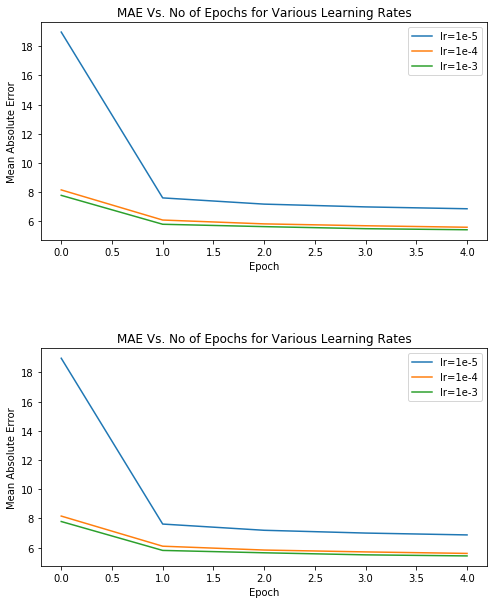

In [18]:
import matplotlib.pyplot as plt
def plot_history(history, history2, history3, history4, history5, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    axes[0].plot(history.history[metric])
    axes[0].plot(history2.history[metric])
    axes[0].plot(history3.history[metric])
    #axes[0].plot(history4.history[metric])
    #axes[0].plot(history5.history[metric])
    
    try:
      #axes[0].plot(history.history['val_'+metric])
      #axes[0].plot(history2.history['val2_'+metric])
      #axes[0].plot(history3.history['val3_'+metric])
      axes[0].legend(['lr=1e-5', 'lr=1e-4', 'lr=1e-3', 'lr=1e-2', 'lr=1e-1'], loc='best')
    except:
      pass
    axes[0].set_title('MAE Vs. No of Epochs for Various Learning Rates')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    axes[1].plot(history2.history['loss'])
    axes[1].plot(history3.history['loss'])
    #axes[1].plot(history4.history['loss'])
    #axes[1].plot(history5.history['loss'])
    try:
      #axes[1].plot(history.history['val_loss'])
      axes[1].legend(['lr=1e-5', 'lr=1e-4', 'lr=1e-3', 'lr=1e-2', 'lr=1e-1'], loc='best')
    except:
      pass
    axes[1].set_title('MAE Vs. No of Epochs for Various Learning Rates')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_history(denoise_history_adam_lr1, denoise_history_adam_lr2, denoise_history_adam_lr3, denoise_history_adam_lr4, denoise_history_adam_lr5, 'mean_absolute_error')

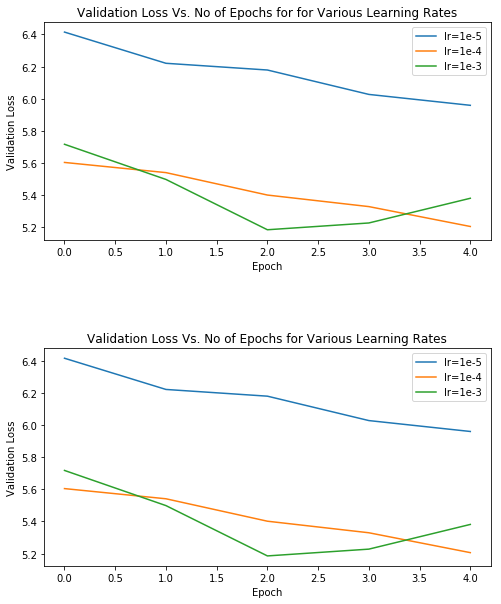

In [17]:
def plot_val_history(history, history2, history3, history4, history5, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].plot(history2.history['val_'+metric])
      axes[0].plot(history3.history['val_'+metric])
      #axes[0].plot(history4.history['val_'+metric])
      #axes[0].plot(history5.history['val_'+metric])
      axes[0].legend(['lr=1e-5', 'lr=1e-4', 'lr=1e-3', 'lr=1e-2', 'lr=1e-1'], loc='best')
    except:
      pass
    axes[0].set_title('Validation Loss Vs. No of Epochs for for Various Learning Rates')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    #axes[1].plot(history.history['loss'])
    #axes[1].plot(history2.history['loss'])
    #axes[1].plot(history3.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].plot(history2.history['val_loss'])
      axes[1].plot(history3.history['val_loss'])
      #axes[1].plot(history4.history['val_loss'])
      #axes[1].plot(history5.history['val_loss'])
      axes[1].legend(['lr=1e-5', 'lr=1e-4', 'lr=1e-3', 'lr=1e-2', 'lr=1e-1'], loc='best')
    except:
      pass
    axes[1].set_title('Validation Loss Vs. No of Epochs for Various Learning Rates')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_val_history(denoise_history_adam_lr1, denoise_history_adam_lr2, denoise_history_adam_lr3, denoise_history_adam_lr4, denoise_history_adam_lr5, 'mean_absolute_error')

## Training a Descriptor Network
In the last section we trained a model that given a noisy patch, outputs a denoised version of it. We hoped that by doing so, we will improve the performance of the second part, which is training a network that outputs the descriptor. As we mentioned, a descriptor is a numerical vector that represents the small images we have. The dataset consists of a large number of small images, which are cropped patches from other larger images. Hence, they represent some local part of a scene. That is why there are no objects represented, only corners or textures. Each of these patches is related to a subset of other patches of the dataset by some kind of geometric transformation (e.g. rotation).  For a given patch, we want the network to output a vector that is close to the vectors of the patches that represent the same local part of a scene, while being far from patches do not represent that local part of a scene.

To do so, we will build a convolutional neural network that takes the input of $32\times32$ and outputs a descriptor of size $128$. For the loss, we use the triplet loss, which takes an anchor patch, a negative patch and a positive patch. The idea is to train the network so the descriptors from the anchor and positive patch have a low distance between them, and the negative and anchor patch have a large distance between them. 

In this cell we generate a triplet network, which is a network formed by three copies of the same network. That means that the descriptor model will compute the descriptor for the input `'a'` (anchor), the same descriptor model (with the same weights) will compute the descriptor for the input `'p'` (positive), and again the same model will compute the descriptor for the input `'n'` (negative). 

**Updated explanation**: Due to the way Keras handles the compile method, it needs a loss as an argument in that compile method. However, our loss is computed in the lambda layer, so we want to minimize the output of that layer. As we want to minimize the output of the Lambda function (in this case the triplet loss), we output as the label in the training_generator a vector of zeros and we compute the mean absolute error of the triplet loss and this vector of zeros. To give you an intuition, what we aim to minimize is
$$  |\text{triplet_loss} - 0| =  |\text{triplet_loss}| = \text{triplet_loss} $$



In [ ]:
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

Here we use the class HPatches, which loads the corresponding files by using the method `read_image_file`. It reads the patches. The output of read_image_file is a tuple of the form (images, labels), which is passed to the class `DataGeneratorDesc`. This class is a generator that creates batches of triplets, and each epoch is defined by the number of triplets in the argument `num_triplets`.

**Updated**: In the previous version of the baseline code, we were training the descriptor model with the noisy patches, not with the denoised ones. By adding the argument `denoise_model=denoise_model` to the class HPatches we can use the denoised images instead to train this descriptor model (if `denoise_model=None`, the noisy patches will be used). However, as it has to compute the denoised patch first, the loading of the data will be slower (6/7 extra min).  If you want to train the model with the clean patches instead, you can set the argument `use_clean=True`. In this last case, even if a denoise model is given, it will not be used. When running this piece of code **the type of patches (denoised, noisy or clean) used is printed**.

In [ ]:
### Descriptor loading and training
# Loading images
hPatches_adam = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adam, use_clean=False)
hPatches_adam_amsgrad = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adam_amsgrad, use_clean=False)
hPatches_sgd = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_sgd, use_clean=False)
hPatches_adadelta = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_adadelta, use_clean=False)
hPatches_nadam = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    denoise_model=denoise_model_nadam, use_clean=False)

# Creating training generator
training_generator_adam = DataGeneratorDesc(*hPatches_adam.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adam = DataGeneratorDesc(*hPatches_adam.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_adam_amsgrad = DataGeneratorDesc(*hPatches_adam_amsgrad.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adam_amsgrad = DataGeneratorDesc(*hPatches_adam_amsgrad.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_sgd = DataGeneratorDesc(*hPatches_sgd.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_sgd = DataGeneratorDesc(*hPatches_sgd.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_adadelta = DataGeneratorDesc(*hPatches_adadelta.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_adadelta = DataGeneratorDesc(*hPatches_adadelta.read_image_file(hpatches_dir, train=0), num_triplets=10000)

# Creating training generator
training_generator_nadam = DataGeneratorDesc(*hPatches_nadam.read_image_file(hpatches_dir, train=1), num_triplets=100000)
# Creating validation generator
val_generator_nadam = DataGeneratorDesc(*hPatches_nadam.read_image_file(hpatches_dir, train=0), num_triplets=10000)

We plot a random triplet in the form of anchor, positive and negative sample. The positive and anchor patches are similar between them (the difference is a geometric transformation, for example rotation), whereas the negative sample should be quite dissimilar to any of the other two.

In [ ]:
plot_triplet(training_generator)

We now train the descriptor model and save the weights afterward.

In [ ]:
#epochs = 1
### As with the denoising model, we use a loop to save for each epoch 
## #the weights in an external website in case colab stops. 
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)

### If you have a model saved from a previous training session
### Load it in the next line
# descriptor_model_trip.set_weights(keras.models.load_model('./descriptor.h5').get_weights())
# descriptor_model_trip.optimizer = keras.models.load_model('./descriptor.h5').optimizer

#for e in range(epochs):
  
descriptor_history_adam = descriptor_model_trip.fit_generator(generator=training_generator_adam, epochs=5, verbose=1, validation_data=val_generator_adam)
descriptor_model_trip.save('descriptor_adam.h5') 

descriptor_history_adam_amsgrad = descriptor_model_trip.fit_generator(generator=training_generator_adam_amsgrad, epochs=5, verbose=1, validation_data=val_generator_adam_amsgrad)
descriptor_model_trip.save('descriptor_adam_amsgrad.h5') 

descriptor_history_sgd = descriptor_model_trip.fit_generator(generator=training_generator_sgd, epochs=5, verbose=1, validation_data=val_generator_sgd)
descriptor_model_trip.save('descriptor_sgd.h5') 

descriptor_history_adadelta = descriptor_model_trip.fit_generator(generator=training_generator_adadelta, epochs=5, verbose=1, validation_data=val_generator_adadelta)
descriptor_model_trip.save('descriptor_adadelta.h5') 

descriptor_history_nadam = descriptor_model_trip.fit_generator(generator=training_generator_nadam, epochs=5, verbose=1, validation_data=val_generator_nadam)
descriptor_model_trip.save('descriptor_nadam.h5') 

### Saves optimizer and weights
#descriptor_model_trip.save('descriptor.h5') 
### Uploads files to external hosting
#!curl -F "file=@descriptor.h5" https://file.io


## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [ ]:
generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adam, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adam_amsgrad, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_sgd, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_adadelta, use_clean=False)
#generate_desc_csv(descriptor_model, seqs_test, denoise_model=denoise_model_, use_clean=False)


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification


### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching


### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [ ]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [ ]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [ ]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')